# Prise en main des données

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import math
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
# les dataframes sont chargées, concaténées et la variable 'Unnamed: 0' est retirée

df1 = pd.read_csv('df1.csv')
df2 = pd.read_csv('df2.csv')
df3 = pd.read_csv('df3.csv')
df4 = pd.read_csv('df4.csv')
df5 = pd.read_csv('df5.csv')
df6 = pd.read_csv('df6.csv')

data_frames = [df1, df2, df3, df4, df5, df6]

merged_df = pd.concat(data_frames)
merged_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [3]:
merged_df.head()

id        lat      long          ts
0  66  48.846460  2.306055  1556661600
1  66  48.846442  2.306054  1556661640
2  66  48.846465  2.306093  1556661690
3  66  48.846485  2.306105  1556661740
4  66  48.846450  2.306070  1556661880

In [4]:
print('nombre de lignes:', merged_df.shape[0])

nombre de lignes: 1175842


Pour avoir une vue plus simple sur les timestamps, nous ajoutons une colonne représentant le datetime sous forme YYYY-MM-DD HH:MM:SS

In [5]:
merged_df['timestamp'] = (pd.to_datetime(merged_df['ts'], unit='s')
                     .dt.tz_localize('Europe/Brussels'))    


Il n'est pas précisé si l'enregistrement GPS continue si le moteur est à l'arret ou non, nous allons le déterminer si après en calculant la différence maximale entre 2 timestamp et pour chaque vehicule.

In [6]:
max_diff_ts = {}

for vehicule in merged_df['id'].unique():
    
    diff_ts = []
    
    df_vehicule_targeted = merged_df[merged_df['id'] == vehicule]
    df_vehicule_targeted.sort_values(by = 'ts', inplace = True)
    df_vehicule_targeted.reset_index(inplace = True)
    
    for row in range(df_vehicule_targeted.shape[0]):
        
        try:
            
            diff = (df_vehicule_targeted['ts'][row+1] - df_vehicule_targeted['ts'][row]) / 60
            
            diff_ts.append(diff)
        
        except: continue
    
    max_diff_ts['{}'.format(vehicule)] = max(diff_ts)
    
    
    
    
    

In [7]:
print('Temps maximum de la perte de signal GPS: {0:.2f} min'.format(max(max_diff_ts.values())))

Temps maximum de la perte de signal GPS: 11.33 min


Au maximum, un vehicule n'a émis aucun signal GPS pendant seulement 11 minutes, nous pouvons considérer que le tracking est donc fait en continue même si le moteur est éteint.

Remarque: Cette perte de signal GPS pourrait être dû au passage du véhicule dans un tunnel par exemple

### 1.       Quelles sont les étapes du trajet du véhicule n°78 lors de la journée du 2 mai?

Nous définissons un nouveau dataframe propre au vehicule 78 sur la journée du 2 mai ordonnée dans l'ordre chronologique.

En unix epoch, le 2 mai à minuit correspond à 1556755200
et le 3 mai à minuit correspond à 1556841600

Nous définissons le concept de "étape du trajet" comme un arrêt prolongé ou un mouvement prolongé de l'ordre de quelques minutes.

In [8]:
df_78_2_mai = merged_df[(merged_df['id'] == 78) 
                        & (merged_df['ts'] >= 1556755200)
                       & (merged_df['ts'] < 1556841600)]

df_78_2_mai.sort_values(by = 'ts', inplace = True)
df_78_2_mai.reset_index(inplace = True, drop = True)


Nous définissons ensuite une fonction qui donne la distance séparant deux plots GPS

In [9]:
def distance(origin, destination):
    lat1, lon1 = origin[0], origin[1]
    lat2, lon2 = destination[0], destination[1]
    radius = 6371000 # metres

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d



Nous calculons ensuite la distance parcourue entre deux plots GPS, c'est-à-dire entre deux lignes consécutives donc, dans l'ordre chronolique mais avec un pas de temps irregulier à cause du tracking espacé de 10 secondes lorsque le véhicule est en mouvent et environ 40 secondes lorsqu'il est à l'arrêt.

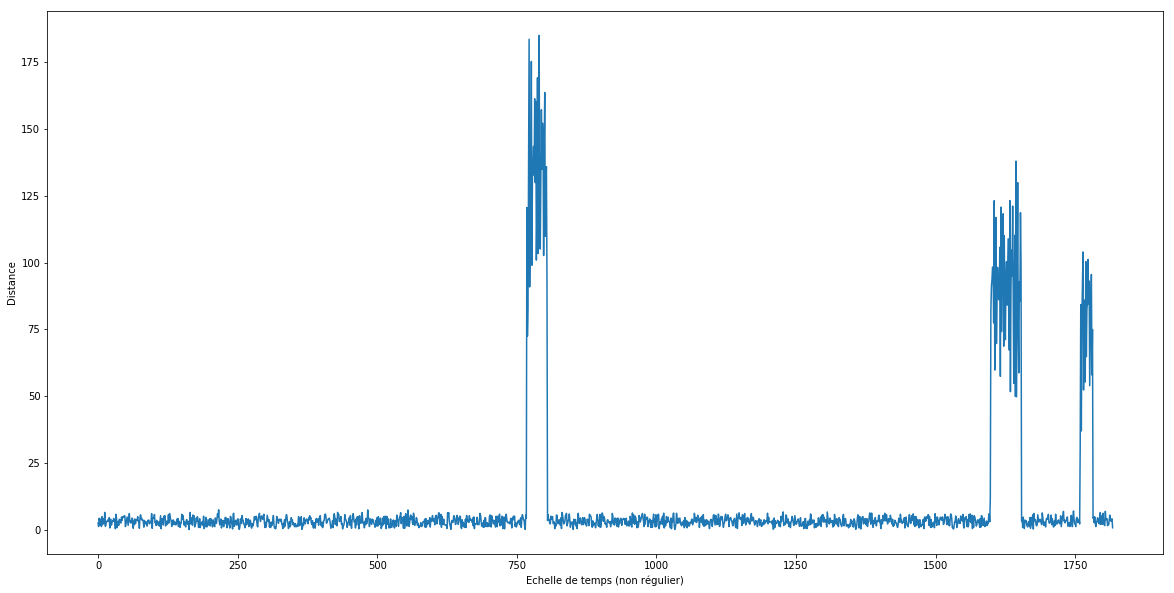

In [10]:
dist_array = []

for row in range(df_78_2_mai.shape[0]):
    
    try:
        
        dist = distance([df_78_2_mai['lat'][row+1], df_78_2_mai['long'][row+1]], 
                        [df_78_2_mai['lat'][row], df_78_2_mai['long'][row]])
        dist_array.append(dist)
        
    except: continue
        
plt.figure(figsize = (20,10))
plt.plot(dist_array)
plt.ylabel('Distance')
plt.xlabel('Echelle de temps (non régulier)')
plt.show();

Nous pouvons voir très clairement qu'il y a trois zones notables de mouvement du véhicule.

A noter un fort bruit sur le graph dû probablement à la précision du GPS.
Pour palier à ce bruit, nous allons espacer l'échelle de temps du calcul de la distance entre deux plots GPS, passant de 1 à 12 lignes, ce qui nous permettra de plus de distinguer un déplacement très lent à un arrêt.

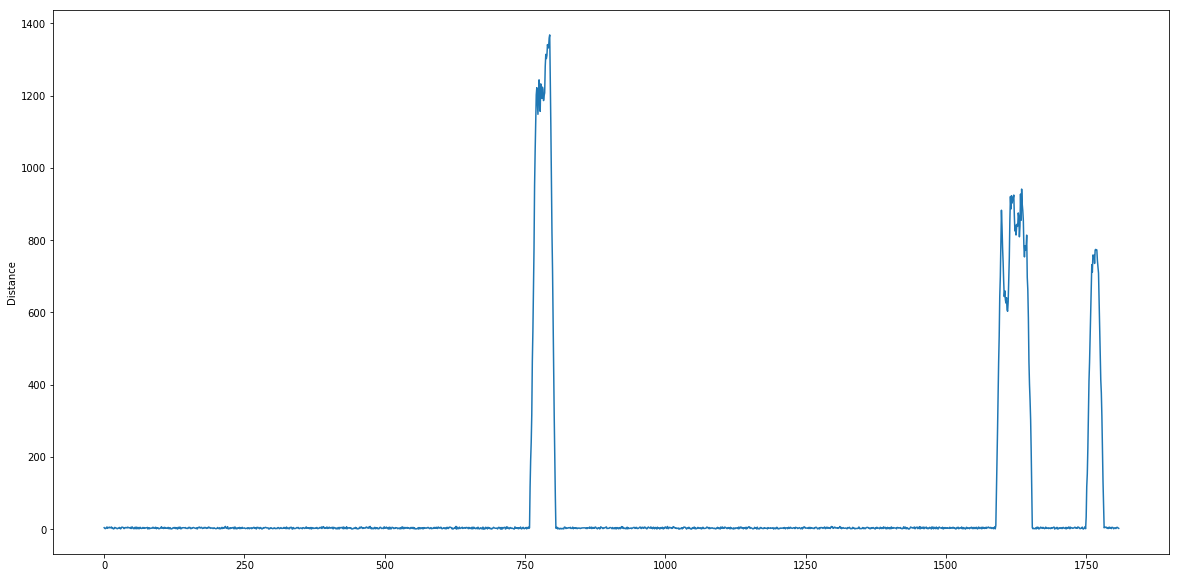

In [11]:
dist_array = []

for row in range(df_78_2_mai.shape[0]):
    
    try:
        
        dist = distance([df_78_2_mai['lat'][row+10], df_78_2_mai['long'][row+10]], 
                        [df_78_2_mai['lat'][row], df_78_2_mai['long'][row]])
        dist_array.append(dist)
        
    except: continue
        
        
plt.figure(figsize = (20,10))
plt.plot(dist_array)
plt.ylabel('Distance')
plt.show();

Nous constatons que le véhicule est à l'arret du début du tracking du 2 mai (correspondant à la ligne zéro du dataframe filtré), c'est-à-dire 1h50 à la ligne 750 environ qui correspond à 10h15 environ.
Un check sur une carte permet de voir que la zone GPS correspond au 16ème arrondissement de Paris.

Ensuite, à partir de la 750ème ligne (10h15) le vehicule est en mouvement pendant 6 à 7 min juqu'à une localisation dans le 2ème arrondissement ce qui concorde avec le temps de trajet compte tenu de la distance.
Nous pouvons remarquer des pics et descentes sur le graph zoomé à cette période ce qui pourrait correspondre à des arrêts ponctuels à des stops ou des feux rouges par exemple.

Par la suite, à partir de la ligne 1590 correspondant à l'heure 21h25 environ, le véhicule se remet en mouvement pendant 6 à 7 minutes environ pour revenir au même endroit que le matin dans le 16ème arrondissement.

Un peu plus tard, à la ligne 1755 environ, soit 23h21 environ, le véhicule se remet en mouvement pendant 6 à 7 minutes environ avec une plus grande vitesse moyenne que précedement, ceci peut s'expliquer par la faible densiter de traffic à cette heure là.
La destination atteinte correspond à une localisation dans le 7ème arrondissement (peut être une boite de nuit).

Le véhicule ne bougera plus ensuite.


In [120]:
df_78_2_mai.ix[0]

id                                  78
lat                            48.8691
long                           2.29737
ts                          1556755310
timestamp    2019-05-02 00:01:50+02:00
Name: 0, dtype: object

In [121]:
df_78_2_mai.ix[750]

id                                  78
lat                            48.8691
long                           2.29741
ts                          1556792130
timestamp    2019-05-02 10:15:30+02:00
Name: 750, dtype: object

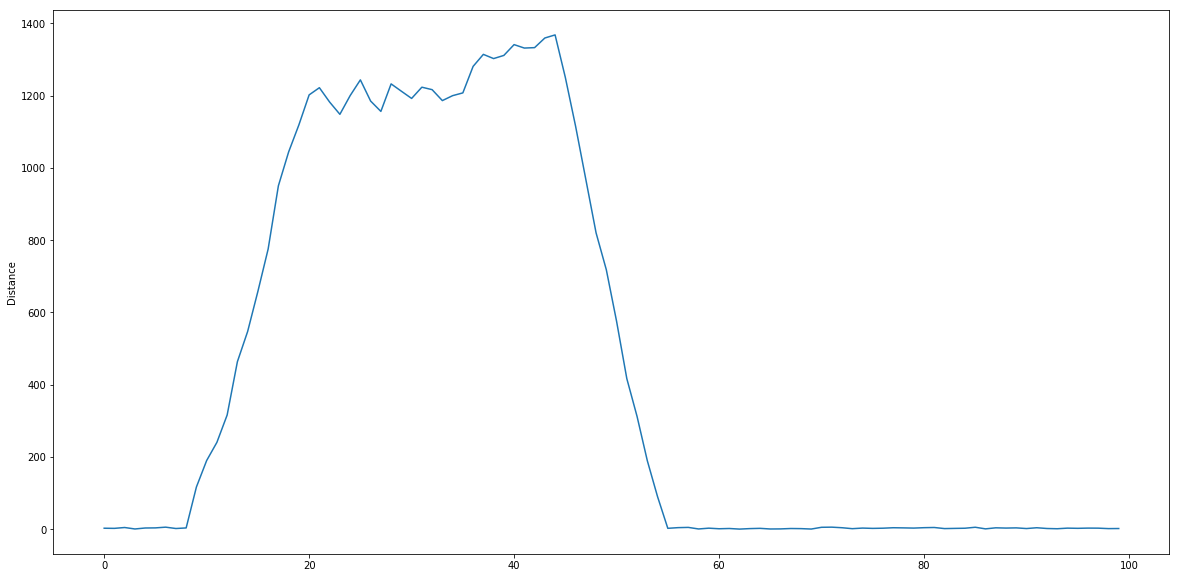

In [391]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[750:850])
plt.ylabel('Distance')
plt.show();

In [123]:
df_78_2_mai.ix[800]

id                                  78
lat                            48.8671
long                            2.3484
ts                          1556793400
timestamp    2019-05-02 10:36:40+02:00
Name: 800, dtype: object

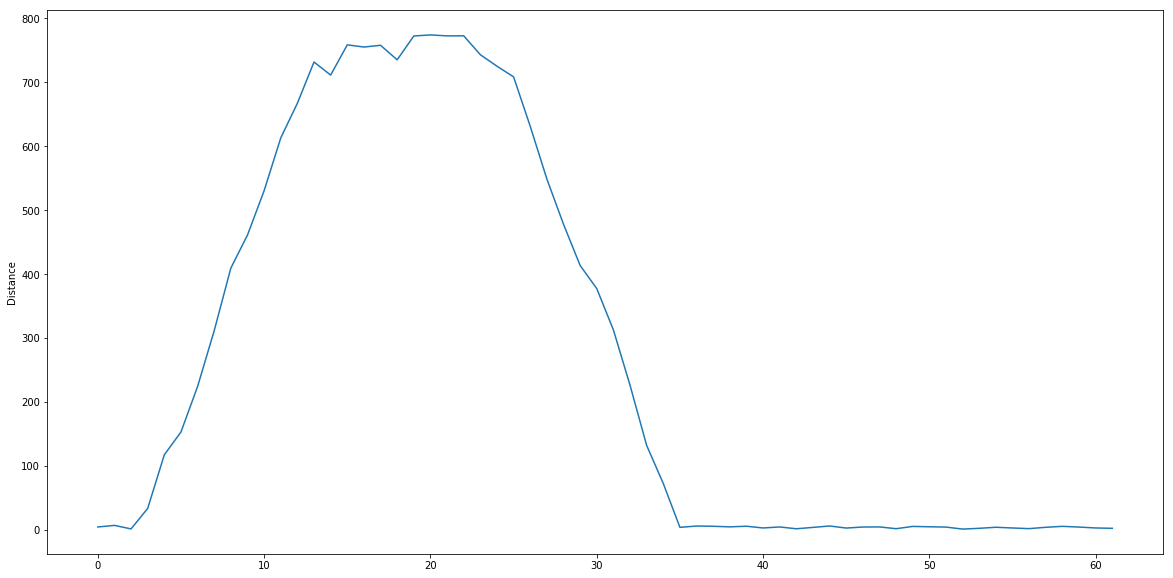

In [395]:
plt.figure(figsize = (20,10))
plt.plot(dist_array[1747:2000])
plt.ylabel('Distance')
plt.show();

In [396]:
df_78_2_mai.ix[1755]

id                                  78
lat                            48.8691
long                           2.29737
ts                          1556839280
timestamp    2019-05-02 23:21:20+02:00
Name: 1755, dtype: object

In [138]:
len(dist_array)

1818

In [142]:
df_78_2_mai.ix[len(dist_array)]

id                                  78
lat                            48.8553
long                           2.30375
ts                          1556841590
timestamp    2019-05-02 23:59:50+02:00
Name: 1818, dtype: object

### 2.       Quel est, à priori, le garage principal du véhicule n°57?

Nous partons du principe que le véhicule est garé dans son garage principal pendant de longue période par rapport à d'eventuels autres parkings, d'autre part, la période étudier se trouve sur une zone ou un pont est possible avec le week end puisque le 1er mai est férié.

Nous créons un nouveau dataframe filtrant le véhicule 57 pendant toute la période, les lignes sont rangées dans l'ordre chronologique.

In [12]:
df_57 = merged_df[merged_df['id'] == 57]

df_57.sort_values(by = 'ts', inplace = True)
df_57.reset_index(inplace = True, drop = True)


De la même manière que précedement, nous calculons la distance parcourue entre deux plots GPS, c'est-à-dire entre deux lignes consécutives donc, dans l'ordre chronolique mais avec un pas de temps irregulier à cause du tracking espacé de 10 secondes lorsque le véhicule est en mouvent et environ 40 secondes lorsqu'il est à l'arrêt.

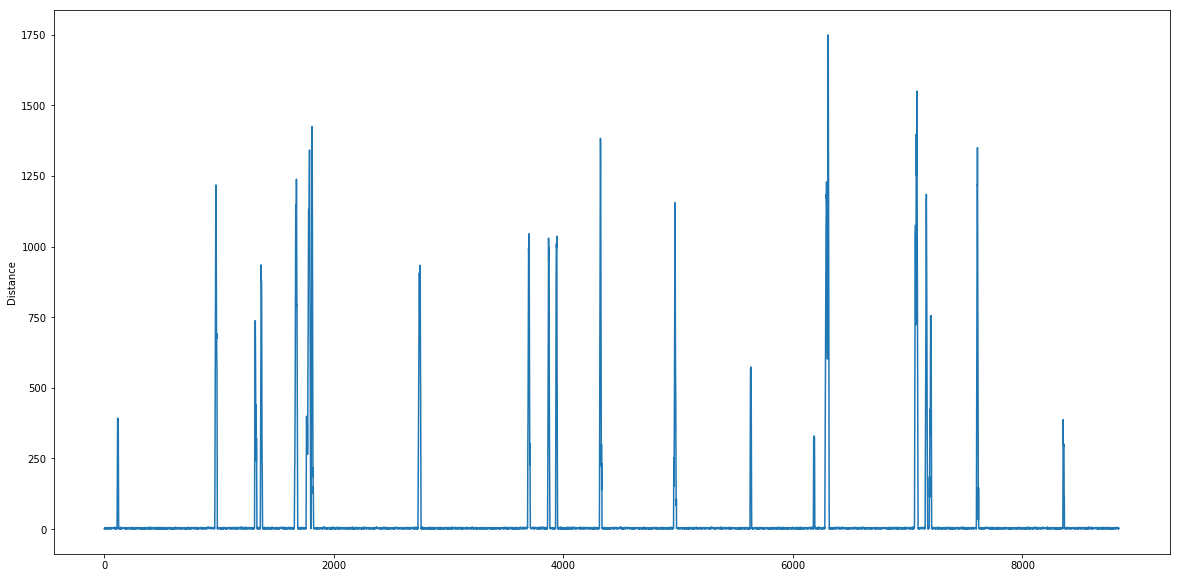

In [13]:
dist_array_57 = []

for row in range(df_57.shape[0]):
    
    try:
        
        dist = distance([df_57['lat'][row+10], df_57['long'][row+10]], 
                        [df_57['lat'][row], df_57['long'][row]])
        dist_array_57.append(dist)
        
    except: continue
        
        
plt.figure(figsize = (20,10))
plt.plot(dist_array_57)
plt.ylabel('Distance')
plt.show();

Nous pouvons voir à l'oeil qu'il y a environ 21 arrêts plus ou moins long sur le graph.

Nous allons sortir les index correspondant suivant une distance entre 2 plots GPS infierieur à un epsilon à déterminer de sorte de se rapprocher des 21 arrêts sur le graph.

In [14]:
res = [[]]
i = 0
epsilon = 8


for index in range(0,(df_57.shape[0]-1)):
    

        if distance([df_57['lat'][index+1], df_57['long'][index+1]], 
                        [df_57['lat'][index], df_57['long'][index]]) < epsilon:
            

            res[i].append(index)
            
        else:
            
   
            i = i + 1
            
            res.append([index])
               
   

list_array_final = []

j = 0

for i in range(len(res)):
    
    if len(res[i]) > 1:
        
        list_array_final.append(res[i])
        
print("nombre d'arrets comptabiliser:", len(list_array_final))
    

nombre d'arrets comptabiliser: 23


En choisissant espsilon = 8 mètres nous avons environ le même nombre d'arrets que trouvé visuelement.

A présent, nous mettons dans un dictionnaire le premier et dernier index de chaque arrêt.

In [15]:
indexes_stop = {}

for stop in range(len(list_array_final)):
    
    indexes_stop['stop_{}'.format(stop)] = [list_array_final[stop][0], list_array_final[stop][-1]]

In [16]:
indexes_stop

{'stop_0': [0, 120],
 'stop_1': [124, 971],
 'stop_10': [3711, 3871],
 'stop_11': [3882, 3941],
 'stop_12': [3949, 4323],
 'stop_13': [4336, 4969],
 'stop_14': [4985, 5635],
 'stop_15': [5640, 6187],
 'stop_16': [6190, 6287],
 'stop_17': [6316, 7068],
 'stop_18': [7090, 7161],
 'stop_19': [7173, 7197],
 'stop_2': [984, 1318],
 'stop_20': [7208, 7607],
 'stop_21': [7618, 8361],
 'stop_22': [8365, 8849],
 'stop_3': [1328, 1368],
 'stop_4': [1377, 1664],
 'stop_5': [1685, 1767],
 'stop_6': [1773, 1779],
 'stop_7': [1798, 1810],
 'stop_8': [1822, 2742],
 'stop_9': [2759, 3697]}

A présent, nous créons un data frame de statistique sur ces arrêts

In [18]:

import numpy as np

Resume_stationement = pd.DataFrame()

#Resume_stationement['place'] = ['parking_{}'.format(i) for i in range(1,23)]
Resume_stationement['time_of_arrival'] = [np.nan] * 23
Resume_stationement['time_of_departure'] = [np.nan] * 23
Resume_stationement['duration'] = [np.nan] * 23
Resume_stationement['lat'] = [np.nan] * 23
Resume_stationement['lon'] = [np.nan] * 23

In [19]:
for parking in range(len(indexes_stop)):
    
    index_arr = indexes_stop['stop_{}'.format(parking)][0]
    index_dep = indexes_stop['stop_{}'.format(parking)][1]
   
    
    Resume_stationement['time_of_arrival'][parking] = df_57['timestamp'][index_arr]
    Resume_stationement['time_of_departure'][parking] = df_57['timestamp'][index_dep]
    Resume_stationement['duration'][parking] = (df_57['ts'][index_dep] - df_57['ts'][index_arr]) / (60*60)

    index_stationnement_avg = (index_dep - index_arr) / 2 


    Resume_stationement['lat'][parking] = df_57['lat'][int(index_stationnement_avg)]
    Resume_stationement['lon'][parking] = df_57['long'][int(index_stationnement_avg)]



In [20]:
Resume_stationement.sort_values(by = 'duration', ascending = False, inplace = True)
Resume_stationement.reset_index(inplace = True, drop = True)

Resume_stationement

time_of_arrival          time_of_departure   duration  \
0   2019-05-02 11:09:50+02:00  2019-05-02 23:46:40+02:00  12.613889   
1   2019-05-01 22:28:40+02:00  2019-05-02 11:05:10+02:00  12.608333   
2   2019-04-30 23:44:10+02:00  2019-05-01 11:38:20+02:00  11.902778   
3   2019-05-04 11:07:00+02:00  2019-05-04 21:40:50+02:00  10.563889   
4   2019-05-05 04:52:50+02:00  2019-05-05 15:04:40+02:00  10.197222   
5   2019-05-03 16:53:10+02:00  2019-05-04 02:04:40+02:00   9.191667   
6   2019-05-03 07:54:00+02:00  2019-05-03 16:49:50+02:00   8.930556   
7   2019-05-04 02:06:10+02:00  2019-05-04 09:30:10+02:00   7.400000   
8   2019-05-05 15:05:40+02:00  2019-05-05 21:57:30+02:00   6.863889   
9   2019-05-04 23:27:50+02:00  2019-05-05 04:50:50+02:00   5.383333   
10  2019-05-03 03:05:30+02:00  2019-05-03 07:49:40+02:00   4.736111   
11  2019-05-01 11:42:00+02:00  2019-05-01 16:12:50+02:00   4.513889   
12  2019-05-01 16:51:40+02:00  2019-05-01 20:53:40+02:00   4.033333   
13  2019-05-02 23:49:00+02:00  2019-05-03 02:04:10+02:00   2.252778   
14  2019-04-30 22:01:00+02:00  2019-04-30 23:43:00+02:00   1.700000   
15  2019-05-04 09:31:00+02:00  2019-05-04 11:00:00+02:00   1.483333   
16  2019-05-04 21:45:00+02:00  2019-05-04 22:48:10+02:00   1.052778   
17  2019-05-01 20:58:10+02:00  2019-05-01 22:00:10+02:00   1.033333   
18  2019-05-03 02:07:10+02:00  2019-05-03 03:02:30+02:00   0.922222   
19  2019-05-01 16:14:50+02:00  2019-05-01 16:50:00+02:00   0.586111   
20  2019-05-04 22:52:40+02:00  2019-05-04 23:25:40+02:00   0.550000   
21  2019-05-01 22:10:40+02:00  2019-05-01 22:22:20+02:00   0.194444   
22  2019-05-01 22:02:10+02:00  2019-05-01 22:05:00+02:00   0.047222   

          lat       lon  
0   43.593633  1.443950  
1   43.593640  1.443925  
2   43.593618  1.443889  
3   43.593646  1.443898  
4   43.593623  1.443877  
5   43.593652  1.443944  
6   43.593628  1.443903  
7   43.593661  1.443914  
8   43.593618  1.443888  
9   43.593649  1.443915  
10  43.593652  1.443906  
11  43.593641  1.443943  
12  43.593651  1.443908  
13  43.597136  1.443323  
14  43.597120  1.443350  
15  43.597128  1.443363  
16  43.597091  1.443385  
17  43.597131  1.443370  
18  43.597113  1.443389  
19  43.597137  1.443321  
20  43.597089  1.443352  
21  43.597132  1.443337  
22  43.597093  1.443387

Certaines lignes de ces stationnemenst représentent en fait la même place de parking, il nous faut donc calculer la distance de chaque place de parking les uns par rapport aux autres.

In [21]:

def compute_distance_parking(resume_stationement):
    dist_parking = {}
    n = resume_stationement.shape[0]

    for index_i in range(n - 1):
        lat_long_1 = [resume_stationement['lat'][index_i], resume_stationement['lon'][index_i]]
        for index_j in range(index_i + 1, n):
            lat_long_2 = [resume_stationement['lat'][index_j], resume_stationement['lon'][index_j]]            
            #distance(lat_long_1, lat_long_2)
            dist_parking['{:03d}_{:03d}'.format(index_i, index_j)] = distance(lat_long_1, lat_long_2)
    return dist_parking

# return {index:{indexes...}}
def group_parking(dist_parking, distance):
    
    res = {}
    
    for i in sorted(dist_parking.keys()):
        
        if dist_parking[i] < distance:
            
            first, last = i.split('_')
            first = int(first)
            last = int(last)
            
            if first in res:
                
                res[first].add(last)
                
            else:
                
                found = False
                
                for j in res.keys():
                    
                    if last in res[j]:
                        
                        found = True
                        res[j].add(first)
                        
                if not found:      
                    
                    res[first] = {first, last}
                    
    return res

In [22]:
dist_parking = compute_distance_parking(Resume_stationement)
group_parking(dist_parking, 10)

{0: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 13: {13, 14, 15, 16, 17, 18, 19, 20, 21, 22}}

## 3. Si N véhicules (N>1) se déplacent ensemble sur une distance plus ou moins longue la même journée, ils forment un convoi. Identifiez les convois de la journée du 4 mai.



Nous allons créer un dataframe filtré sur le 4 mai, dont les lignes représentent les timestamps de manière unique, ou les vehicule sont en mouvement uniquement et les colonnes sont de la forme long_$i$ et lat_$i$ pour $i$ dans l'ensembles des id des vehicules.

Lorsque le vehicule $i$ n'est pas en mouvement au timestamp considéré, la cellule sera affecté de la valeur NaN.

In [127]:
# Filtration du dataframe sur le 4 mai uniquement

df_4_mai = merged_df[(merged_df['ts'] >= 1556928000)
                       & (merged_df['ts'] < 1557014400)]

df_4_mai.sort_values(by = 'ts', inplace = True)
df_4_mai.reset_index(inplace = True, drop = True)


In [128]:
df_4_mai.shape

(235035, 5)

Nous faisons une double boucle:
    
1. sur les id 
2. sur les timestamps des sous dataframe filtrés sur l'id de la première boucle (ces sous dataframe sont sorted sur le ts)

In [129]:
# filtration des timestamps ou le vehicule considéré est en mouvement uniquement puis les dataframes sont concaténés



dico = {}
epsilon = 3

for vehicule in df_4_mai['id'].unique():
    
    res = []
    key = 'vehicule_{}'.format(vehicule)
    
    dico[key] = df_4_mai[df_4_mai['id'] == vehicule]
    dico[key].sort_values(by = 'ts', inplace = True)
    dico[key].reset_index(inplace = True, drop = True)
    
    for index in range(0, dico[key].shape[0] - 1):
        
        dist = distance([dico[key]['lat'][index + 1], 
                         dico[key]['long'][index + 1]], 
                        [dico[key]['lat'][index], 
                         dico[key]['long'][index]])
        
        print(dist)
        
        if dist <= epsilon:
             res.append(index)
   
    dico[key].drop(res, axis = 0, inplace = True)        

df_merged = pd.concat(dico.values(), ignore_index=True)

1.8089483915459645
4.649118361336773
5.631093885106078
4.326779138033232
0.8300298096067669
5.059680718770972
2.4303451438822297
1.6712412332464737
5.402921659931847
0.14507705777424335
1.5134177031931908
4.179541729949304
2.0068902138171554
2.79352964571011
2.3080950211620332
2.3213308479051413
3.45177247211331
2.9150317470364664
4.730697096534541
2.301025035176556
1.600969303465791
4.961899810001881
3.2078771188089488
3.980987308755865
2.1708002481382245
3.354820285010503
2.27692448026087
3.9775817017136017
6.247369517199318
5.433444177135841
2.869435643675707
1.3087055582289908
2.207001865869097
2.5148178505163896
3.1866512691851443
1.2974908114529125
2.619161391154165
0.827718539345681
3.822624971093478
0.2006733447527374
1.6886096452368218
3.5342460805547526
4.345123110802548
0.21094198729029834
3.1811099707446777
2.9146193492001573
5.706600609337761
1.8353864843476078
2.624336854687943
1.1444226295321138
2.3723845792190157
4.404692730169113
1.6333776084644929
3.004572501307973
5.

1.9758252344253504
3.8251849576652925
4.286312200892338
2.5117193225616496
2.620701150449731
3.661595493022888
5.512737939564896
4.799272133465061
3.4013119811988095
3.0828132999849385
1.688910293886847
2.5875446026263043
2.1353247703749916
2.7337673629511086
1.9177130095859798
0.7396456334821395
4.246645880450927
4.163959425758378
1.6769462325436002
4.337138402197192
2.610402433001251
3.220757291767723
3.0811519135037764
4.388764705308081
3.870224627197774
2.9812830276612328
5.0631577577396145
0.9847302162497018
1.8613229382115808
5.853324493643508
0.6583940010760682
4.860892534209882
2.6642740132092086
2.4088204303960143
3.273971592254124
1.7436739991395689
0.916713432030754
1.4618220129437962
3.8790069648904715
4.008223681561263
1.1682961417230657
3.047268914548251
2.354767975130547
1.0173097759688632
3.2054406261253945
2.3227569544475863
3.631253675363293
5.284128513932247
4.692854273309918
3.9510067104513613
1.126748449715717
1.6355282847118628
33.06064687474494
117.1583189241897


0.40735368022655266
4.766252256383779
1.191002227946039
2.6529366902778775
6.0234540599524795
4.718797604766991
3.784587428182156
2.933029580922005
4.025072267787765
5.367424670191096
5.102702416627136
3.1429274479411795
4.208471896187786
4.354511118019635
3.5485491416912187
3.8404051550704263
0.6374074564065183
3.6455354571953973
2.1564443057019336
3.925301621593487
4.300261410479846
3.152867891803836
4.641081872930223
4.056733730099572
4.446935850634101
2.976075672132012
4.916491842348277
0.7116247539337762
1.1117796314809583
3.9209882715476967
4.914485745326977
4.268060325043425
5.748440562481991
3.3637828568130637
2.453798976062018
1.1313024578663593
2.43552829102849
2.8680009828866937
3.320745263007343
1.6092391422604908
1.0322684337046737
3.900850596843757
0.7591700563914563
2.843617969926043
2.9473162720305046
3.3928701625788693
5.700632086928561
3.492309529950511
2.0163589479489934
1.7823201160596045
2.08737281255802
2.847529236189267
1.321560250513559
1.6330306726189796
0.7361

1.2662534860548942
2.4990583206425168
3.059036218383828
1.1351474826667511
5.218935104813788
2.469862210325522
1.433147999121691
4.7768715606869
2.979020330524883
0.825690232006315
5.46451063598602
4.53000120046617
3.960980513639116
2.9311999016366914
0.6743185377031842
2.0109635517537394
5.4877779535855895
0.5937029338885426
1.986481314917847
4.272544699032633
3.232340028549606
1.0964364964351077
2.2861894931712983
2.2856898705493736
3.0885681045357813
3.3295966527346628
2.4156762840406
3.6510673816878474
2.57903598532193
3.1038523633819177
4.040881542478056
2.443040325156961
2.0533387835870354
2.0240583059266832
1.1994283422406562
3.685275573434072
3.128771808578918
5.073004999777967
3.49234140564195
3.6893702126703527
0.8286388230429327
0.5564523022553636
1.9472256816870062
4.1820996084726065
4.5273099575306075
4.617982931462413
2.384403351060369
1.6745966082473345
3.240008115912517
0.5776279474157686
1.5068037085005128
3.9058285880704413
4.5167909429063995
4.936983658533999
4.23158

3.8047708843150567
2.9539448559896786
2.6383139627551895
1.420624075018969
3.0403368644654636
4.147670859351299
1.8794065126735668
2.1937017252382525
0.6184788979456372
3.4178029918365285
3.662294505007141
3.7384412220234267
4.3450679663651695
3.156255419180324
4.396626885817568
2.1863948544805853
5.739747461904568
6.056439198290021
4.780515162136276
3.4928811902323984
2.741217971550408
3.588472453945134
5.267945043717318
2.4078506023939994
4.982956831639018
3.521319167892595
6.304377881544395
4.56260398901597
4.302686820258325
2.7896875798899265
1.7602103640218976
3.2726340806659526
4.077358207325983
3.5385601820628323
3.5288171410168707
1.6681279295384832
3.640542460403415
3.689483675793005
4.338349989660514
0.5223825669225357
1.580609928251681
2.6513307303683367
1.4797355764845586
3.9875063264191803
3.210561531083656
3.8514580428592673
1.4646026701551456
1.2033856885538659
1.2596746728440287
5.056694551298767
7.023998044601845
4.794853537741966
2.425051486577385
1.8836622939239493
3

0.7662954015392833
3.509859651424985
2.3030683423055613
4.25755645394704
0.6940871383188824
2.998118851645807
5.567657853980436
6.981150066902046
3.5322042968483416
0.9927699976973117
3.0731082110903953
2.9218447222613677
2.7704044829214505
4.684508959564242
4.518304720184384
5.0108282418445595
3.896012214795893
4.837407311055141
0.9881607393277685
0.7045561834367127
3.015695593928515
3.0346955859676057
2.4020875480916
3.237394017397895
2.943254373008606
4.691755730608798
1.7807023520238483
3.8030372113336846
3.1684790575844186
5.83244547023787
1.0184979905484375
1.5445801695193462
3.9389357981434108
4.742170551875688
2.160315832265804
4.598382897411187
2.053813055338769
2.3313666082736253
3.6878507096808453
1.4451022013838648
2.559611512777627
4.490868180530089
5.039206350641543
2.485423309427151
5.447699636932861
4.73096952615274
3.3781028980476213
3.0922180230868133
3.580283160821275
3.5399336994630533
0.8147586164601621
3.4712130625627444
4.8443017891732065
2.351064916625686
0.8097

4.731641561247242
3.9371723972981325
1.7533368525583801
3.1310512468999954
4.685760945463745
5.841276664964255
5.233680828683215
2.9701616028722286
4.275970994925354
3.761332512384882
3.026215097761575
6.489703428918317
2.225245462613232
3.9923601715368644
1.9783258497781864
1.5449888243793817
0.8303352675940114
3.8681882403476453
5.172926363163389
4.6464052659330255
1.8767866037207208
4.442395463975723
3.2297509387882144
1.5779926107475752
3.407811260928604
3.8733343822962234
1.23403088932622
5.628624473268729
3.9734824156358806
0.6157366058442127
1.6084708275126076
5.334290831574785
5.219925013527673
4.772284708680201
3.0914482863667625
1.6601874126285032
2.4829484571969673
2.508781639020727
3.2293041114938124
2.848453188571405
3.2965881549141542
3.074923642951682
3.954492067937934
1.0834566664310699
1.2035950382064546
5.209797831049503
4.593292312782998
4.0527129773944255
2.927561866815679
1.425769021104853
2.1961744439889457
5.042237895752121
4.079522588235219
0.1255875456796314
1.

1.5257071343126427
3.9023483568866393
0.7303386588195425
1.8474604336086398
4.543992325537889
4.1096714868471445
2.9484870524688462
2.7508174632413747
1.324887303545901
4.385969045066477
4.021828399766958
2.363679890021584
2.6658687598482507
6.4502925587839055
5.417761534359218
4.091462550416571
4.399813909429391
57.20333054434912
76.72749927732573
73.59440863533457
93.42849292385309
60.819914424819856
81.22521035047954
78.26339501330821
78.9206925920968
61.3913803485465
80.75915246877098
88.83845156976027
102.11936954949796
70.14103023879822
64.04107425872282
65.61807854720288
80.7421995156435
73.25559440497136
87.169701389383
77.6796361345658
74.23682927214854
82.45323765758656
93.31262173405356
67.59316740026883
76.57479033040188
75.65136233489575
85.885697922663
69.11293234606917
107.03886524926652
50.448381165487575
82.74565378824924
105.48701477927405
47.293518468767516
88.88538734633532
69.88933139052452
101.78014780222261
66.71542561043074
73.0508084900462
95.99583182968334
88.

3.381878607911089
5.679350095732283
1.7067573197274315
3.8475282941060724
4.444212678574022
6.772878908583783
3.9434479320980325
3.4109124179147376
1.4331340239002817
2.8681848375889127
3.058522166808084
3.5054497402085274
2.0753637651994246
5.148368512865883
3.7413489572332788
4.005433216297742
2.4916340205576923
1.8680449297357478
2.5200607751283397
2.952919679605487
1.5465644871824753
1.8068618518818393
1.5106124373558112
2.138068205881146
0.4512293923215033
4.3406576523344365
1.8738256750794695
2.7061386143649746
5.125827167122416
1.7819076363757569
5.578214952425263
5.275586971362204
0.7945248151387756
4.491021466554937
1.9529555283162732
0.6782320287945633
3.6203348090195493
4.453268649096256
1.8404283346590278
4.330419929749313
5.136782458500922
0.7052697032394347
5.392102782108759
4.752643816875656
3.3796852102074824
3.3384826820037823
3.100741273623395
1.0398920920951302
1.1959307772526744
5.116723397042467
2.3178817571708614
3.065740056674008
13.83128971082666
127.92990566768

4.511987293124086
2.2227856189814137
3.025596240834576
6.386729519220938
0.8933629140776719
5.3087947900330485
4.390585990570615
6.219187227645059
3.504161551588888
4.860641050841151
3.849958623648681
4.854994007113848
3.1080984819326165
1.226598508862179
1.5864717247379674
4.260539732435242
4.986265380673715
2.533935025687079
2.533170612715656
2.280987917416968
2.434764696813363
0.9587049353962613
2.9175644516241683
1.0690418048457075
3.2567824947952118
2.7027579128380466
4.418216699268493
2.3089598097587443
3.2716997872714315
3.672395434442039
2.5719499260216123
1.0754457866906726
3.3468819272994104
2.4316890172199948
1.2629406041505744
0.4645959129874667
4.954283169938623
1.3756391897142324
4.176948814471368
3.7758272977738727
2.004773155293133
5.127890753884569
4.451043530878622
3.6839065437977982
2.1258372201811624
1.94222899074508
3.241780067017371
2.2969084152477124
3.1122768639470104
3.779704035052441
4.278088178437153
1.7780083281999022
4.684862589669604
1.34294309586354
5.488

2.5538614322906317
5.522191472361523
4.392199269533271
4.648825618155034
1.0585994368812532
5.793177649062406
3.915483435969559
3.838127771946588
4.509637331885325
3.0312859952114137
1.6644413137881395
1.2482097418304134
3.8947867910706493
2.181251535557595
4.118077931816193
4.712273445444643
3.1941478543983988
1.4393424053170145
2.913445949317243
2.3773132549509515
0.6665710268849765
3.6382749140349606
1.3447239305883534
2.9872516931552133
0.4203117598391817
2.912771526261577
4.5758971412277765
4.461657134048015
3.390017170783148
3.023523384009805
4.190776514757464
2.665224907014416
3.9931260350395235
1.8670322962245207
2.7342343380450354
2.6828777502385033
4.842850238092731
4.526046860838736
3.022045699194571
1.597861066705618
2.5089311289248606
3.013457460295785
0.5787438434906022
4.636296937988291
2.450065147963525
3.6786525272030604
1.8564458777439745
1.6786154184463242
0.7892684610002916
2.7270310153451267
2.325774435351446
3.6700506737232894
0.4709308738190156
2.029423314079027


4.348290627054276
2.552345048677507
3.7580435016218114
4.0324150708988675
4.844789373173235
4.890963114349023
6.257857222795426
6.5103917594859775
3.614885125796807
4.277948630311106
4.762849403708954
1.6472440145938056
1.1091305409306702
4.387006705712433
2.3462171426334373
3.7818646041539448
3.2877631473703524
2.1943471023465775
3.6487570178387854
2.3117526241595834
4.201440204565524
2.3363720055849084
1.1441388340079028
4.537246910588612
7.308678149446176
6.550890637228607
6.743403501243865
5.916551890117901
1.2754625124307053
2.2328930311310144
2.837548611966949
2.3199321527088714
2.1855440260509154
4.276650395808155
1.0319127371924162
1.3594979620567458
3.062280822175894
3.1243001580321397
4.913963848206625
3.590054499330443
4.406500458722487
1.3662465520705882
2.3109096833720972
0.4804229586537611
0.33911796149126683
1.4721137940581535
2.455205751241709
2.1343322532350197
2.0472244154809065
3.9489648134322404
1.8120642729234113
2.0491961306548196
2.92653740015879
4.60270216676207

115.87052165474584
80.02023149948695
83.1583585825156
82.37343956513025
87.49959844375353
119.3306549793445
62.23890398155026
123.39328063889268
59.10201043037691
96.75150197722722
88.36212215167902
80.65726782687463
82.3267120972796
66.61624118465555
125.13950739781713
69.43178685067754
64.23610609596379
6.435746743056437
3.656427942633724
3.995194032521152
2.4280904663437393
1.6528169304458844
4.785891439366882
2.4751388359605984
3.7521033125124004
1.1600721626382444
1.5069658851217196
4.186284270147174
1.64705916357094
4.066981678170453
2.0659467765037443
2.6894610714471803
1.4598342478265813
2.1875527293720296
3.8209888568503985
1.3903074840920207
1.899979682022759
4.00249712672835
5.204200871055961
0.20312353747486606
4.67393779381154
2.88560007551524
1.997556183886386
3.1721269207854648
4.808981508995247
3.432478837455068
3.702338769394269
3.37503699676977
4.650068509376073
6.163949562918828
5.401869284770844
3.1418454097719697
3.1091875419067927
5.825666317753373
6.0564627275996

3.683024275188274
2.8845526381729014
2.318973841971742
5.7354255593288475
5.173014981911771
0.5565271661362153
4.3615017315749185
5.447461514289342
5.327280193903234
4.710748114212531
2.4269145857815757
3.9831040562964586
0.8802615638874268
4.183641336038904
2.9825643734682523
3.9041622299098546
3.4128560134144545
4.075727577374531
3.0744981106120726
1.3488607527041088
1.4283329665911408
1.856507599389548
3.124721022349434
3.8005330079639847
2.281766630422645
3.0309651354015323
4.061795385226957
1.531056944895338
1.8922537141587012
5.078506271636154
5.334742723624276
3.169394484576824
3.075455024906234
1.781332878595849
4.674412516598072
5.185704452728229
1.9962228842412368
1.8822555838377697
3.958294498844611
3.704149029933661
2.4015776863592433
2.9800294160202974
4.137002493275738
0.6816347138239265
2.1445762964429984
4.504646537863044
1.8683861003556883
2.352124228543717
3.5283947716836477
0.9718837916274623
4.90923851886045
4.801376424599006
4.433877319319716
3.3422968312356067
3.1

3.3795265058263646
2.364756316340989
2.6985341498376334
3.9829883947631712
2.4110410783079987
2.7962115843197926
3.7321378987625606
0.761686775029554
3.9382306070579842
0.5657242250832895
3.618667684584257
3.498039305386546
3.347327223349312
1.0427041899872913
3.252960912040376
1.5201143064518419
1.736045711455693
5.303643507596167
6.401981314803058
5.235299583471657
3.333208128854974
3.658655271944519
3.3284031916423302
5.5984933944239685
3.7144773388069017
3.189291703744012
6.613442949670385
3.6266201659977537
3.7660343373112273
2.3118437932732796
3.988639593906546
4.29533377542398
1.0255347651009543
2.386110473798887
1.71196184115062
3.307466409292489
3.975910325506775
4.81317095726415
6.117694395558842
2.1702120862207344
4.839615667479673
3.576060215408734
4.37668346259899
3.0524983940569044
4.854173799004111
0.5889076669642159
3.2501940973726
0.44609774137805047
4.236252854228925
6.703512573831642
4.479778780594027
2.4311823813866686
4.641698085846713
0.9774176209975095
0.95755236

1.315521191180048
1.313802777192625
2.6956277762384944
5.7986632217244045
0.1425130097759934
4.7370874749107745
1.7058939613966286
4.360016955860171
2.445506265899484
0.7242415646030048
2.2084401558186815
2.055490328478526
2.6970922411546274
4.39713249124086
2.9463669279139544
1.259623768610327
3.070032131248497
0.636772460525341
4.126659834261848
0.9484880549649592
1.1985530882222324
2.3407999932246057
2.294666329441433
2.6405104424936283
1.7252085677807631
2.2489974903273002
2.449520508841285
3.304487244910616
2.088051809237532
2.2775582099417613
2.612186766875805
4.69365660299561
1.5111735544109355
4.570910436134885
3.177218865458331
3.7558923502309813
1.3179036154630395
1.6927792483896875
3.937213214257492
4.996748538596555
4.285215339651686
0.46428659121608595
4.16095845345921
1.0311487443528888
0.3729025229353058
3.7610826309460936
4.882636303687532
5.513114565292246
4.459686599356776
0.24809245974627153
5.182891602020647
0.9324777024285792
3.2341499603067274
5.045779512747036
3.

0.625816570550979
2.83940747641403
3.483512740186908
4.889391544551222
3.5033483236142855
2.670795925055007
1.445367853737906
2.4401762307403305
2.9876179750184173
4.626537546302409
3.971570007997938
1.7728897669333117
1.5772989322364377
1.4772669383400836
37.54897625760557
83.97850303594053
80.22429529819709
74.93498941909424
92.9016690542944
83.45033243256245
102.52203064505034
90.39774964708768
66.55770320537907
81.56066645405765
83.24136075998182
86.37118302152398
90.1332218474549
119.74089404747095
55.159368520571206
86.29090694364491
83.0992203227172
124.41824841244556
49.06523012591382
107.92862931102033
70.19168714504038
83.06784435434069
108.35904507805407
68.77097365659877
86.1760404678461
87.71864228386718
86.28635333967111
96.17092226630477
79.05983574094427
90.45165479604502
102.49027043408252
107.18711304201025
73.76267871970967
64.72472753108727
98.84276145707888
68.04402467559589
91.71866128284007
83.57548522783665
102.98569763372339
94.4099696290529
77.79696571028074
7

4.089710029749705
2.188193533782168
0.7333412538536315
1.3030637063928119
2.5076254863361345
4.568006688919239
5.583491860278017
5.71201782278254
2.766747779558999
7.168793624069035
4.73185675813725
1.0600676882082087
1.5608723405863303
3.657277444355657
3.769455729720804
3.1627978482665067
3.2385142230005655
2.938788691507195
1.2048385324078257
3.8998096835337974
5.150330856682594
4.733024503220582
1.1550246741812662
1.4281429174967326
3.2447344962465525
1.8168766443280422
3.6943785637219246
4.137271569023091
5.852312484090394
3.1376263098784274
4.729542492152514
1.546471792623741
1.9374902734638095
3.8129392879406714
6.185057440710821
2.5264155600873366
2.3020708623239736
3.2659419652467117
1.5588683355296318
3.1693029893364573
5.3296058691680015
4.8966947603082405
3.7805709910310115
5.138419712938352
7.148349658458679
4.882795103076751
0.7317450381850475
3.909732544987476
3.9951915627105232
3.9936401011823865
4.251806552068516
4.938243641131986
5.085054561817851
3.5259275459683894
3

3.0472569684898545
1.0001464642204987
2.310163525389539
1.605001316208512
5.860415787109573
1.8699244944313906
2.742822400468317
1.4284069188803505
2.681131897610654
4.193997151764553
2.4175115089765664
3.2881939825460265
0.9333765885611008
4.884314901946188
2.342038354827525
5.60903549298661
4.514014649895244
6.904978426400006
5.86261871577794
3.1253362744427458
5.828135068443982
4.31054834054821
2.011245865272168
2.512793214673792
1.872259499267098
0.4405262853331652
1.2657001198545463
4.180411205695344
3.4609404462356306
1.1775736052058894
2.7226418467880533
3.3374556937889057
2.7716109534459483
3.8250076063172203
3.5981593077467164
4.719556204590475
4.758962279567775
0.8545628388093213
0.4704375039160138
1.3985758940373818
4.42116717141572
3.6335063909270167
3.63962929237596
5.3351740582706055
4.49295578975334
0.2720776615669217
5.329025199656285
4.51205130719077
1.067955584076976
2.016867606363152
1.4217411230068695
1.0522970094973043
2.1570665665828885
3.2274716743446312
2.961522

2.3788144243140903
1.9615972666661765
3.930048151536652
1.0526649019498284
2.3231941308473516
1.4767820748468576
3.2362984198928735
4.617395360711772
2.7978135955813452
2.1181367392079404
1.818039752368498
5.4693384997111405
2.6779347965547595
2.1212007206964656
42.86760022500476
103.3629949126763
142.5446141245973
84.7499238453534
129.4375762044642
115.52148523224717
97.38621159128004
117.48227841312749
97.69625368448862
112.4009721211718
103.80680126006688
123.06996827076823
124.22279740080927
98.61335013878863
102.81175898909427
105.30413540638112
123.20256136619322
97.6324308282662
105.97952938547652
122.29320636590955
82.77791237625902
113.37692104581414
137.33000400495268
102.10421412843321
78.69019448774647
94.31646268912962
4.3118022701982195
3.9567023009155156
1.1499384028708797
1.0311434812325686
1.690666028257623
3.6067626002287563
3.4952228508252925
2.867845498247331
2.9792494154703095
3.877846580602073
4.997168793446486
2.940759582263486
3.0491075147649815
1.84637934806968

4.0503004445045
3.4731166652227783
1.9084173600918641
4.420655316290479
5.079910039746075
3.3572973089059537
2.789277061075707
1.5808742506464486
3.2126377203488894
4.841552751084866
5.184842825300648
4.8699842908274285
4.267448669835574
6.373113125096864
1.1664879535363166
1.881312889936582
1.6624890435951178
3.0123739291485445
1.6580729540677934
2.5673185776112666
4.2671011750155285
3.95371277489726
0.12924346179066937
5.732042848810581
2.6625198111823183
3.146910985420612
4.224226646519495
4.922652339194472
2.110367560095156
1.7080001648885954
2.201944649745332
2.3297763185325526
2.560725934376931
2.644971229245557
2.4165476409737408
4.500253136001132
3.0432373057047593
3.953036900620756
5.443131120949182
5.394153980073519
5.927915754340289
3.0529496267506855
3.39606893549961
1.3448410752293427
6.194968569929564
3.1787069263415444
4.147087038957883
2.808069638200517
1.7949977958898242
4.873462725296054
1.9133208091560174
1.9550538082726294
2.163609500690789
2.1116002619935554
3.5778

1.4174061863082037
4.759691943695927
5.864802340690938
4.551984949439064
2.478511596679994
2.8351246475830028
2.4270284886814872
4.702305638616833
3.882824072718793
1.5053957284272725
2.725094985239225
4.774642908932326
4.586911455343339
1.5958702778190936
6.393629956674616
5.278835188851259
5.598851374208885
2.7676104002257227
3.4636094997632836
3.265679264407582
3.2832344964260214
2.83516262139074
2.485243591386276
2.200860213040739
2.3652334771995625
3.217548979846212
2.909808353314932
5.790800993778808
2.923787093787985
2.0724607048302284
3.4850226075776676
0.9416426504128604
1.6550836312257047
1.3418808519596048
2.1204050854393306
2.2430397425286333
4.705708963863682
4.210089351690405
5.74002656702086
3.57310051345733
102.57999663054622
73.51695322367306
102.84099026812743
82.71715178322442
89.84052695430341
121.30231203253479
75.44369839313362
76.98400472677399
91.82398537050936
95.82842484377025
79.14649593076726
95.369268651633
113.48022826973096
82.79368929671374
85.8602058981

99.7066400951971
47.711028663465726
80.26668970316906
66.02682057194555
93.26960558732357
61.88761799028771
80.67486441240314
59.82092393532496
76.5577407182959
76.16855611553056
99.97131935150003
46.404568564418256
91.46889099140637
61.746588027004826
77.23069887630443
80.30477528826144
79.58345871094
52.69018544069125
72.89582709895812
79.52388209158336
62.79506650245661
95.15453089123785
75.5819737289026
53.46375505967209
75.13852968172363
77.65934738006537
73.75129791778247
91.60773361931523
61.068044018831564
75.183509587584
79.41382908768081
57.41767789884824
109.4194319857553
62.736871631548055
71.79557785258208
59.55997944424536
64.14837044439228
63.466830320438106
86.81626929468729
68.00582622885331
73.32131885587773
92.13320247415177
78.87546725623358
59.90329508223558
67.78873249964357
92.09219756435414
54.995160918276994
75.98151630079954
72.46108393080523
77.54938379753453
84.84180265658364
63.64751227926824
73.38311503427865
82.77537324643515
68.17655259965893
72.65061027

4.645820166046251
4.51457557199737
1.7099062188762015
2.2122842826124827
3.9279976113272017
1.0283465223050985
1.9134370498321458
2.8057174663254014
3.0202363627931335
0.8577096471207857
1.666816744082254
3.361156645283584
5.296058932533837
5.200155571618086
3.1415360233769984
3.4810856869406357
2.3863584553822537
1.8393536200892935
3.910922958731532
2.3057718158350364
5.057792668235599
4.927109427593796
15.95795539983012
75.90599962143786
36.21751633637883
88.24531117183652
79.44207226203376
86.05473931747203
98.3296061255979
54.18482202044822
73.11303155576611
79.99467745470434
87.3143037386136
72.94567652930034
102.11566554765959
61.943958460986764
84.6788575467244
116.49562565805415
38.086910070436446
73.44994495142267
59.248515358702164
68.85934707008391
70.25599265726262
109.63078440972767
54.54500705570834
76.42362734196713
82.62959151564576
85.03530013764735
74.98214055513769
117.5543215085723
61.96507814707816
66.83989694741518
60.83349823633027
82.45263032240962
77.3294632531

2.493371015137934
2.1443668627963093
3.1032515540254186
5.016103743897926
1.313664027970395
5.781324958782403
0.8677326560614655
6.022973106589186
0.6442120635933283
2.6354334061553515
2.4499469837881414
4.9831327620207215
5.636801773636258
2.601371382145817
3.0792682763698402
3.4357636120101867
6.07288719485035
5.381504000689008
2.064294450189547
5.677041126001962
4.162497449772786
2.330360772206479
0.71202994733041
4.961338245463415
0.6145628449519889
1.8594315934582286
0.70468298080252
2.005260650378406
4.51742108830939
1.984691039343862
4.153503100592896
2.698758730549764
3.4656177050648447
5.17852537130762
3.2923424172312306
5.85219857434055
4.893088313578182
1.462981352756848
3.9046562921790366
4.514054091700793
2.3081915338900525
5.591985907188867
1.9136902350631417
4.577212989208683
3.1492463867864795
0.28678417772623704
2.7245786068539664
3.1448162168492884
6.052969551889074
3.9212505325012375
0.3718653658425994
3.0734028762526866
1.9846524807109562
4.763738923025978
4.5009598

1.8531684148627938
1.454238564234502
1.320201465372221
1.5005701243513327
3.3454565197670996
2.7311893025812566
2.19961135620178
3.5113429971469734
4.810067399022811
2.079433194418743
5.886643776834875
2.965342165641975
0.9878488258258161
4.169068724771722
5.076768968512942
4.597822741727841
3.0478831908629367
3.8304898456445406
5.511421039462941
3.151708343781443
2.7682369891118235
4.248120192622636
4.645871493353656
2.5622087021345354
5.445971371614233
5.567142569328821
3.6634381003202026
1.685017552824196
1.6016391954421925
4.325700743307013
3.404173554407882
4.503504018572875
3.276277661840213
3.721393863900324
2.355841386621895
1.68526650132261
3.986102288114241
4.75578298956592
5.8494874214827695
5.161482073829813
6.483514281548286
3.6299264931035404
1.1039944985458574
2.270685275383941
2.7351241643832624
2.0402285475456874
2.2822357270283837
1.434832782426475
1.2930277556598475
3.200873077180884
1.3690668688285486
2.14895604126816
2.7980032833696313
3.37606469838886
4.6234053383

3.222023581965262
4.95474542788584
5.306923370421549
2.10950717594502
1.426897184243795
5.22815059660776
2.963262831235996
3.2908315943255904
0.7997413804303076
3.1170843758848297
5.050366448466445
1.5977673854381342
3.2631655955449146
3.105573406289839
3.5230306523171184
4.352893625917323
0.9483369689281373
5.82786479939011
0.7542141353739087
4.028616735056601
2.838272422395212
4.413585726827333
4.259100058758834
5.174582539830966
2.1826986158427157
2.878086454722065
4.996258113494757
2.00181740464395
4.335215093288963
0.4410166172029173
1.2794986490411278
4.4674852454000895
2.307960745426774
2.613743557561469
1.4499910707938983
3.303048372075242
1.6595193458257562
4.769775200734288
5.644380462165822
0.8456061203255432
1.1002738437906054
5.13271232497535
4.582612419946763
3.836989546825659
3.3097528470030237
2.946683904942858
2.900252985240644
2.9917434370199114
3.4117514957165462
3.891116986473842
1.7483171948680187
5.7580081479440635
6.025471969646127
3.3610212902499494
4.6342802988

3.5137124327892857
3.577804558909417
4.9963383430586825
2.768739942690857
2.712880846511732
1.3174982261503987
4.168392724863506
5.847560874088153
5.507013789785329
5.160958103392635
4.866493231631544
3.5848451174982667
2.2856401256775123
2.7820108309719394
2.999928522759992
5.180821697667652
1.447692173318896
2.301966375379073
1.313524815538582
3.1124910134975754
4.874713111796688
2.7743460594147513
1.6891193753972962
1.8659034127879812
3.669351267630502
3.9972760421190925
5.2563717111574295
2.5863810727842345
0.5822013727410955
2.598538448140803
2.499052543370808
2.199318062456004
3.4651373842533957
3.5412563149766627
2.0863363320709776
2.273484398458199
5.404206030557001
2.73555675114131
2.4016418480063635
2.5176152887711587
2.6093432772934646
1.9553955326767734
5.348658328559007
3.050524967189219
1.0691010000266181
2.442994141715981
0.22585530847562632
0.687329503412438
4.1593860865757275
1.038326353747991
3.348729537847566
5.905415796499813
5.501004725756802
4.310388533567661
3.25

2.1944892456004057
2.4301725787574564
2.4233221951215276
2.910515964254546
1.904137574100028
2.7144846238072953
5.871815017923226
2.9902344740945987
1.447099409240593
1.092349269681037
1.1932459247421678
4.808600117698823
4.735527737777071
2.398476542030942
3.8797019054550024
0.6724876467759181
2.332004651728647
1.4090678616216286
2.4985959670923923
7.320538312228461
2.2188207290081525
3.5920905550683635
2.2455709159699957
3.173789519377672
1.4748914490378646
3.582166058600983
4.320320766098203
3.5956973622421025
2.8845072061668864
3.265634620004709
6.1127887754889825
1.5113423089841147
4.548757973147154
4.788653058154085
1.7195246424620982
0.9284258262862062
0.5276366388527548
1.70367551666794
3.752401075341664
1.1436520487783168
3.245535367071719
3.8435731429379203
2.6304096342735845
3.865554205891405
6.060195747364814
5.812815388331989
4.45046841784496
2.9979487074428275
4.972976490105087
4.976949246905785
2.988249073615332
3.6608277862892185
4.192936695815187
5.480238097534193
3.06

2.062009471635683
4.104662479730628
0.8922513728085502
0.7848024206754747
4.15090645601355
2.7561846157072356
2.521676362586097
0.8186126069972094
1.011234707803115
4.013072898726703
3.751880724191033
4.122073129132123
1.7312461233237704
1.1801771794704994
2.8525358241658174
3.743361062819975
3.497757809745431
3.1791163191133087
3.5120945638159005
4.680416888288945
3.0889824234916845
4.933958775538821
3.273105065428779
3.0790013102309644
3.551663264992435
5.088470059442131
3.58327663142387
1.5160574240450095
1.8232958442942722
4.272120309758902
2.3117864006738325
2.7501373932279685
3.845460507512828
2.5688613867211765
1.5464869541880795
2.5825674469227065
4.922417394021246
2.0950372156176624
54.121185176372876
142.1638723117306
135.707579466244
131.4532370501493
118.45903781625937
147.72968449703689
105.19834742807014
146.45769416329833
117.52312231957572
105.72875279383778
118.5565165020149
144.65074946917903
109.92108770902445
142.93553911527493
131.35534037988322
120.39760385425423


5.523346730225508
1.8181219322023057
3.7648019821163716
1.3172368416419131
2.6877625009726094
3.7001756751338526
6.298426989316537
5.203061684332237
5.650514397436804
2.6122149042939293
3.4409238438384104
2.05984565735106
0.21151604457760412
2.386440625654378
1.5676801053200249
4.441124442151699
3.2286478708716317
3.278026709924513
4.977765967097412
2.3271435906091815
3.8930437717303445
6.044751468032527
5.9814175165042265
0.6669906760535904
4.850790577436343
3.5853973174717932
4.427348090379037
3.5430482041589784
3.4996365290210045
0.8897685412427232
3.2529124415276334
3.700281630476703
3.017695675690924
3.045592329371047
2.531829698304859
2.317767598158963
3.3395593395560494
2.037816255566495
2.9210923318050197
0.6989486258435537
4.846442029189922
3.9243387044361433
3.6086730457634677
4.9606641405865926
2.84499933059709
3.402230467562753
5.355813626621427
5.139626416570065
4.472299383065964
2.3006062417066127
0.4101785514018031
3.234545884484765
1.324210113616898
0.8515901804973757
3

4.298236830339973
1.4964504256748485
4.093716304610715
3.670042087167326
3.1699983998589834
2.87936557757325
6.249247914488938
2.6169606588847665
2.353813554500266
1.74203919664517
4.359298860241804
5.811275059356433
5.743895764990415
3.2484824692288607
3.7732040863291534
3.8107877289474916
0.6372206901485167
3.0105116618595065
1.703302262313754
2.597608701959471
4.840707464606385
2.7462286039333157
1.8786754732339057
4.390387652813995
3.290246749912944
2.6194233045358857
1.8877416292099536
1.1002296714066888
3.8276053196181588
2.9733754824904755
4.434046226323341
5.189518907794396
4.435481010095983
2.2688080346640738
6.113717910401475
4.287259771989211
2.097973226472293
2.798707520506695
2.7941563225266024
3.6943913638401233
1.922876739602919
3.0722556658938998
3.465918054345722
0.5118006225626026
2.9465514043164434
4.670354346495408
1.7940279457181447
2.1702245911714533
2.159952814903441
2.833469971960607
4.857881281463557
5.705366212016405
3.1722951922987703
1.8638293919880122
2.310

6.026937997506678
4.341590451202102
0.9769960278313728
1.5812709086309067
3.730233769271539
4.346823450804549
4.1090075003039495
5.667887567257149
1.1656944686920967
1.0634254746677168
2.919347097070323
2.0715188520201906
1.9515339018035598
2.020912391397132
1.6951457711196811
3.113171512988308
4.267367434241746
1.4774011472955701
3.3219581983394266
2.9868865976409373
1.4926984879448724
6.343972217063902
2.969692147527618
2.052269646832494
3.160826367823728
4.9808694591727365
1.8818455383308887
1.6024703281940464
3.7748444337021705
5.068664409865663
44.32084040376312
188.52593223032903
197.26206652980912
114.62154385530417
142.61516133989133
115.12094699167739
171.75376571087847
192.59756872232
100.27653462061843
164.11874797399264
141.51361860871557
108.501071063513
134.6694452699361
154.82569804746248
228.0090821527273
92.45758239256953
78.59240379134627
130.81544539313865
59.03634114576468
3.5273082528708195
1.3836834379330776
3.420163384423237
2.6155747143679347
2.315605627893642
2

1.5113939550523807
4.061934492704366
4.062670604799858
3.299087352736102
1.509249415090449
0.6615740086419919
3.1043780165661343
4.139567299945477
4.173845537326627
0.48877886623394756
1.1323993487974306
0.36555404604358804
3.5418705962275197
2.7275881419248345
3.0649549104481713
2.7181520523569476
0.598296687865773
1.552470227277594
0.6943261981537994
4.831723782840412
2.9868422721004295
3.793819289883898
5.589630586799627
1.8768605383345442
2.1062718729730223
1.2817322475664168
0.6209343805343805
0.8962721334514625
3.8751691837971913
3.8415832157813803
2.34118683239752
0.26257143552373147
3.5926009237767227
4.0956337581447055
1.9814109857265068
2.555379815121927
4.643892539560884
3.074199394522668
2.443648719040521
2.2170487655480824
2.5497090248294443
3.3150563949188574
3.892265529492676
3.49399010375509
1.4577970238019458
4.715048348330256
2.4610403665615896
5.294475337418884
1.431082406524391
2.5710389152747894
3.373070702826559
3.856756780784924
2.1532070614535415
2.5998473507772

3.5806347531919136
1.3100811014646527
1.5115403385945176
2.0966424312068126
2.573560046671382
5.16707536646901
0.7576278548988399
3.8846470472957986
4.348907960404299
1.7267158044433635
4.942155504949051
2.454435598637702
0.8175280332584088
5.323369302496719
4.626712882277295
4.827473355693671
3.8457990070719927
3.0115203790948843
1.3856529927697516
3.4788309516532916
3.542461562771969
2.1537301407994933
5.04991599416211
5.552902213439133
4.205974080923057
2.4854069535946017
5.290327005686746
1.5071029943104854
4.111045513443647
2.2661794492601364
0.9345291878029572
2.144223668090856
4.180026893187292
2.532182466012879
3.4474545999141806
5.593593710743765
2.629078433019941
4.231909081841788
0.9786847135362455
2.2792439176465717
0.8486459616722616
1.7272849068383278
3.277493045104077
1.917723565265504
2.1901764668130124
3.1833335681138695
2.5671800104664335
3.636461561354866
5.57217385307131
3.6628955517732056
0.7079805592979153
3.1071486167497553
2.569871087473346
1.8139461673595052
3.

86.80703848406915
104.95628050407038
89.553324528013
95.24603540141328
75.09484097311389
100.94814640429298
99.80013713763167
91.6339178204488
59.66727243799809
108.1220704867375
82.69156127359688
76.77887949274024
89.6334748568457
88.83872280094116
105.79794248128036
75.48159494885316
100.46711944074754
108.76792998528425
56.5291955190538
88.23807769041515
91.18994738345548
108.00050111711697
82.04326014892033
85.9528431843156
80.78026076213867
111.07319073475409
71.1517120524756
89.58786434782994
96.5426770630183
87.35510919673902
107.19523543081662
88.30936927749632
4.35404180528176
4.096774908497541
0.8516986376509781
3.7266468335114857
1.0962367271605844
2.4435869571902544
5.082349781922672
2.013638684300615
5.416149422070628
4.310624253476773
4.120162445060934
3.5724673313267714
0.7018531552586371
5.154674187754199
3.7655737630346064
4.240121671718016
4.364109254595117
2.2284898125666186
4.627500190625858
4.330087079546041
3.0500170324808913
4.078233925624901
2.429306591091626
2.

3.1258858326910746
3.426736855896342
3.331679240603712
3.7819236863757197
3.2653339327996234
2.19036306670047
3.6417588378404666
3.13675093706816
2.246895985850655
3.2696878759272194
3.7955422791333655
4.0844509787538215
3.6687064333845165
4.305925621967644
3.4022436079509206
2.1583003284381026
0.6160637635705087
2.0834792937072044
0.9013647706132544
2.246107855399841
3.3777946568638995
3.8987020913289485
3.8219113004171588
5.761622160269321
3.1266889457208973
2.8785462531114403
3.3953460367819654
1.4863874656291454
3.193464907272139
1.4036120761029813
2.967604527093922
3.4156714065805898
3.5318843456119104
2.1445181740322443
3.5111542943754457
4.191371563579855
2.2393009448048438
2.863307432496208
3.109309775190875
3.563451760154344
2.2405567216297313
3.5766473380354284
4.671624436064885
1.5844900786342324
4.4676018493324205
3.805467458325907
0.5718794581561163
3.0439147298342606
3.910710306151644
3.664956477011075
3.0153836156103497
2.1136912893295894
3.1354874600449536
3.31250407813

2.885557240012081
3.1822585110160513
1.7590275235922816
3.72772764979541
3.424520290163883
3.194826844484472
2.252700934402545
6.599540407634756
4.006662792235305
3.079139441671388
2.7641176803632757
2.074748645776431
4.18866864729137
2.1456354317870603
3.8479792068973775
4.585787684165247
1.439469328349561
2.6395444546305744
2.4573498749354887
3.742493139853954
4.8847736248499265
4.029948487219705
4.060876457044574
3.996788983198075
5.702781917491822
1.8198996349459204
1.9560167418094798
2.33028759685015
1.320116700612694
1.5156289898101156
4.064041549962464
2.4064936732959956
5.414355427410844
4.178477078614056
0.9689718678121644
1.9291520239418414
2.1848946476174005
96.2897780739363
38.3413167134293
83.85946467777772
82.03829721609551
103.56523512317825
68.21478188017134
50.51593195070328
103.33152526821348
46.46753322603995
92.051969856889
67.6504608106751
62.473221347463785
90.03320011145067
63.7173206258359
84.71312921892643
71.19122168712333
77.00431949072895
78.229247928284
72.

3.4396591886446317
1.8348166616550532
2.5556194732784747
3.8089021634976032
2.4937353101921347
3.34732170387915
1.9165551650277113
3.2980640822111735
3.9217749478186734
5.48565566823712
4.4125311484920715
3.620273596095466
4.645908018472616
3.08549464135193
4.134831484796044
1.0762995665951012
3.819929085239952
1.2706896266956387
3.7987515284778235
5.351881965765317
2.8279091391752584
5.0248742365597705
5.865695008777792
5.5714050962989266
3.2372126234756675
4.430109601804496
4.434972511992342
3.1929060785370815
3.323953631730261
1.042214097197242
2.357371302096549
2.6311187255100386
3.376662079783158
4.504791150771177
3.492591751080937
2.0721533661065448
3.91782743852935
5.368389976414177
2.9376406901676257
1.1329116977293332
2.8650654027714815
3.547930191481151
2.8487208069487853
2.2418741424431516
5.373919945174065
5.182730296200723
3.3797956142140726
3.9897758486697708
6.148929543532361
3.4400735158387867
2.620989738153839
2.7107789693902586
4.002719064992062
1.5453292568953811
5.4

3.868698502300167
2.8323359433301585
3.2229309553035708
1.6098871162255741
2.2264018134711816
2.111819764333282
2.030485151603338
4.625674984558939
1.9979481070547613
3.777584289763678
4.582918760305103
4.0628739798533
3.920616546194906
3.664844529647083
2.414842804300079
1.2836850405121705
3.0536372138265495
3.6112429202501226
1.1970541677639908
4.448560524487993
2.153037421526286
2.354738257253801
1.3303908121016672
2.3692940734908654
3.7059465603427393
3.1845903334832193
4.8092800577535435
4.2622388826692665
2.974238329228031
4.296750996529787
4.330739287992737
4.175734231914997
3.114259163696412
2.8818449009070837
4.286429668610603
1.6415918000000784
5.06775340561898
4.475033189150365
1.5676758846586367
4.693046693233461
5.809534880881002
3.6795982047930167
3.4167948072618
3.933143480520131
3.062083679592886
2.1649167974458585
1.9640847631129987
4.1271430665130096
5.190266279471619
1.6402641440342247
1.1662265497419337
4.994366532620475
5.307095541211331
0.5101248210111251
1.935859

6.010926851989461
1.8481221283096567
2.539244023246885
2.7870185888103767
3.3878042740912786
4.23257061257016
2.451432579334848
1.332962906536076
3.318834497014897
3.3739047670225966
1.0304183306665808
2.705063000023104
2.9803455791135347
2.082935037656038
1.5328305829283637
2.3451259927375636
2.702882239889226
3.5316586067379476
1.991137492140876
1.7555058847250429
4.9436592149832945
0.4581848681486591
0.35932138360503013
2.0099226320166634
2.4715024320251144
2.3421246107009317
3.2693142305654144
2.5552456269725665
3.396069746795486
0.8250363846051149
0.8350608873647628
2.8905171433128753
2.427681819047765
0.884112139839637
2.4585901608071055
2.9828278658884844
4.304829232578164
3.096566681914231
2.135800349031659
5.906983648173519
5.5982302361418945
0.7528649034088742
2.191898783988824
3.9738605845339263
2.1576641137747763
1.714401508939265
2.886713676792273
2.691355047388591
2.6129007076540365
3.0631684427343875
6.1092915611172804
7.063402236261724
5.745362626988196
5.38647590334297

2.0851850886290153
2.318507674523575
2.787327022070796
1.548865845018633
5.544409039938116
4.611346083643464
2.453929090781385
3.4921226175664715
2.7346903324123164
0.8223768720712494
3.637197042795732
2.0625356546903806
2.4884340087602634
5.079552946493088
3.383268930423692
4.090221485778924
3.9137385996660377
2.026982427987667
3.0171734752786215
2.3579520363625246
3.0736192902882586
0.4263359872047878
4.746139184085803
2.5997430173177603
1.3782666467522753
2.847572830440754
3.6887361572711277
3.829343616839969
3.4542404028150724
1.6698501767550902
4.037855533565948
5.6837202975392245
1.285999086706316
4.730581950693317
4.513263584028714
3.8048796491583308
3.2190490641786873
2.1405238526179318
5.208729835825838
3.8883594445695637
1.2777794580282602
2.853854658548943
3.2327450110513922
1.266104834233012
2.5511154569259924
4.53926785112748
2.4306485550455244
3.0157247907295535
5.973230591058055
2.493559069465578
2.5355567486653006
1.165140276010796
2.7747301016870365
4.320784084668801
0

3.18182002055841
3.6046284065942324
4.606343797325669
2.817689178581916
3.675644529384215
0.9182028360299156
4.967250698027722
3.05338093211182
0.15875331058199985
1.2046688538047607
2.8761048330079313
5.644936228292249
5.983601689114405
0.6229956370320192
2.890160305669526
0.7906217648332305
3.756886847687096
1.0098883669784402
2.82161835028752
1.4932523544934684
3.2184218278439096
4.4606133775018515
3.007727932253598
5.439993968156133
5.3942074334412
4.891892244733808
4.065644002788868
3.4610720131352752
3.4536190109611296
3.4058535237655545
4.8208135920049155
3.919476873632267
2.2175565919519764
0.35571305766595857
1.95323785875662
3.817364474185168
4.290957442736107
1.636998392588417
3.6904091421048855
6.51083109337922
6.203564141752394
4.6514937449728535
1.264763146365117
4.558952640537239
3.2359268421604326
2.652118860930729
3.5662763839750022
2.1307938464132246
5.468681812345819
5.3394122260645265
1.7347111221266696
3.517098261088059
1.364947670077933
1.2935990155806527
1.455662

1.7037767986326844
1.0531155685168903
3.7401583783732786
4.1119586127493175
3.6432974280537254
5.247119288514441
1.14621473191667
2.520481657709112
4.248201393720384
2.0260088391019333
3.6218568649590837
0.9408619431003982
5.212458269929145
2.3392258300705704
4.68613550640145
4.614099875087776
2.15760477982555
1.4730774702419043
2.632899470772285
0.5824384403076628
3.77268414327446
5.250744842161009
5.372065772672533
3.8477643426575545
1.2496976499814016
2.4090865055238693
0.2679480900899962
2.931396914562487
2.7023276027416836
4.210888358424196
1.7076548386814534
3.3919019394570484
4.67962798868845
5.163427181440901
4.809431634655883
3.008540515068121
1.8731533717308233
0.879846681602704
1.2388405861804088
4.641511603884855
3.52086865667724
2.051998268853679
3.5056118219006005
2.093904636597649
3.728037858263219
4.075955282751462
3.607848401013579
2.5453620201886267
2.066499857745739
2.594803165178969
3.6901226916236665
2.0422714700854727
2.4806195043191925
1.3093321592327283
1.200571

3.8483240126452802
3.3300708342330148
3.3347514955402047
1.474961675570658
3.721557955937765
4.326387423892953
2.928456951594543
3.2729273063658524
3.0081959156975917
4.261370273938785
3.8078677608229934
3.1062038302162573
3.3625261689743184
3.3948175265063743
3.1018755500661355
3.7074764486824123
0.9344799320124403
3.8913286546557067
4.15305468255363
2.139451036174343
3.6809966181996043
1.2900758972408342
1.310102595741443
3.5129823327910907
2.866793151058879
1.8896707692395678
1.3796156054724176
1.9094115503820794
4.926291077988535
3.0978638152294034
3.5857041407845585
3.8613048082555665
0.8351659440004383
4.586856454374706
0.13933633748713872
2.676020200047803
1.0096868812582391
2.737399358156517
5.962017286872147
3.2208289036762925
4.487436366070734
2.8677620458282207
1.7393216420400226
2.6492835429630452
2.528931548693087
2.120522905842578
5.3540181969612615
2.678832500849866
1.187003577693768
1.0953429064147704
4.666073094316708
0.437572916961959
3.480251499871695
4.6871624297560

2.2768358809640334
0.16364270759915914
4.863811985762749
1.7086348497209283
0.6011313610922104
1.1702159651904576
3.1647512143841476
1.5016768685664903
3.849346952059246
1.30579646106258
2.4953624812932156
1.9379202714577253
3.9820218145874504
1.1394366341961162
3.2707251283122507
6.269146484783901
1.1205859586343159
5.31282573737375
4.934940956373265
4.905648309323881
0.9965142205337802
2.0359965042601265
4.801878920315753
4.978336016073808
4.8947884151018295
1.2633545070165104
4.104793662323383
3.4597095281434136
1.511174631615295
2.8685439285397245
2.0868664351708333
1.7309382713972536
1.8700108505807136
2.7117902394501403
4.746768575230889
3.4708649212654197
4.5386918248868655
4.055536746926687
4.0739755854457576
4.753093348445443
1.7351788402910329
4.505236223643201
1.2138416871269542
1.677219567318482
1.5985918154907466
4.176883079711213
3.4987517409864473
1.4320858882905507
2.575942559515502
1.6826492341237604
4.086890788214562
4.64465324285692
2.6507512687061734
5.5474949378342

4.329056625428969
0.5314762057541543
2.0526268400977496
5.011155892975608
3.391513364723247
4.002867138044585
1.28296042110152
3.837753556317428
0.9818043151664924
1.819116349610072
4.62446393079918
5.176742892688847
3.320998040518436
4.56572563789171
1.8131136207649963
1.8713278489945528
4.022057622981883
4.498686644763988
4.813589924573644
1.9917114601317267
1.3966838683037701
5.846570748102261
5.766533601390232
3.9803103575911813
0.7169917564821624
2.710449575080041
4.6968488152059535
3.234758596318715
2.508717503033294
1.481917350097392
5.112637996201827
3.3593549781136973
2.8601605642034635
2.0964038566728544
3.6743497788799244
2.8901466627203165
0.2705421159899286
2.018911888642468
2.457104854879541
3.1230981343305384
5.214019544662262
4.009427832146479
3.024548893945969
3.2185127509690177
4.258506950115774
1.4878045896216983
1.7219954544690228
3.2231244885752584
1.5473191490667177
6.03080794954223
6.136570546455081
4.0293413303528
5.745674078792331
5.155303171646484
0.7334250376

1.7501894343941113
2.2595219438251175
1.6986971088274538
7.490259910182245
1.7914017418951678
1.1741227054313186
1.2106958253035711
2.5053993717629255
5.843828416385971
5.436797979807924
2.832178385800459
2.5437378871276586
2.1564689830406962
4.618606004101061
4.506326267145221
4.486267134134886
4.572154283896998
1.186099832936545
5.9380704469860035
3.133310809902261
4.196017913632696
1.9547365535894845
3.658502222462938
1.5817936765485532
3.5321001380519985
3.058876662687791
4.107667498056562
5.50205124419408
4.237188510001747
1.280187271176941
4.7515402828744975
3.75704507283772
1.5317574459501133
2.4379264367890126
3.097804786434495
3.4848925528891743
5.4967184306506285
3.031007418876401
4.062171040077231
5.112261209092977
1.8192265143056165
5.880563451307683
5.478484129462885
5.424922891481014
0.2905813443005124
4.981991491372766
0.1370958514233927
1.1296181781653205
2.455857747076742
0.8197197555964034
2.8510992307144574
3.913983329099592
1.5928006509059245
4.535492930196876
0.909

4.232297860969374
3.5302610145733904
1.720270926354782
4.0692010872046165
3.2911879824690686
0.8842714447200702
5.188386820402568
3.416552639804003
3.63870392681264
1.2479293117224513
2.310782658797919
4.307375354236792
3.496752683025394
3.656457312944677
3.4978185231764916
2.991476682561063
0.8338202509104932
4.3711124560016215
1.8513199513709466
2.8633297913314637
1.369061844032642
4.910654401414927
4.122825217555853
1.017959149134962
3.9270331282398914
3.9656200130800348
3.2603229605434243
3.0146349368278904
1.8716845358220662
2.8552844558330945
5.513620642508326
5.532174413508743
4.305718167600429
1.8806859684010089
4.7327134435182705
4.548941906522904
3.4308425947032433
4.772237756445887
1.4841819408056987
2.3791240618996334
2.4563531485626697
2.476489928028793
1.1933729932288024
0.9136132357132571
6.26645572209027
0.7009752061704217
6.639716925600749
4.690617126889228
2.2989724732300383
2.754755309447217
0.6151678583316805
1.998743461389236
3.1300310390061337
3.6681741688993137
5

3.774366895241699
2.7692294940938345
2.826535822287456
4.397803274176779
0.4640461526107359
2.707625336427023
2.487402160862145
3.1806559304357482
4.097572115683461
4.339634184740533
2.1657834337881785
1.1302032048085058
4.251641791984271
3.245931994201936
5.3981359448452855
2.736116440219663
3.509756710553055
3.8686875849663718
3.5231207020887467
6.250420890486789
1.9322488203779389
2.3164381124637816
1.4513598339453122
5.588611798864551
4.771005558118719
1.6850433711629624
0.9884567908176498
0.698801391924185
4.401944785174581
4.563852481583665
4.657292814744088
5.152016619228808
4.222418860696493
4.0909891081906995
2.7905763478087517
3.2449761905884715
3.135905322222003
1.8984397806158695
3.056485743990548
4.230312700176889
2.4028933010676696
3.5997173158346603
1.1169320993134844
2.4656527707401934
3.722966912075894
2.6745990165321016
4.429289776638202
0.6084682758775268
3.6164567214045698
3.337728674765984
2.3518233210352877
5.940285482520349
3.2883177026556853
1.3664034083887266
3

3.797189608412203
2.5914522816541603
2.6947728328401874
3.720496524938991
1.6834884877993195
3.344188394698774
3.012248135501531
1.0944442885794174
1.5449470534224456
2.934605851842379
2.994377320149223
4.435409538574619
5.223173839644965
3.801502214066023
1.580146226137741
3.205613279366642
3.818947888972756
2.5793832706751934
4.657616815114209
3.1207511679524558
1.81469998601376
3.4737852468816914
3.201388152911293
3.305596205988834
3.6830705515780324
3.4420112776073517
4.414853338953281
4.350951656839432
1.1273315806237616
1.5155580814349745
4.8123798194956064
4.888704325135093
4.2372306031168705
1.734275975533532
1.9227053725428525
2.8323431756056987
4.2135463504300485
5.415687044659678
4.314036770259827
2.48137382791335
2.821029616200407
4.2336463599663725
3.448621761835074
13.077646440043262
55.69025809586214
88.83887203536263
65.5618927345765
104.99322303067613
73.79483278748202
79.38923394625773
68.96671314891455
114.66549728504964
65.40753701558754
73.76022070998319
85.2599769

4.390354216877322
5.789480462397
4.396445400983665
2.708267510495141
2.5574548493013425
1.4751455206026927
2.507584223914613
0.7179215918444553
3.0899710189481593
2.340664752967694
3.736379599061946
1.3632932818559411
3.9175028316234997
2.6448923585939483
3.2679739922656967
1.6749927314326645
3.9992672939446665
2.7048356511601033
2.3781752541579038
1.665569097076149
4.142672936376444
2.3011112919897676
4.308291203649919
5.121384759180557
4.422415524796698
3.1528815149707117
5.068029472523004
5.888361584869316
3.8867828743781287
2.306573995929947
0.33277930374687065
0.6060322776396407
4.443646988824815
2.3836179791680276
1.4391651844984352
1.5479470853407062
3.6328862918444034
6.295878310936702
4.805673867615606
3.4901941863695924
2.679608146769785
1.2558306061298758
2.2132332786398345
2.666509337311163
0.5413035427408899
3.8228610653043713
3.358822497087189
2.788460088390469
1.1164050779329213
3.6564915015563986
2.192786301113606
1.4730936451652121
4.393940793670803
1.429440299352151
4

5.867756133627637
2.0616070556904202
2.3819750138831184
5.842342420700457
1.7795710736112316
1.7632553537939595
3.2491918306422223
3.549910578723418
1.8885377780253212
3.7799975413254674
2.492427982147678
4.444821983378609
4.163063066127735
4.3195648280635
3.2721043917266557
4.415953361788047
2.801427718047303
2.98232942283149
2.050083431393761
3.968185135210604
3.5456630318812685
2.0457402608676976
1.2657881201834287
2.7466900252723447
0.4547230787976486
2.0351988246475448
4.639479173180099
3.4295534526938813
2.613793168645802
2.7234095767248427
1.2736379258646926
3.488107903486782
4.963416943223644
5.410927237193619
0.4659271149832071
5.86496491026933
4.632974200204954
0.99664619974523
4.990602671684789
3.415100057589745
3.2996169807152307
2.574264849778621
5.026079292057496
2.6397306144197836
2.691084289000262
2.9368084652456408
1.9780757206189359
4.812057157951538
4.807381704965693
0.5987837246657246
4.6758626667962515
2.272737440541006
0.49533483445196314
2.6427350370588316
3.1819

4.544565590881903
2.8282019195176464
3.869359629270706
2.010719156790285
4.662403943659254
4.4641487495596435
2.7676664330557013
2.092008848809443
4.616866130265289
2.017148572969473
1.9128134334791933
3.270990717985883
1.0484832474784125
3.582453537791356
1.3155868843496104
3.1515737982612073
2.7003104664838284
5.0616723324794854
2.474068547177376
4.859900895631537
5.134402496196189
1.6963007336361087
3.383911692691717
3.988792738056751
1.7916427834762414
35.03596844822468
79.11206643229747
90.50028705441557
90.56929196690517
88.56849352324096
76.49115364336973
71.31446417186737
83.97580074740442
120.55855140419324
42.10688632109498
78.38429307003189
76.6678927460445
103.78328152993285
90.48138453706703
51.675160463307364
83.50025873627594
84.71434024470076
95.44177305395014
61.39258205183714
97.27703367117665
68.3153482765161
72.56121682528838
87.44511281753581
77.85787211020401
107.29480564805318
61.246016395546626
71.68766143297712
96.48775680837495
77.79441410383511
87.93770279409

4.861649956739492
1.4294874857388378
1.037907806228431
3.6010749087076857
1.6175430345748492
0.980047512505113
4.501258513795333
2.9278552017750776
4.323770939160137
0.6845195936546175
4.103272116386319
4.1091025538445605
0.46232303369863903
4.590357692712389
0.263397274652586
0.7958262907338162
0.27782605335849453
0.9064902943658328
1.0928342991678985
3.3128218622153787
4.305873099905025
2.2631774560140463
4.61521664451249
4.949445049033951
4.824805276325145
7.054501991390738
5.584977493654452
2.7147436881885065
1.9249686452017236
5.222581804011186
1.9678700308710364
2.655194207443084
2.6873669373735813
2.4641665808398487
0.320761869152664
4.314269354220917
3.619534218976238
1.6049924200857124
0.4402185484378859
3.5139295626212745
1.487369039790386
5.635450522808971
3.870023334785571
6.029670444549411
3.6782833725884907
2.962701529320148
3.200665729690509
2.9591405217253075
1.7833765949813436
4.768463013623405
0.6946163025894334
1.704874199840473
4.750625050559684
2.863020579065005
2.

0.9819392263474819
2.9639698368190155
165.46089342579933
268.01260038387306
227.0842263890326
195.30421733928554
230.01243880809335
247.52251070696897
190.2686139887053
135.61455321542508
2.7765720656450035
5.329067602620828
2.609826041131171
2.4728898868820868
2.502796012260921
2.62588190617324
2.5371563970529047
1.717709694701025
1.9235287499338174
2.707050259579446
1.0484708482190477
3.1427591384902325
2.007563868736182
2.2709597005642297
1.3046257583808178
3.1336016793344736
3.6207748112394476
4.849507422600122
2.243500028698192
2.6186203454829977
3.482819089326995
4.197268174244418
5.540413566851554
5.737993606400511
2.468517683913776
3.01731067944008
3.466245137547937
5.827517675116213
2.5278771668597506
3.2065519600727863
3.7890515032342322
4.144256832355269
5.2229119023369375
3.623704727425425
1.7751108747860036
3.3025122432206526
0.7197665518434773
0.8231123633215288
5.183383202699132
6.0237946449468645
3.995442058737704
0.885327604325402
1.0917744746236226
2.5565995887385893


4.751194996948354
4.732319771312634
6.042761712685026
5.894990951294378
3.2800647692809504
2.2407000515094815
2.341343403801594
5.204491663956138
5.181132302772931
3.3123016383055153
2.780823112039907
3.2509068481103665
1.7867043728254326
2.4679575956343283
2.0970781263787326
2.4750697046839956
3.3646782497628522
5.008072599126457
5.776746449718802
6.635138496672301
4.088546158629436
3.0094319403625884
3.0313501448089615
2.664262029087467
1.915025537941126
0.9884634775441491
2.413654142298094
2.5467863360214213
3.9331488334557783
4.761863550622028
1.9880578247085698
3.820003485041437
3.398758870809335
0.5469296985482343
3.959364170698369
0.681464003164964
3.750573849772944
0.8644226438693685
3.965557521626625
3.3800899327672416
1.6249517382456704
3.911571021428573
3.241291618168857
4.508343780051668
1.8295158909236935
3.1375449721713795
6.567713222899732
6.29342788715748
1.9460663028528253
2.470905208248454
3.0569707113918154
2.8546715327912366
1.5328573098796692
1.2509987790982762
2.3

3.9217650397178314
2.753965603242522
4.451344841122596
4.110864368222394
2.2864824547352915
0.4973321105361851
2.164877982073784
1.465046227618222
1.0553584894472932
2.465740089817125
5.855286957398946
3.8928103606086064
3.2868288144771256
4.543499919050122
2.83520031990785
3.556412607341761
3.1189950852746997
1.4785197002687758
4.180184285281665
2.357211433168162
2.7069611608657485
2.582399417761899
1.796112518369847
4.673163275578952
4.347836372381678
2.729398042329044
1.7496260069332152
4.128793455933511
5.648826788085841
3.307367845358556
3.1450711402094917
5.573378035630314
0.10570889981713653
5.049174581734066
3.6552727893772805
3.1509339090529958
5.630116552320671
4.849053612937064
2.9334065884948526
3.4661018076989363
6.284629293770618
2.310914910697699
3.005634739870831
1.4021816478792914
1.014217429912012
1.3719895225677017
2.3038310024867883
3.158995366556241
6.082101019469787
4.433149642809316
3.4084822845410128
2.7768668263632392
2.9575473215033417
0.3983137915805542
3.770

1.6155324602926544
2.2126697087714855
0.8475387191095869
1.8179030589632903
0.8736164283390064
3.5407281456921464
1.7371816843653773
5.02195369248495
6.09340784492494
4.350148910926415
1.7693697681561196
0.38932071813498864
3.1670599539615023
1.829940032575936
2.425275818417137
4.479503802245968
4.365535567837711
5.701597219904961
3.9502080257866945
2.3079802981806483
3.304489234771694
4.670836202468955
3.740439285327531
3.73557147461294
2.7874511596482816
1.0539336509531618
2.5406481817757336
2.777510903416813
3.726684542679266
1.5050694656286985
1.5576667086908578
1.4022248498866994
2.5300835584651518
2.6272330012513363
4.674254696905442
5.2328197736304976
1.261034537774599
2.858370354210972
2.792231696753435
4.443754373290265
4.718825459938646
3.7073650063643173
1.2977355668336112
4.097752304469753
3.4293607106189374
2.248156102452648
0.7945949499137702
2.617777784114906
2.9536479347009825
2.1341402896683714
3.8501808197833522
0.4047534984419006
3.6178405055680583
0.9508407197290097

3.1010882847485544
3.7705770518142345
4.280906632472715
3.4863400171734686
5.3706995864805105
2.335716485717573
2.8055542628399746
0.8463160098374168
4.32221888914807
1.8764713570775324
0.7638623099583242
1.7028008105516141
1.9112245905944776
3.112183105608542
3.491752851373288
4.883839670745352
3.5397806407422796
2.3004711765037387
4.960026637035381
2.3629921325047176
4.034197260964284
4.304867484448518
3.545839723236884
5.548460470255075
3.4208215209969195
2.4982364320145045
2.7289005071193113
1.625789236411497
0.7140458514379635
1.1524077425956505
4.147817547049348
2.702903671338436
5.44578939556974
4.652148586588568
3.884270975708044
5.282265161166456
2.1388232356865187
5.155630291748534
4.6648909209602305
1.4495769398151188
2.2849287789647916
2.412798727883543
2.593891616125744
4.316598133790108
4.885040396080623
2.4630532461714085
3.5440645479773325
66.66054494578026
114.9940159831722
75.84026882210107
137.86000916977588
110.2150833203671
91.20518591946112
128.44104323632004
88.4

2.336874045031942
4.5707370560397536
5.040983194370605
3.302876147445306
1.3430846030029662
3.226408887926771
2.5440774015530536
1.274456006625163
3.1485249201087226
1.2857409890803904
3.0332366659880394
4.754985008518213
2.9313341798131365
2.790650389676708
2.9977222185686645
3.0833059561473792
3.252480120680207
4.677285980154799
1.2934276533016351
3.7353213004723647
0.35429080270883834
3.9374920038068195
4.884347227898841
3.8461483566786203
2.770823879343025
3.8646002968706927
2.2791730629969544
4.169132623348779
1.8520209037051125
0.9916276670436193
1.7128750276855675
1.6961019694601551
0.8014014062139505
2.1546595227612535
3.0159535367264687
3.522193772413776
1.9521550653801614
1.4336203125662725
2.7149432017042465
1.7227285689873477
3.045321000328853
5.97137133432141
3.525420769815255
4.339609877616883
3.854564935288377
1.7345748906771135
1.289945583332924
4.517309134796666
2.6075104411225696
0.941232496581113
1.7882591807524302
4.518611462176956
2.7512570447759552
1.4484855035758

5.107176379960535
5.371992194175855
0.8979493615305202
2.810855828825188
3.747503379213429
5.61167494847652
3.063241886777129
2.103320815308334
5.9239043071651905
4.860262135150895
3.852642338279829
4.510304733242458
5.059432737644306
3.848481654296316
2.0754873277243755
1.9791103868457478
2.651251966032768
4.46059283504018
1.9637330568155813
3.1685209340038933
3.9839504800077665
4.576248049128567
6.412634639159868
1.351044605641648
0.865655614538447
4.012794129257134
2.969551489227028
2.3556177414862356
4.123309831655075
0.6321702264662784
3.4839286383529977
2.6139818111641278
1.4947990352138711
3.7505873617362178
0.5086983597470754
1.355409927892547
4.56347125701731
2.1282670711963125
3.3619037820713356
5.155196700042623
3.7440274777428146
2.5398588209188304
5.478739735628433
1.907647025684132
1.961480780133577
3.9057819708550414
5.323034646481084
4.837912269363949
1.6661208958336318
1.487979271643062
5.0754729000981875
3.156171751903029
3.678448349046888
3.559482298617363
1.92351309

1.7956575844731248
2.821428282317974
2.7539052681603735
1.5498313534752197
2.839295716068102
2.304762441363503
1.2355796269115895
4.341387247257638
2.376847286283973
3.2652899883519204
1.0198751984047951
4.116100391391414
4.283687169125688
3.675423257410336
2.2545531969601913
4.442131498902034
2.8941540655971543
4.415145838536766
1.7605894820428178
2.812484282558004
3.794759080142816
4.670890059508563
0.7261854858726668
1.1090475374589723
4.116649751217741
2.5632657236323677
2.9472497502085697
3.354637298927858
5.0829771394365
3.223328760691263
2.27581845864547
3.6212105133181733
5.44910774536308
0.9041418914839883
3.7332060703239427
5.168585266477429
3.0685954763768932
0.19922333442600665
3.3586855383396754
2.7478319992778784
5.6184288976903725
2.796965039530265
4.240695910990226
2.9623015811223743
0.9074117162854635
2.7955367582735446
1.1555458485580072
4.576963398472869
2.1900645773904928
3.495764619974208
0.8248179763316408
6.175846276552064
5.484212086018294
3.1995469962455796
0.7

3.0300715449997395
2.439622359449005
1.1089770051058263
3.854801110406075
1.856169441249771
0.2522500898997896
3.3923961098976916
4.342088718967751
3.9759088560979268
5.734566077120666
1.5123528808253721
2.4355392873465416
3.63403496192867
1.4167934484705202
4.050171101806416
1.8698660053300862
1.3970899529809737
2.940246124292532
1.448765362915301
2.867026654038704
4.423014909043819
4.45232701255789
5.1479504641765335
5.40543891440314
0.5636617000796726
1.3292949976787416
1.2631552196870386
1.9667078216335387
2.8811061677794223
4.5726072273045935
1.7467774464616124
0.6148609074633935
2.5391056732666697
4.895959451098315
4.186781443813868
4.046335178835564
1.9924835333397264
3.042103285621969
1.845109858203486
2.1625607571548024
1.5008794742427687
2.329534525666043
1.6360427771658814
3.2641661883381463
5.552879814171376
1.14108249147782
2.9381288300712285
3.719593138906202
4.521065089536717
1.610938795033178
5.585825160467005
6.192532849722561
2.605307527062771
1.6584196846532002
3.075

7.102106556068918
3.898351081066981
3.759832690582362
1.1725836821749533
2.662524090449294
2.083247014105734
1.0064730582738823
0.8531131833167929
2.1928735442663365
2.4883980023736156
2.069326446324193
3.209789479830526
3.754760052782978
7.520947595740199
5.806514573294694
1.84199441787579
1.8579899695018154
1.1257253432374723
2.9963537097897928
1.9999932069571251
0.27073129107727456
2.757411736654325
3.284685941219391
5.592561488735668
3.621676033080015
3.464378175182253
4.018415690069153
5.0099785950451725
4.234139783092655
4.579778714339199
5.155800671378647
2.704494373384373
2.575851889978758
1.650489171555042
2.3722645252928842
2.6914058990848932
1.6015943096790473
2.445970151449377
4.436296742392449
1.2918335134920333
2.8600071455327325
2.514341987015441
2.389182908798143
2.115061154009311
2.4183518620239335
4.368949658574523
1.4038747717818703
4.6467345984895605
3.225388769757772
1.3410340952656217
1.1740216289843863
5.792832428241066
4.374290809651666
1.4910403372622703
4.1450

3.852619510099374
2.5116402978043286
3.4239538681143666
5.388846657690399
5.011039675278471
5.709027069027195
2.841025061627467
4.338568588257114
1.5578930947353604
4.989453115250398
2.976139113398336
1.9729232821578282
3.875526026849165
2.5466450316165665
3.328541954438337
0.9427816724794806
0.9683801482523391
5.188247614830627
4.132438756240522
6.436065251282758
4.129626917601159
3.5482907794922047
1.426363254892305
4.153865713752757
2.790406417093413
3.818244052119109
3.0971084126865667
2.575504676514267
1.8248009106677932
3.514848645829498
2.823039621046372
5.44937163957646
2.7979968435745617
3.3671389289171425
1.3953819613905538
6.812237940437425
5.551120026353558
0.23489743966998972
4.642793562556269
1.5333690136413622
3.6705008874569787
4.671564974671465
3.7108284524958925
2.922623631140632
3.5359810484565424
3.712034785929305
6.093535427925
2.2890063591064567
4.517123571032108
4.812844724812145
3.154465822409279
3.9935969706491177
4.100799191634782
5.9657002096611125
2.13639146

2.397757476179369
0.9724839805524507
2.740089798348878
4.934223047000188
3.680646946612713
1.7401685566745657
4.739783286115284
2.1442315677061012
0.42365352248844446
5.09124610816197
3.3274904760179473
2.174861915698622
4.237016008020624
6.594574746011598
4.432665097437584
3.2048372107513106
3.2696407423403477
0.9000183082630676
2.034183831533364
4.513654029390779
3.367662245098794
2.400352838779079
0.5470985697809022
2.2327941832015483
2.055929988500683
4.575515829423378
3.0567305754850294
4.243441926549517
1.782348857383062
3.686686375145318
0.4747278119740482
3.034013108688523
4.833156267292185
4.379392914281682
4.512883441809968
3.030319598984605
0.2714432337935525
5.024651548639705
5.2777486360277495
3.6646660438631358
2.676073783694977
2.490810829530701
3.7338463432697377
4.697159007614091
4.183644682960125
5.03389607284586
2.990273146771677
5.892930171724418
2.7788637836029197
4.780092580681692
3.2930433108898676
4.626668180053733
4.574479530679148
3.083073488936192
0.453045044

3.2526096098145043
2.1063146811951863
2.804337699738689
3.401675732096971
3.678430320544689
3.9892353115822425
4.58610410891094
4.106620536603226
1.6656074393671447
7.105083395570371
4.454534082447154
3.0033523083705274
1.9846618837924936
3.5595458440983485
1.859537884042813
2.0821248372875893
0.9338319450121552
0.5705973274716969
5.118337147516248
2.697556154432816
4.588757028816743
1.1510452072159003
3.210440313768817
4.162208310933069
4.54687922392476
4.695882084288078
3.446628003991776
5.251126869324588
0.12585017660758036
2.54048561664056
5.538698905928793
4.561903966156992
0.6073171247889643
3.8875792886084763
4.566900744179998
4.712990263352044
5.571568320231528
4.833222903431319
2.3270885047102463
1.6803435481254647
0.5218115444318121
4.695127855850054
1.7048195794236372
3.3628209393267925
6.508347156872862
5.397117567944619
2.2651886003265047
3.4192669245876224
4.595076540865546
3.755227495560659
1.3505340475027607
4.826601587408424
4.025357129651139
5.2725749079357955
2.72002

1.7945180287320597
2.549582625360039
3.159715648209384
1.849658874490655
3.550093410873022
2.948613579631932
2.0561625469925215
3.683527330580918
4.5707625040275985
1.5474097307896553
1.7752760072019185
1.5119381876516387
3.207481559010817
3.5300086856763415
1.0321348162549646
3.0482147224189116
2.6097951861387294
3.7754139282526804
4.823762498098181
1.947600605088708
2.2106262395863947
1.8993038948710375
3.2675745166274206
4.149501865383467
1.1885452633905533
2.5271557401053553
0.9179200078899775
1.886698559524591
5.261470908883696
2.144826128380495
4.9978777414048645
3.191062512684854
2.5872453365445796
2.7822066087353923
2.1874446514153085
6.566330784339992
3.0739273872575845
2.658040402001399
5.54887532040781
4.0206568489167935
3.6008849540414176
4.199695311456118
0.5772873834620286
1.7255932999544148
4.380718252964201
1.2059581094422955
3.8484068793503194
5.289178289153481
2.324597226508412
2.361675268408894
4.749051600594924
2.607773153388906
2.77563655773033
4.759066581289878
3.

3.4755914635285423
1.3412789106618246
3.182488861051724
4.518024745901838
2.75572365214946
2.090963899815443
3.653008761422457
3.6711359648552406
2.50795311848426
4.496785085355025
74.7847165579564
55.05937550401441
81.77220448400384
71.73197295476095
91.94158746355731
94.79292632883825
52.857778630184036
71.16414219379195
104.4406382866606
66.34641547496354
87.5136299172672
76.72266253074363
76.75401163742268
97.56120048421785
80.20080976848921
90.76456931732034
77.4265977977657
77.86279116573027
125.65224181092584
45.31229827012772
102.67910780580998
62.796154587414776
94.25201716885027
73.82175754263649
95.95422141365354
74.63074603835678
86.01659768481832
86.75433093770617
83.11568073818174
90.79127734135542
91.30161441410016
83.06461554633758
87.59316740867077
62.50159896802824
103.57267511495986
68.96107254856783
86.90652630708757
77.03436864195585
83.86858988185418
96.89996545897587
78.40973485807217
92.0177078811706
69.91599040971698
86.93410384429437
91.5275600267569
98.553399

3.3544415599360575
1.457041837646454
4.564177208508803
1.2486387807358807
1.4834299036661254
5.7625018406147
0.3477835413229522
4.622575546426516
4.545921750646592
2.0119481644727477
2.9336051306242585
3.862320198865482
2.9345397544406957
3.403080271712058
4.546990242184741
4.2196362904870774
3.2776114877091227
3.8188371393896756
2.1189772324208938
4.535827550901586
0.5118733923989472
2.760620154135596
3.610081740885238
2.7579381154238622
6.063892493139832
5.7437797373322566
2.9591189983335524
1.6507081936233918
2.065583581276447
3.85592063380417
4.432802441879231
1.9743668058035453
5.111217661575929
5.306338032468709
2.8842306140996086
4.002602310412508
4.495496017648497
1.8585865034746476
4.600644049437776
2.7044543520359183
4.203639860921613
5.308058084768105
5.864675709542686
3.9469369753827417
3.8698848657204628
2.756814968668649
3.7947938265016417
2.343486339499224
4.071986146648024
1.0471363337789963
1.6837702679878892
2.556192844192133
3.8985616403769194
4.091663018394757
4.243

1.8992167285507957
2.7801856549786
3.143189129691972
2.2922950374826216
3.0713836484901202
5.604510845690045
6.018463664654052
1.1464752402365455
1.6721129186968329
4.332493584930548
6.828272005116609
1.8417396289034877
2.746600518315417
4.827317158109363
5.7179378412970925
5.375844223501616
3.5892302811091716
2.6254810756581892
2.609464809932012
1.6453507940113978
3.536765825555503
3.0167124782623103
2.086379355475178
3.5226017975560864
2.010074697872026
1.7903750106701393
1.3448155174471559
6.711380485037335
2.683677161321508
1.8794525419754204
1.4946289411141434
0.7881276706522593
3.4448705450229706
3.118146424478559
2.5771330642400425
2.315389300256923
3.0359214519410447
2.583543014109886
2.1790202050661596
3.3004342995101417
5.317736184104469
6.541122956833384
5.069690962895964
4.592417428010878
3.6957882479407225
3.148600152670025
4.288485091021047
3.8958981014963383
4.983995448293676
3.0666705275368167
1.5314710909906122
3.603944663650585
5.423446479649495
2.636933201592143
2.72

4.607262973199624
4.079430011403196
4.480756555297619
3.877424534326763
1.2576015479737
3.903453300445067
3.6025779643381575
6.602307830457857
3.074459918769219
2.8383354717646267
4.31481303479548
0.44189623986371135
3.708935801981655
4.317321984077012
2.56404879702621
1.32807165321905
4.059188391527693
3.8679507254313625
3.135868228049506
3.175716594781305
6.244593648869125
4.158612254408448
0.4082155166944719
2.3955905358476755
1.2254791285678694
5.54728643929001
1.0758667632918872
5.871590937128274
4.477748443725611
2.8192054743101913
4.365832905971407
4.52950540891384
4.662359411245023
4.090304395341645
0.6911768603596936
4.197486728212175
1.4865538399326939
2.2701088144761092
1.135281679528949
3.753147475842732
3.5365956521038195
4.018888136249646
3.178637612986697
1.1538088588038018
3.231466398642451
3.5338406854857554
3.6506393574761913
5.754928285082835
4.9816313901483085
3.1371283280844686
3.4549172612736028
5.1643122426952575
1.9674573785971792
3.5818310454812226
1.2685434826

3.8282856208966813
1.9880851817193028
1.1814495203503106
2.8481491720851215
0.22010905126752708
2.2667734482841246
2.5327215161799383
2.4513802666504683
3.7276643834428245
2.1201290752848005
2.2054468185337313
3.529917310048471
1.6314293528754
0.593107879924675
2.756430292428933
2.621252552684819
4.152202918755271
5.616453790292782
3.900296658482905
4.221469904107992
4.213090729384027
1.1196088749115045
1.0441385300203854
3.0744521729612906
3.776461680490543
2.8238886447282217
0.9314887948906194
1.4125651062295845
3.3479896088809324
0.8975665783350668
5.0537538326295675
5.471431459325978
3.2006021575180563
5.387091614354775
5.554069774220121
4.405271626157611
2.1703775621812267
3.295526828180615
1.8619306590871134
0.7177149242495623
1.3576483631411076
2.6307756781824385
1.6615774806736192
6.069002113388491
4.54434597381909
1.3510010202045506
2.313935937390611
2.7516824346188735
2.652992844597263
2.511982012624195
2.2923191602642268
1.2542355860235768
2.7876097625751344
2.51820629339509

41.61842524574664
85.89996535883567
72.61331956285908
93.7471059681799
60.96720507203952
85.54997245059182
65.9839608129777
86.1869624457196
84.9267523779258
78.43963695825337
83.8470975921579
48.56707750945149
75.07823297567265
70.548349724016
77.00481216516742
74.53894098532571
87.57540517667668
96.44057213835175
47.603675941873064
82.58609378718882
73.79357244339663
99.7957033534371
53.864203568933576
104.40999063358684
67.43705057314064
62.795765960231186
70.29045566317126
96.13676909855218
43.827376709058576
76.66971603387225
77.26488155439108
82.22264031302355
74.1385072199223
84.76077376654338
41.89888075954291
1.0259089131296042
2.3488529185229843
2.6539474680450788
1.7825298849102726
0.5605979651590529
3.8886269121036823
1.4671084600233435
1.5240872547929816
2.5659095310050586
3.2753304898644475
4.6611661647293605
4.078771601156698
2.7987780038852375
3.331541415813416
1.9413893307390655
2.5861523794472197
2.519295342089038
5.39020628682612
4.1133705928524265
5.905951935760179


1.104497924765664
5.511419820240018
3.564349215753464
1.219968644911541
1.1212384501327386
1.1408827642422834
2.1001903970728706
3.034605024953036
3.505067914666725
4.013006773941322
5.350946250882608
4.137581048009422
2.810806360487361
2.545988772338156
3.471583330377259
3.8673239687668524
6.574990056097718
3.2627996524729044
5.649308982930741
0.8423226348103144
1.0481839695645858
3.757603967547509
3.5028126225943255
3.411202424994379
3.8295868057611435
2.4540602150441573
5.101952377832312
1.7632805905986577
3.5804638021497275
4.739218175176462
3.953313563978566
4.511145211915065
6.126306804650244
7.039820410724313
3.3776021893055166
2.2314327912328022
2.1582120611199183
1.7321487250168595
1.6222234158301398
2.383196042991709
2.3662290613438675
2.7491573078732046
5.207682434877667
5.544923539785039
6.818417846449237
1.992052271845124
4.393058885398217
4.204783928811795
4.412985081799425
2.102503852993539
0.8673300829277624
0.5426628001681334
3.5897815107784
1.0840996902679532
4.028881

1.398709533387868
2.4159408874262343
5.592503151272035
4.893054826841258
4.160451513282997
1.3680345032420391
2.774063125166961
0.8329706299401503
5.359701365809114
2.29101623141539
4.253738048584057
5.222569150983988
1.3809051343729764
4.6217470158677045
4.246167552414894
3.9432428844917378
3.6061919783899135
2.6773051008253366
2.762772588716997
3.312934250942836
3.5166924944528315
3.1331074422578853
2.3325530214354986
1.2034641056382143
0.7389548360075731
2.5866797728585
4.130826698364925
3.3060890456801157
2.7940291475827554
3.7352694714861547
4.722581438913034
3.2510962898885514
2.2129621025643273
0.6281472324770676
2.7931409458384255
3.6185254141978676
3.021455747540605
1.6598884385508028
1.523845253364934
1.5777339821193768
4.052577826244773
5.971512694944926
4.158522918330897
2.0769566182163466
3.315979573766911
2.1961749567843585
5.837725132810947
5.388024984790404
2.6666585218547145
3.31949126849304
0.11021152953411868
2.8076801023744906
7.023060021186553
2.280257907556528
0.8

4.050473718095561
3.849629089750816
1.5267430079505033
3.726585652665305
5.696685612638853
0.4295152703685408
2.7085403354861803
5.483924540972647
5.240783999639824
4.756633119243023
4.379737829017697
4.223531535790206
3.9982685515824947
2.1789738900193756
3.64341529189459
1.99212876380253
1.5960009645290851
4.811426295189122
2.8742388217272863
2.3377416235705315
2.636302913313836
2.792154898440868
3.2617893261738518
1.5073577130502875
1.5067435226219867
4.010107382831992
2.1852858185957182
2.4270481839973224
4.775876686282858
2.6917183063502965
2.665793364890422
1.0767587342095963
3.211398897503363
6.169126398804863
0.3934597734664958
4.953153641902727
2.9531060593103544
5.613481088483513
4.049410877261616
3.1882056916806287
4.91272053106313
4.480289632785012
5.389115838934635
4.799513301808051
4.659517594363134
0.9429486536506184
2.560643804202332
2.993578745770434
3.7045178412325264
4.287995159492494
3.972105388019052
4.293165255110806
5.275692663410149
2.23685845592904
1.9540576163

3.00554395296437
6.055830110337206
4.464842706816113
4.484297892480582
5.135936583106073
3.4743996342079293
3.44969917735763
1.332677329369563
4.755013613719445
4.044030216596899
2.6668988464656773
4.772144027661732
3.715324696519597
2.7177626634929437
1.1147689759411328
4.561397306465392
4.241256352894874
5.579973519861068
1.6296775556587204
2.266512454639939
3.3376549546963443
2.560342307842451
2.4186745182728506
5.274527992790449
3.328800348511457
6.11472261961415
4.0390714919254735
1.9031655907586507
1.6967578816327469
4.731341783482446
2.4731907032968645
4.434999403032276
1.9138613635673776
0.891175591794313
1.9714937280015843
3.474498308679507
4.258253554679891
3.350197616038247
3.9272285294104883
1.798057186334957
3.196131758869065
2.494965030123696
3.4188432815276175
4.3297959500062335
0.9633768308081883
0.28566017824659395
2.138150751965209
4.9699665711366645
3.770004730381447
1.7771423726897884
1.3860081339402517
6.029664436597584
3.8408409008089364
0.28425842205397783
2.6738

5.837380685114757
5.275496788688081
4.9365195822978345
2.7971402732029853
1.8104231884590989
5.821467582303101
3.5769530797471742
3.645722785358278
81.70653359871353
68.35032930000435
79.54766435792664
59.628695010888826
127.03878818911824
79.6511782680857
53.62585017897605
85.05486931491306
55.73347444750384
90.01232896464772
96.49088719305506
62.5716291063565
81.71057082511867
91.31241708418437
71.27627014404482
95.24421630749586
69.92817525439933
122.11361067195668
68.54147030323632
72.70072799164629
82.75298980616064
79.81390346677516
88.56227133104942
85.113369583453
73.10246157847473
80.25198795636544
95.68260501226983
82.33935861841769
86.41971809387637
72.54710161556687
90.4745105036859
79.17625913281654
83.05923467552923
83.02759632877829
69.33160062766669
87.69346447436553
78.77294346614697
108.22933268080372
60.96925886314915
84.23414921294835
90.61841977441787
81.71780587750798
93.22609311333791
82.86132694109315
67.71852057671019
91.36908302914183
77.34437647878339
93.6436

4.075595811511094
3.50508454106691
4.880734668735345
5.513721476519246
1.308216271546452
3.135353977593543
2.670750563339133
1.728024497179479
3.6635162578920526
0.7677729119345046
3.3126849127297335
1.565815304996341
1.6569561369817591
3.0563852188387854
3.607936010301968
5.469751385785585
1.8187260988834273
4.533275499775638
1.5963500457365603
1.0148876982697888
2.676370462983573
3.5602675691644903
2.3116273872389694
3.804599175839056
3.869069682180794
5.029029850367741
6.117863336723867
2.040222356874374
2.2599966395464137
4.267999087677461
3.292248965892994
0.905235341341287
3.324429645340735
3.119122781054558
1.9317519988060154
2.851621450558281
0.9927883147642057
2.44068673127254
3.54732265525353
1.1916471706987237
4.449675556476773
4.565669553254481
0.12077241550920263
2.4968784356853377
2.240403628219046
5.0963321627161715
3.3846159530185034
3.4636433293229825
5.492417145781073
3.3836386517630537
5.662441907229925
3.92965525070703
4.1569026940752485
2.563268926648764
3.22567860

2.7789461328675675
4.2778081330251
5.594254142402958
3.5950163488699634
4.568270680261272
2.719841818161719
1.604964113972969
4.6272903993814705
4.437128709179861
2.49586007178967
1.9119189628615085
4.338292894840892
4.2660940376916185
4.273648900717235
4.891157309665822
2.1856423229832984
0.8683205200297095
4.085294710504277
1.482762344467794
2.051377238862749
1.8914397552433453
4.789335717454029
3.120735372920551
4.015924216108444
1.9153751341655214
5.3701314882002045
0.89072113070897
5.774605170722732
3.3239317029167705
5.056192312324103
1.7941781917430166
5.294483528251484
2.8956786872514533
2.4339119142186463
0.7421517508295066
3.8231844759147218
4.095181977244468
1.215665560089223
3.7240392413537586
1.0816652288368231
3.007453924765446
3.002467777764691
2.6777665151637375
3.694159655509857
2.5011865270217664
3.547370353057909
2.9446795676641346
3.764253124766534
3.7163144823047882
2.9931828782060625
3.436304114101634
1.2268227790145925
1.2803509411963916
0.3345002340419263
2.4550

1.363215122225957
2.4082549358926473
3.5559331591792893
2.7636646289724625
3.5676251591402948
2.4349501865022143
2.4327312333881017
5.2325756628690065
2.393397165686622
1.866176636983034
2.907450170818488
2.1446420554299217
2.5656015593809065
0.4257946919826737
1.8707074702960371
2.4861875503882707
1.7558780748788925
2.1077744527791964
1.0846975773687635
3.14044179946651
2.231929549656387
3.622005768443129
2.110731948605494
1.535156461915798
4.25654742049076
6.008785125436005
1.6842889096765732
3.2814739930010024
1.0883442164014396
1.9619100876671174
4.138576123576931
4.403843650216651
2.065552092651699
1.395880047881849
1.145109633578943
2.7051542671183224
3.553461729033557
3.132223097860099
2.580304664076595
4.530882134936318
3.400775840460455
3.9676994995759913
5.338563822482456
3.1284041067923747
0.9114803819889392
4.431966889258497
2.016186239191232
3.3969231264953117
4.663183051206187
5.840612609788167
5.243142268532573
0.4983563545513381
2.732945352151727
3.015507264852658
3.453

4.114176805261508
3.6351758561417618
1.357656345195551
3.9048300577458637
1.2725086837899848
4.156772208927772
5.963713131673032
4.341827413083158
3.2415981281882487
3.104840776515181
2.5965624105520124
4.198286114022797
2.4611538338898247
3.9273627677421636
1.0300010167847684
3.883605513081767
0.12659888879892686
4.973553387177145
2.752062656431663
2.8716585704949007
4.41104953224098
3.489884070906502
3.179523183218351
2.891642790216619
1.8240776524858204
3.723668407250981
5.108414914438408
3.83140112884631
1.5645476575919985
2.09918549120576
4.261899361906916
4.3575137128201336
3.154019682778408
3.649371145606999
3.3186166003012123
5.14195266171851
0.9775261750426528
4.458554348843844
1.7662647983227098
1.5082095499055213
3.916482440640834
6.111012620082198
0.48415268250309645
2.481452207623322
3.0677175744369953
1.6667875596419404
1.7675564423973724
1.9031503704656694
2.333693300259876
3.0467681704734204
1.3699480456832667
1.2291696869741873
2.97327267797185
0.3096677643856138
2.198

3.6712970814580093
1.747911997524388
2.684619826221357
3.9777135494482043
0.420549155327905
3.2741586555283697
3.3845778837199685
4.614615768260331
5.107011012698784
3.6716465035500905
1.6905450955715509
2.883407929102113
4.17072745532643
3.017044438185434
2.9135667339233335
1.886789409549968
4.555006300711365
3.9563275957787356
2.931811054504111
2.9406540989215273
4.52305215218724
3.6168236356244123
2.1559741116388
1.0328565632204834
2.1032455423532745
1.3413917745162562
2.8226310291349086
3.3603601620999575
4.42248689446839
3.260358567438167
5.077872017586341
5.462322735924021
4.156980668380862
3.83897621079646
1.1249227414863328
5.651217012741419
3.966102403199009
5.428123039096056
1.7417323917974188
2.4590130129257024
2.6832395400555624
5.16620483154788
6.441760714505058
5.278904219352247
2.7694748248384746
0.6895729382974449
1.774483894775876
0.8142494489968747
2.8374116901574116
2.199934008226389
2.53837778237357
3.9821219109515025
1.6885220639345173
3.505987824608018
2.195623054

2.322730524635329
2.576221914664093
4.260451411726443
4.79998709976495
4.674313489407957
2.7563910521142385
2.248095218433736
3.0623245907500936
5.082401073023313
1.4618328446780862
2.7637467652268577
1.6580576997955372
4.345851909232941
4.455067061087202
4.667447555101176
5.379481069147832
2.3311310957108233
3.5709225188586617
7.617545683034769
4.538777138063503
6.180026419144702
2.0588709115294708
5.099570635918775
2.4123494553265434
3.9056875467223207
4.286953998102908
4.722290965133269
0.3279624644377123
2.075791800272136
4.277010711229704
2.6755264589285326
2.2329280159082416
1.955208240467789
5.043533767881266
3.3425359807161548
4.642380953333439
4.457345119221838
4.421915285175644
4.53711826866335
3.151082664406562
1.692764478974092
3.7333189073874693
1.980275043629897
1.500349087365796
2.812912863141797
0.8115876557718982
2.380615906929169
3.515617352060603
4.1041359679711364
3.306079809591602
3.4778722434528855
1.6554969952577694
5.2122225800841635
1.8215503565229052
2.4895964

2.728780137859275
2.607763492761663
4.768416544443569
3.4181269844083944
4.932798085695585
5.81415049728992
3.0217408145076132
3.813531715070765
5.8133326041443505
4.259023034928131
3.2107790266634395
3.023416100780981
2.515070504580245
3.384831848463045
3.906718760547376
4.325153253275359
4.6168485553317
4.488280139306291
3.6443362028143955
1.1917224386858052
1.8589644689466773
3.705528376120851
1.397315419248803
4.3051392742675985
2.159130257909772
0.7696430730284634
3.1804488597756055
2.238931503468547
3.311831225955302
3.229526234293376
4.2528141312589955
5.154061182459818
0.49312598182868245
2.8256571852326484
4.0736005625797125
1.3380137882039735
4.5364135544034045
1.6007171914285034
2.5452857389639525
3.8838032864883973
3.281145360021076
4.114667712858943
3.9892685446898306
5.067897485007105
4.053169461617443
0.9220422952164622
2.495837147880914
4.84060468262444
5.496603161697606
4.318464226713797
3.5247080807336433
6.008113364567472
1.5224111195584145
3.2534206619574606
4.63485

1.5326324131840245
3.4180646701985338
5.255655953001661
5.18272221853573
5.479878301071109
3.374419728001401
4.307617840109189
3.9759248101293503
3.3428766668299765
0.12696187602196307
4.158951456397406
5.075812306618116
2.847782905146842
2.8721367051160662
1.5490503819134187
3.6950270158043153
2.5442276004143043
2.1813170897251544
2.819058703714558
5.094837356807703
1.6165314213445325
2.8661924028445753
3.405477648359002
2.1984333244804253
2.6502171050675547
4.775393375255129
3.982538621244037
4.42988208074403
1.498635835742539
2.379341305427832
1.9845945491233397
2.2199855418257517
1.5354182299071344
3.2339238170651736
1.124988400474134
2.022758492009081
1.1179958555883456
2.2291576513344142
3.135970845692112
3.7070130119073763
5.592832928015451
5.210020711445744
5.033626143686143
0.8709972289732352
0.925694255428308
4.346446765436958
1.696776608371702
2.8903729593617107
3.4713536511317225
0.5389789180935426
2.681355369640992
2.051620447059746
3.9067310180208157
5.413547563444416
5.6

3.805201552915354
3.4236643715835804
2.4504258243128034
0.8007467365135841
4.855260880316206
2.54075387728486
1.513167666030638
0.5679109496497656
2.121931935485122
0.8316585846111616
4.2836753484971055
3.8924892174053274
2.6856242476083825
3.5893247158731922
1.6702368672319878
3.497315084547006
3.6516746860649882
3.2292878923055235
4.148352095069026
4.352150889567807
3.204952965178757
1.2873905944725181
2.4250653864270277
1.9722178283337943
1.9161823542166208
0.7236940693133073
0.26938572950139705
2.1063781227643874
1.670235040762587
2.065251962738081
2.0371726733494926
1.8413324298356384
1.9413541421201994
1.1217165200796246
1.9802822381240641
3.7707821395322
1.5778869007717389
2.6357014843458293
2.5377128583977364
1.3166680327465687
5.47945142955768
3.478559079794581
2.1593905260283006
4.821713876920504
4.512312908261064
0.8639471683349828
2.9036232637548203
1.7231189500091302
3.7459454326020283
2.0962610493293976
1.5899115885020771
4.235592274720499
3.129125134151096
1.547495906621

1.1164722399535703
2.629923308549185
2.382263848396224
1.7191725917972944
0.3357099215677646
1.5944248691315146
2.4863919269127885
2.5030823490785856
1.2773996860149943
2.271558576182106
3.581361447250506
1.3226239000608042
4.234319423110819
0.29697699493756385
2.1688019902393347
2.3706859514448277
1.5204509900474865
3.493922718590729
3.5106708915060363
2.276371352412364
3.6804305173121925
7.664621768402489
4.924170433528525
5.013248301333108
4.186342517306533
3.866610531482225
5.651277396387027
2.6961142625328423
4.417236758514843
2.1742034720980383
1.8717974730435205
4.414159425646337
1.3709165777287378
1.3925073645369515
4.608117858503178
6.380119316300134
5.82239882979882
3.07359514889006
5.505920276539428
7.549731300278519
6.7848076301997
1.5634721955765667
3.474251663931119
2.9192318613379706
0.8820724957119709
4.781802605634944
4.48934874822717
2.5799039765454435
2.2309840178451883
3.873712819080425
1.9573346126803608
1.9468850700007028
1.1855017160396624
7.613228096265114
5.076

4.177335304034793
4.271138809580031
3.9997228944286114
4.2041879404648625
4.519231227887708
1.5024304844733827
1.6631461341243552
4.734900088281659
4.170208689993648
4.163478735233983
7.351561700032652
5.539900791729176
4.755322230709388
0.5168958444415612
5.883023851615183
1.2936746138615505
1.328639273354121
3.0946997341557103
2.143177118982542
2.3933339112570744
2.728967644756891
4.885908440725709
1.5022742089677514
7.336397581433657
1.1560829759276139
3.083828935429576
2.766489212276647
3.104036747643482
5.376939000009098
0.4813279015341777
4.644237865352068
3.706585390795186
0.7802260540885461
1.187069960343864
3.996728923736595
3.2144250241453833
2.6254304525123797
0.9035758272614227
3.348087361596096
3.373533500552465
2.8201361759002106
1.3045592326422233
2.4071190488186884
1.1767892700056048
2.4457021847784444
1.5029529125328813
1.60040201758392
5.157314040629143
2.302606863751209
4.1256257059693215
3.0808918832078724
3.0891548337854977
3.2348986329643736
3.3940079510183447
3.8

3.227325839638802
3.9608215379783624
3.6695257474911123
6.950895597602754
5.628553290834932
2.8143632711132205
1.146387433521446
1.8379212607824233
0.3100834543126442
3.1914236861746645
2.423167064400072
2.0520265316369337
1.2038255022240938
0.9977091836601372
3.741271894656453
2.295430162422255
4.378461876968438
6.219047289927755
4.479421550299363
3.665368484860363
3.405877401992069
2.8712410701512217
5.365657570853628
4.559755989782472
4.324177619637766
3.7744090520907796
2.9375658246382437
2.1521919622356087
1.9686807246459141
3.2698968126617847
1.711723431986187
5.132638752688889
3.115055933764672
2.508143712832127
3.4791790481417952
3.0198993675202486
1.2748448905969594
1.7024045445669447
2.3371030109514024
6.1839895363352255
1.571771557219583
1.0707120204172196
5.424726060468951
3.1392231427267654
3.274486655410317
0.43345384710340956
1.1011909343837982
2.0293922196582637
5.438757751031558
4.5550578041700724
2.8050441078308688
0.8873320077247131
3.6217677385023315
2.4254791301669

2.474261042655694
2.7790609732524767
3.205371212212294
4.299482419165499
4.915660362471501
7.20944053383361
1.5536595061025769
3.5720302970103894
0.8617565156324195
2.5718120924739045
6.505821199826291
5.1833506425732345
3.536478718599146
3.864367394863792
3.381210492406723
2.6709244630562132
1.1017625658649342
4.035119114770372
4.661666086052157
3.62863580244353
6.348609999077426
0.23201559208569109
4.390886723835665
5.1245457468202
1.7026168835650124
3.5297136188233553
1.407048459200143
4.1375495050401545
5.02409546734241
5.720651612773737
3.6169020641300555
4.839804641898378
5.62388695874152
3.7486766763066695
2.4511228879953055
3.046980485414895
5.124102640403829
2.830663970548918
3.3747296546333256
1.1329628071191271
3.8017347662999423
0.9837568308787448
2.709607026345744
0.11321270316151975
1.8233090746536613
2.8134493676394077
5.10489813478536
3.9033424232458125
0.804561557451849
3.4101007041487383
1.3985052677631467
2.391728143956357
3.039343698887223
2.9306963317722277
1.17478

2.139704598283501
4.766569330961036
3.330875321266671
1.2889445216604376
3.096747024484707
1.7140583803733764
2.4023242192468395
5.697811200327827
3.6156057091477067
3.634906987105206
4.165537956537973
2.4597333179940137
0.6905652538945449
2.0292316333659337
1.230202837664997
5.035681554403956
6.465933275814629
2.608434186612225
2.343901054045442
5.919968384841586
1.2040102404583501
3.7954154848126405
2.3292940217368336
3.476699473019701
3.3717097669406026
3.2538215840438203
2.826498537147021
1.3488682576297581
0.6367957056523375
3.414758564234616
4.352986115720027
5.089919778000114
4.9530059442120935
6.019181319093071
1.1322559926832565
4.986982700705844
2.666517718134523
2.0606772645479956
4.647117699921497
1.7012881699756883
0.7666736525533565
1.8731838512036207
0.8662714277362586
2.538722247262487
2.0661398157033557
2.521423753365396
3.9062570610916296
1.77878942821135
6.593031245141833
5.7543330377447015
0.913439140310991
6.156909958096011
4.395961933437079
3.5521360370512984
1.83

93.24031236564338
103.03534486128274
91.90045935773375
107.88845589419715
81.28206620980859
103.48692428525018
126.58631618103027
95.41495994518347
46.99464424107817
134.51252126167648
55.586031661379046
102.56641992987097
89.8795711973477
97.84714483790313
88.08168801912329
95.8100129802157
116.9424068970127
66.15831171135311
98.92556171222328
119.66847459076078
62.30180761970115
112.19952630594453
83.67136954413324
75.42147005056636
75.49732314471696
93.77811639766611
114.20208396397028
113.62720656176062
4.8720447044609205
3.8842717560973012
4.900255556869432
0.9255968180000893
4.738622261854078
3.8603554030297937
4.658938343016369
4.353474983992234
1.8100734698335395
6.951107995277472
4.892333421738827
1.5476903442934697
2.6528694903765593
3.18432196149139
1.8186457855907094
2.1487930951793976
4.052663978657345
6.691321237267599
4.831489432110867
3.767309233054975
4.759978211620851
5.7674427112266144
4.7783957455913315
2.0344761343401565
2.731980210116202
1.9453434731876473
3.19362

1.1961878517617646
1.661438954562028
2.611660426468222
2.049291456275933
3.09140138630302
4.174051945393145
2.3206714226953853
5.316774465693647
3.5226606428760285
2.4992673191493213
2.6073603435541135
4.654497880390424
5.975509343633112
4.331788258021425
5.134139464612164
4.746622216907475
3.0428301139801923
1.8923135060132892
0.6800633484678591
1.9456400738000499
2.767862246197461
2.540484561005522
3.5997602022702333
2.2084635329811086
2.8134835962427878
4.369352338475929
1.9219473924944082
1.416730689370803
3.733169459413322
2.6058643241229533
2.0896993091176896
1.626071667002634
3.2894370987670274
2.8211717341863873
0.8948763558191949
4.907501479582784
4.052919185454292
2.1237712565500257
3.081258968068615
2.262737386026265
3.455888443358746
1.0131045847411666
3.5665674984582245
3.223738754362892
2.118788190390683
1.436160016720428
2.667153552915151
5.595892420261447
4.6002588975974295
1.631548314417396
1.4539969760633584
4.709081372065704
5.900161556911018
1.8144863229359098
0.427

2.5150449567222926
3.1164857512427906
2.698270258681069
4.351716639217279
2.299799575671792
2.2349804422534154
4.529894883580435
0.4539692432958427
2.055381220495236
5.343671336825748
3.611111735195744
1.719893023937242
4.822341499798357
1.121282778684369
3.8929397233751954
2.57816393990469
3.107259172734988
0.46261794622644004
5.591395135833852
1.126350701010045
0.8653954407410235
3.36838200066552
3.8203314800921
2.3616097011240855
2.7747934962441705
4.355108869590297
6.265094426574172
4.65433011092909
4.146172883145898
5.899050789020235
5.119571557844922
2.240511795824148
4.407023991916028
4.791624466013758
0.995089424292853
4.874312325175159
2.5137466638073978
4.284437029589177
5.884369864433984
1.104544783056787
1.751445788787837
4.270743313027584
3.2361275048765634
5.3987580662222365
2.370546355062015
0.7570565389660625
3.9169773335901907
4.778284772641613
1.433822863372924
1.532032712702418
5.842136631631557
3.2718958303162977
4.533640698255301
5.56463698224595
5.052628007066527


2.975402913017946
0.6019628814436816
4.057148347745624
3.551195134406331
2.1291163856978255
2.7934196903712833
1.8522546936090554
2.2355008762817907
3.8242237316095764
4.927086171385702
2.7022992695475248
5.025327901964971
1.136233322259323
1.612511545170899
2.7432535876099373
2.4236417783601105
2.9023324622710933
3.0872894887581577
1.5314223056186065
3.630053853796509
4.0292927935803995
2.0681168520663653
1.37935672713498
4.231265787949334
1.9577873741642002
4.686880491249612
0.6076831286542952
3.999048525400906
4.061570276288371
3.156590998709215
3.033518820165974
0.8430237166806381
5.3147033520384355
4.72206878094998
4.460997106184766
3.7869290067930925
2.642040867962329
3.172798060331078
3.892450775353451
4.104550116358959
3.75440094672172
3.2027052116187957
3.368257646562455
4.093405783246815
4.213365314593722
1.2882190399981523
4.3647846839051
3.2905799280909185
3.2834203979724363
3.9758778576420597
2.947554102463297
1.8169762818560897
0.1697382320870905
4.986991075105671
2.49750

2.9511014784555862
4.19532275361206
3.9066465713271166
1.717954264183707
6.290096568411761
4.631949123471298
1.9325435378024087
1.8602315667166118
4.771959760432809
2.4001456183463343
2.819497965146048
4.492587313577441
4.863740740003632
4.056417262400915
4.330282972532174
2.201815404024701
1.7469869756856833
1.122896264211738
3.515589862815734
5.14319200144632
6.050625388165956
4.648867907165487
3.650478592300518
4.178626242272872
5.567790259489961
2.014230283313723
0.9454683033148579
1.6665564837393305
0.23103818484020922
1.529888929841202
4.943987995945585
4.335957954670458
5.181323160356114
3.165974616865718
4.452510818330426
1.3735506725051483
4.190390266756487
3.0285049978037026
3.608173833450064
1.6343230830320135
2.8607973448842703
4.679474070063258
3.7138232216100455
0.9253013721280993
2.520721289794528
2.847998154165658
3.3986438493910875
6.458483723791716
4.950079049057457
3.712327991268628
5.1937538199490305
5.2187814040780856
5.093622514166493
4.782984602637624
2.140118481

2.502079628759347
1.7319077079165106
4.192586526277104
6.597576820949727
4.431200804571218
3.1044623080874643
4.754361849787757
1.2708453922774645
2.638589819836266
2.7875216886066805
3.359625194594693
2.6561383906667673
1.9040542152673914
1.2472166698491178
4.617407833261279
2.773449753992004
3.654446100180836
2.2470712088521076
1.3417549841565632
3.798736671771343
5.044331217774105
3.8558009851169963
0.9240284488712045
3.7135364041067183
1.9365541264806554
2.5036883011899516
2.4604617325811
3.450204681575907
76.72187365361577
153.2573062158431
99.5391166982267
126.97232922380165
80.84698053312351
144.51602165311422
84.92622640986497
140.66612542597264
91.36961106426779
108.55053648436022
133.60033962218816
110.52352955271465
125.62517175371356
71.75203115669419
129.88805503554045
113.98153289866501
130.76125180880138
85.42365712055522
109.13860929951568
104.50177462955033
121.9125137205529
103.1246125474562
133.7826275791036
122.64114379600856
82.4500246268609
136.77238393711187
104.

0.6114607681271071
2.233293279022207
4.146076481317064
3.5059026839629523
5.504053966769081
5.469360150249783
2.325154666007885
3.597209134671469
1.2625668436965514
4.278247613359179
4.638720628553382
3.5068704396043673
2.9824289115231606
3.79436080808764
4.1968422040235875
1.9144058706781433
1.8833664227193658
2.490475209167506
3.2242322853263286
2.383356995068217
2.1713146284311935
1.4963623949746336
3.1269170076413677
2.83446914608575
4.2174273291573785
5.698914423720877
3.311177871621647
3.329261731441927
2.932292749057896
5.489836918615793
4.535449542320501
4.380150567106822
3.7153691473180923
3.3802318967967926
2.6741377712219294
5.1775650103089355
2.7890649705362827
5.708492419526072
4.138748793944904
6.302505710182642
4.757549036014785
1.7399056001134174
0.19092005811203624
2.7268466239261784
2.3768693115461246
6.008971758500357
4.699095776251631
3.7689560844891727
2.116825481978573
3.1426905632910156
1.8356464164552726
4.063227123233921
6.8369310980363265
5.005718968097503
6.3

1.1577242280713573
2.5096341827633624
3.857331289273372
3.933316986705143
1.2529332194451754
2.4225989816417717
3.719862937961261
1.9144254817499768
3.42064085010881
2.8565326646237015
2.1020750232638403
1.9793071330006902
2.158188246394442
1.2596610524391174
1.3869296556462063
1.2552763843290202
1.0436548110049395
3.2946250533287813
5.937938899791088
3.004871390543895
1.1599939858519528
3.2135686391393423
2.045537110658071
1.0169005340920805
1.0141068545268932
3.4831939813479753
2.765968090960059
4.398130750728483
6.3819939039241
5.928393422747793
5.279204905764849
0.7820160638461957
4.519042369860422
5.732096547391018
2.468730996274964
1.9369908430546354
5.372524701064949
2.08202221010724
1.7662469046947131
5.293938017636016
3.5931856971781584
3.8505164894533572
4.1315421460697435
1.4281217195584643
5.135734483127145
4.122466116077132
3.440217449880906
2.293752856938246
4.5345445074330515
5.718361442145166
5.064419792119644
3.7957496639364154
3.637404491246627
1.0557794514315122
6.12

2.4817052687003214
2.2338235595230773
3.2362095797035213
1.7793027684214244
0.6523188902723259
0.9065896462556333
4.968211006484974
1.5267407604940422
4.17394716210972
2.608337956524885
5.832797618404659
4.388390418091814
2.955581964347287
3.5408711855978696
2.6787900453874864
1.8652439458342036
2.695554679099907
1.7524988339033258
1.6276908863541448
1.6864762592816411
4.632485869360457
4.9797169525176574
3.3648662523451898
1.4858827057369408
1.1907335704181654
1.0561058873124634
2.7224291802388443
4.7510580993921305
0.8669139405239038
3.601216538850677
4.505406398604619
4.879498080235314
2.573509107721074
4.424386471225827
1.066882472508897
3.3866643142531667
2.2653393750875566
5.809979126675567
4.630035778021336
4.497454631460795
2.7323266656423035
1.8618338286114873
3.016029749241816
2.4405945423245097
2.2484291288430587
1.3458348769252364
4.364403710885355
3.5351503393949875
4.839695652456063
2.2969181066125897
0.6327486537997942
0.6792144573827733
3.514404913556752
4.5110205131368

2.17338572135631
1.9591775929289041
1.4320039728749838
1.8976310873362014
2.624100492870189
1.0700109495993433
2.7739613891307817
1.9024535350489722
2.767929554047056
2.108459057581637
3.514970363407002
2.9335524870491065
3.6556800848325888
4.806660908640533
2.6070167860294036
0.9989174884910265
3.524106317387492
3.6038333764848054
1.974689519088229
3.308851663688688
1.2211246387560606
4.046335379712548
1.4241690187492244
1.999597914985484
6.452635459085649
1.2134029763947496
1.2011183777755512
4.894245391191006
4.611862578098236
5.162244904824573
6.929132325940813
5.52557234744574
5.612974650029668
3.943183871259677
3.738140422871592
6.34335663852619
3.689418858638128
3.9961108225460054
4.029570899520377
5.366040096134537
3.820034502467587
4.391024249220729
1.5978567446508778
2.629504646719972
6.882504559171701
2.9199459177268303
1.8360233348465316
2.8877311748290535
1.7818221418585316
3.639476369036581
1.9507275045370862
0.7902092441415196
4.818469361422444
6.616399193283938
4.773227

4.474408543436582
3.9075903940582606
3.073576290918731
4.342372584810206
5.261775462051955
5.326909238600126
2.4641825688784915
1.9589786802005071
4.4603409313754145
2.386541403617679
0.7091656949027322
2.21006531533796
4.949676709937293
6.414311430983297
0.4957453701274768
1.2677936036290425
1.005520576619254
4.607118224413862
1.4635563330587111
3.199891919902365
5.122962061941604
2.8743763307518115
2.0600802026504863
3.168235841508015
4.811321320882804
1.7955195313528804
2.075405723309471
5.230060769043359
6.104086460242285
2.147819601957605
5.267154167042374
3.74556096973162
4.3299677295390016
4.265285947035928
3.020466209598842
2.2510799777869184
3.797939549086407
2.7821685827610567
2.697638092995922
2.4764600780813204
2.899103122763805
3.700373790598998
3.9955323960599958
2.9551868846893803
2.156655723400469
6.270650501333598
2.6533579808034258
2.434681832032063
0.989985156110314
2.759915842352318
3.8901282535898414
2.210275381781168
3.351914921490061
3.4730788767252476
5.06585875

4.283309274255815
3.5932701813998498
4.472260554681929
5.649602308073182
4.155587915368469
0.7854923444244785
1.3621352075267632
2.7922125214293225
2.9497248016052784
4.513551026066587
2.690762986462308
1.7447649846535531
1.5849447935509036
4.9835927803605795
5.557456802135038
2.347628199620053
2.8702785476636965
2.6146837968816246
1.87252846387993
3.3983569280666286
4.890929690895151
3.593357925061916
4.623218835471801
1.340945288360487
3.823223054246112
2.4959231624186105
3.9679237461802734
5.204946043721728
1.0847022876578707
4.138423136941422
3.091758285499338
1.892191092275972
5.188817674053429
4.284592381386744
2.9857301430648113
4.070095093759924
2.9448825965389487
1.4043839000839304
5.703878971266201
3.766208297306097
1.8795820169008317
3.1013369631240946
4.257291851987825
3.519416126542463
5.06266805819472
5.465773482723678
1.603268372058915
1.4774269673951266
2.862520769306555
78.13652769897773
83.59701470059574
90.04565711636712
102.08857560825545
119.91385985769595
95.80186

2.6366815271571746
4.640797720251568
1.0493711645679666
2.6514915151729954
3.5171112087317953
5.7688868224396135
5.06323389697304
5.0043708280627435
5.353516150168542
4.917002558781318
1.5999702188269278
3.299162545385689
4.047653698910155
5.273166295823137
2.7996515392925434
5.3333084205516315
1.4267819636941257
2.610407313764527
2.6183133804517285
4.849006195369875
4.9734792303353155
5.960513674225927
3.248860198112889
4.213241424884268
4.166273613295167
0.9563252813234974
3.0040426626544967
5.584650407381486
3.4396660763748383
2.01088596392209
5.144029860637692
1.9430152748991685
4.355233877136639
4.311872033610293
3.38914520655698
4.357537908132372
3.9997246221587504
4.833964445768218
5.282713709942637
0.32502212861804547
4.2748690324879846
3.5807302283229565
1.939645909985054
1.2835095294019132
2.7977456178829203
1.3245442516351809
3.8826376635154305
0.4198196565598754
2.048711205472337
3.826245957985382
3.2220838310583235
4.664375082538969
3.3936227540180774
5.897695584439688
3.7

1.3270601325733702
3.6409115274359896
2.308340022992635
3.281983998362873
4.296262468269516
0.7609490903567125
3.3512592195971687
3.700269290574237
5.350205290311146
1.4412839871964975
5.756602394801704
6.508489496222497
4.755248745495313
1.9320017690163482
3.92453595609314
3.3681540427838095
3.8514418464382696
0.8691573459071861
1.5307954167910418
1.42206976974858
4.033089917703465
4.75597024299765
3.654881422422046
2.760240757872489
2.5914436867645017
1.6850561235914452
1.8654569304781115
1.2409959972138886
4.200831732817812
3.717235018175136
3.880897347493389
3.058834907597233
1.6212213587624542
3.2139103573437717
5.554535081664933
2.7859132944449554
3.2599389307097866
2.517761363035675
1.7984880315292695
3.4932728405493387
2.318751668412309
4.621059310489003
3.6642305179447563
2.7577120314984156
1.9272988116173917
1.3180378197058378
1.7721132680578504
2.2682535883934696
4.379104643780868
1.9521743504008042
1.5913654845369927
5.104702814752362
5.05540776925354
1.5528280048109138
3.9

2.7922523774257253
3.3886085513943507
2.2141675385807007
3.345503746530988
0.2730671543663303
3.273747434677119
1.794910489151195
2.9832156811304342
2.744940785578273
1.2835559818168596
2.5951496073577607
3.772290934511433
2.372887699981802
1.8859326168349355
1.5556573651201877
3.0075466163509543
3.6212903284435183
1.6803145118859184
2.350585392159387
5.371434483033553
5.152644361377013
5.412843675107531
3.9749631595783144
1.1690318938240565
1.7813456718876903
5.070767452269669
4.724427125038889
1.571443910754061
2.685125727232227
2.0920467222217467
2.88514800435277
3.144579696617215
4.406116503183524
1.8323164188347343
3.707371548274659
3.627320829240793
1.9317204343104366
3.2256581204766324
3.1440841361124146
3.757069494701098
4.696723843319131
3.390513430250336
3.8585839023092996
4.092703072130196
2.5263240655646233
0.7057163168726502
3.573542004928094
3.309675588852288
4.478554420151039
3.485139930087229
1.3794021282823237
2.5975789939851994
3.382309950291172
3.1893557608081378
0.5

5.26942512348033
2.108660408818187
5.774800234826746
4.089892524251284
3.580118991888765
3.159281362471181
3.256479416638788
2.8114242646888417
3.1464905006251356
3.2125978807664826
1.4822170976891156
0.9384399946777802
3.1593544116372776
3.185636997523109
1.8266733456182982
0.6464711028082543
1.2999300954133521
3.3710577862739863
3.8572212276748883
2.8533706916633754
2.278817637056579
2.7858141002459558
1.830966530788902
3.504928898662121
1.8290299116932955
4.352475577089343
5.30170380972642
0.44689325813203123
1.8458666555660945
3.691027064884589
4.228787944082023
4.423103563168533
2.8606315631960704
1.0869717466457671
0.9735731219111651
4.584034735604505
4.133482948198594
2.281617990581661
1.1752023803394969
2.428309867679254
5.0790457570638035
5.123561613067957
3.4955461935168994
5.050158574629891
3.4890609124479703
2.4151866915578157
0.6790774670827193
2.257133579773096
1.166143473054874
2.4259541781996985
2.717505054465937
3.46772267817879
3.387979771226232
3.8971834558244196
2.9

4.737501584708073
4.758664830191546
2.2612085445966392
3.88908058701221
2.4110192396684362
1.8273088462884675
3.4378490800715578
2.24093656324847
5.142211846800808
1.9266302014354422
7.350275423455108
4.0558642041355135
4.284524412167876
2.5356010626701257
4.620032554010204
1.0459239775119025
3.007002019550083
1.0291165292764006
3.004865292210463
5.844649180421073
3.818335771820567
0.6193990200044415
2.315017657999732
2.1929416809140876
3.139649852369016
2.982897112863448
4.848958619115418
3.407747277556178
1.8142743799796368
3.955404304424933
1.5511158149793243
6.036391324603749
2.8410211723053114
3.234796588520414
0.31157988395597525
2.9761906093373374
3.6408733611587163
3.6652926616304295
3.9172292120063608
2.0692023937340505
3.869157269201337
3.102690680949966
4.239283857625781
4.2527842188595475
1.59387982502385
3.1194901047972183
1.831146536250012
3.110677900640962
4.94427007132127
2.2922977657742925
4.169875717774148
4.238532952567404
2.4534458557835226
2.310261470903691
3.12398

3.33928571396705
1.359929865817344
1.326385521541571
3.5737703784348125
4.625224090498423
1.9612147346799573
5.132279147811383
0.4033277442151336
4.3532235971012625
2.9829773935304233
3.730852941973104
2.951716374646506
4.588894970697233
1.2151866957599387
1.1179921272313982
5.7985024017494995
4.38593293352947
3.7677108247772093
0.8898408303253236
4.620372623680263
1.5985850470792193
2.0119267034722808
1.2854052281153232
3.635911422370289
4.090405067444899
3.3244019379946335
1.4224386926052717
4.500166150345348
3.2600984536250914
3.5376070180801196
4.335061255524385
2.7379760994177986
4.0363199144804245
4.18784672562834
2.2289747856692332
1.3514276615522953
1.4974795935507994
3.281587049613151
1.0456264886278528
3.268821615303303
3.476807246555376
4.294179842513059
3.010215352980251
2.6040816554846127
1.1486551155606388
3.551463156286352
4.502933223648229
7.422185993221713
5.97109831296325
5.499828949636897
2.7200164776143634
135.62436518296
133.44788242377703
99.15975854656867
169.374

3.2345326343586818
3.97822429360782
1.5593795778077004
4.44111109710701
3.0256872048954313
1.3600563731084276
4.050637357525308
4.398809012094717
0.8046197996791914
4.687206754378206
2.964287085604572
4.957734148930814
2.4233136374502813
2.4170261233448214
1.444783198471181
2.13636449315279
5.810156973501691
5.511693492899664
2.146186343575186
5.332222252293892
5.286937585620042
0.9022160453489848
4.1710044693708435
1.2580741705817207
4.532266765078295
3.5641680816313372
5.131189954958946
3.2081990027971403
4.560251803620164
2.243283483600449
2.363262081697508
2.462414077990027
1.4169758924380371
2.325106841757472
0.603487326843782
2.6545634359693677
1.151499646277273
6.651147583212101
4.343668262485343
2.063264823574616
1.8689832071142427
1.5680704186241008
2.7300877492152043
4.304623222197718
2.4027300144582333
7.262236718589587
5.732485936748254
0.8457697326352253
3.5497713499660075
0.788249611467352
2.3582437021381044
2.170398751532075
0.6201128846717098
3.1187688857031897
1.868871

1.6043583246435364
1.8110370070646191
1.6137000053363773
3.2059485067736544
1.5951269677069153
5.71095318496812
4.37828353674494
0.12699408031615964
2.475127474812881
2.0662299282766066
2.961175672259223
3.270078404710841
2.7872159754499943
4.451921182940937
0.6350712918080077
2.8369415886538056
5.809097775466795
5.851959022451533
4.197577796032088
0.7676241820102822
4.227039437176883
3.3226977599642007
3.0958041911637917
4.679743043814672
1.8130822662293116
0.8367754900360401
4.877121057896606
5.647293378380514
1.119414347069781
4.1022048441040555
3.3449156926150976
3.368064781817446
4.736001807917514
5.922726702565284
1.7578854070957188
3.3007397457437078
5.131254971718291
3.3365893686135384
4.945458176564871
3.9091041257625183
3.7147514127065304
0.7624140904993003
2.436427578131621
1.3072816137086865
5.861199382777241
5.748276348218534
3.3611210308113715
3.636589329621465
4.671812436803199
2.2268303336670296
2.6571894745773266
3.89771736712128
1.3645250809392468
1.1418973840430862
5

2.4820628470365613
3.9228882689205666
2.8232649633990503
4.8638856854141945
5.964728350656489
1.0333580525913701
4.185850102128777
5.006422103250784
5.057779773169544
4.191667497408637
3.0662166320250703
3.6270670044532753
2.1730675357194724
2.547446828099679
1.7420144636583785
3.3727271688044813
2.1607034925918827
3.5187553418809876
5.972706387688296
3.96605173088155
1.133862542885323
2.9623755815504857
5.285924887199681
3.9112481175003113
3.582871985576606
3.6879206251789074
5.225025451641776
1.6086846311478253
0.6497072706987435
2.1225491326233192
3.824882227325938
1.357905981278971
1.7616739817849707
4.814894129146943
1.0153570152942748
5.872753320729486
3.385316842871487
4.152228628453213
2.1585400420713623
3.8538628421796925
4.279608781934071
4.264241424048732
5.782208562607616
5.858200693063912
4.392950923104014
2.5968953478167496
4.473788583323967
4.413838746172266
4.082836478794486
4.286445018999316
4.326708773513489
4.096140203200201
2.4160157932330115
2.728616328570998
3.638

3.7613570991728342
0.6164137742189618
1.270050346341095
1.5597622865565914
3.3296343804237676
4.121177644725697
2.382936427081755
2.7054846413437827
3.0240712032730506
1.3776179528905272
0.21997668505639378
3.6872423272954107
4.486222566728253
5.955264337444652
1.4630800648921563
3.6561194918828117
1.0456163981414413
3.559787131573019
4.275786639361774
4.720390824594845
4.139640126863895
0.8010390275019885
0.8886414259987081
0.9544240746486292
3.1073571550906403
2.6826210800710077
2.244135518622515
2.810703287553342
1.5942770607856345
4.32205085101306
3.9179805806476518
1.953032844721229
0.7493356799355188
2.126250462038744
2.599494925764455
3.3523067135115667
2.776784742083501
3.8142228418774353
2.2556286609348484
1.3527255637433389
3.9649058020693455
3.551972382365703
2.4098365886719786
2.6885411458401745
2.150192660644659
3.947529354293805
3.7176764710216896
1.9684030436706192
1.8893844349144469
4.571815957695743
3.3091059725213743
2.298909545095088
3.756039467042906
2.6034926713629

2.261638747441917
2.4650034318410157
3.680674512264673
1.7587496292686595
3.8872758157821594
1.235045994720695
3.7031043616891246
3.9994147023384423
3.92199546217201
3.4939173431975266
2.2001167948910916
4.318701331910261
0.7514712605080955
3.0933359297115683
5.085581023602696
1.2129315138623384
3.79347279509698
1.3724928504880056
2.150572595300711
5.575344779307729
4.421033654149375
4.191896276082981
2.2505024479404305
1.0575364483172116
3.6465002061642773
2.2488464677030824
0.3066259912872176
2.3317618046607285
3.9283132611764326
3.506545760356378
2.9135321932786917
2.4408769076707952
5.129739867967516
3.4811574303802617
2.053155490139435
0.867310255122036
6.042280690378567
0.6609573560964297
1.6224432651828435
4.194387568141867
1.7884242389694558
2.602868038258946
3.2240675552528844
2.5891629128298006
1.55461968452095
3.121685007292728
2.4093446172853334
1.927200852681631
2.0692432144775585
4.2046332641684625
0.32251604638256115
4.943871031663239
5.631021417796199
1.8497534239539892

2.235263885427597
5.595559384009364
6.565330203082997
1.5970710179624061
3.434519184948381
4.68380703041419
3.7987405617715635
4.57718720421681
4.757287271545228
4.619561149234724
5.522444582640253
1.8100768452161473
2.7059508887012833
2.521734536369431
1.315988588194117
5.810060903876245
3.963289566577907
4.804675043683277
5.663462706769249
3.3404131692507857
3.039862954820203
1.522420301027485
3.576756060261396
5.531285677149051
1.5853886253110305
4.386830482078155
6.178747085425194
2.2213776294849934
4.512948404722393
1.8735701211252536
2.7039664883018135
4.279909672481774
2.8229967047549445
2.350177453865958
2.663707949968295
0.9605482101935089
2.717013642497037
1.3398320242622461
3.634582575772982
2.734429340725672
2.6641525290638484
2.3040461193336523
4.399315421852473
3.235699651543048
1.9748437451648628
3.744132153161972
2.7490587319899786
3.006445992715104
1.324039946937768
1.6482866461807737
3.848926707181947
4.074214504611418
0.3597648797715672
4.781079273653232
1.3146313203

52.326031578547564
96.04305617121263
92.43250357397488
101.15079772874874
82.1191040451446
69.25218332569442
97.84562585623013
110.85491133533849
63.72350160185144
117.91657582991355
48.39570185752708
81.72603610222764
4.793425555754604
3.1232770238174927
3.075463261849273
0.5920842688191891
4.405630662522474
4.350446042584906
4.53187151189884
5.426820622198044
4.156633925189649
3.750525987516007
3.188157275247341
4.479760400282964
5.7416620654770165
0.810884857181127
4.408145165636752
2.6483000996974972
1.2200152070259858
3.406980094698199
4.456706656233223
3.624594151273068
1.8636557830616678
2.8046422241604043
0.6943970206707457
1.1327908469088948
2.826513221688759
4.376269358301634
1.5681536864667842
2.5894470922039337
3.649085272979368
4.187805488779128
2.4220720974588814
3.9663217399319324
2.9062338160365235
2.7202230770786158
2.0590593459900157
0.6960448050799561
2.0244131160560794
4.54196753612716
2.014633666331675
3.144622587448304
6.138782846792967
1.5993769631611767
2.397941

2.1079887825491315
4.537475785603866
4.940062304496133
5.769187579139398
1.4816814078165979
4.36928839689863
4.265354629215965
5.301943347499185
6.468653390977111
0.2882264358543182
1.0836610205164072
4.647539835565318
4.348891223155758
0.47012852390176424
7.6891789833611695
6.3281072356237535
3.7736976135946523
2.3104592237200334
3.6071805346751566
4.976001926314513
3.0045452054569743
4.8168392398153905
2.4754723417890347
4.195028022148544
2.9005449327544226
2.763339477430399
1.9806614184269333
3.30134274057443
4.987333601838378
5.446483145223767
3.900781780008435
3.357178627714407
2.189602085270171
4.023610036707428
1.3576834643998235
2.5633111805302713
1.13654065585076
0.763286024648837
2.2806611340326413
0.8974600116239598
4.230627510565719
3.990186574107767
4.470999286608023
1.9708213981279357
4.546587570906022
2.6524101651949974
4.244032005527691
3.8280710729638177
0.43021984658903145
2.8352623670433634
2.805636294945503
4.317731418083178
5.019587313584734
3.323756446549772
1.746

83.41851662365109
4.316584654364148
3.7251499157383896
4.698635208896599
2.6640361460455053
1.6482217285118503
2.4171314312531087
2.8403214221022997
5.13966756070854
5.354644890253898
4.149832263671791
1.7227347933291073
1.539363182902801
3.8067369829689355
0.7446518127776138
2.6074779338350034
1.8153873690486757
2.083160972460862
2.4748057437577264
3.2747022584431393
3.7807725398051444
2.4957916258405906
1.356612643515927
3.2330657549514625
3.1134340585820675
2.02353712861021
5.310349534278064
5.2967366772726665
4.156808457231513
3.484267593965861
2.6713278659529154
3.792721612045508
5.384654920539398
3.664372628688594
1.8137485892398584
1.6062986705336588
2.2967266820216623
5.130612343621792
3.8134079302823634
2.284663475216759
4.83911367691861
4.578744275985918
3.6094927251235
2.5282463677182814
4.415202762363984
3.7253731731810364
2.289411292126293
2.792794946719334
4.000868773453121
1.379341592482347
4.15313320144869
0.9050403726919941
0.9296860780616043
0.9894245426664289
27.4037

2.6291871757794745
1.5158628882269995
4.34213415123218
6.05710898862166
5.583732768475252
1.770659340865999
4.457853731011482
2.1306538633857075
0.6697164581449657
1.0725624791096127
2.417393656534157
6.951831679639281
5.110968532016453
5.312035877841928
4.191927903548083
2.0497968910769777
86.99536026875325
86.28714658335412
70.09457922143737
73.40819326588384
115.16262814827247
66.36544469612535
74.00814375730674
87.66811664967064
87.68537542849053
90.4816833351707
92.83057486197929
70.05228762609497
83.0583661576844
115.67328669870547
46.96315182100121
97.23612421666991
71.31911170040374
102.79524869485842
65.52665783673743
85.74588536591774
84.21600257974413
96.12017395651164
68.931052867575
86.04243887945844
100.87064781304696
75.12799668395891
84.0572199895298
106.69747950516357
67.54810460598834
87.81937926503831
111.69379982674178
80.09071274474157
65.05848041096937
95.73290218677818
93.85221280206989
76.57253108706934
95.05103518175795
74.36777712139074
90.28601776829557
91.83

3.3471068451500217
2.9504375742039213
5.084112312185428
4.540711008580216
3.1767983738600143
3.660058043739323
0.7671305800247356
4.076476437678316
4.445582005614113
2.5490423565037137
1.9132033329812923
3.63098120055403
2.745488360445593
4.335699840992071
6.609122595936738
1.3473393895226204
1.457729647045802
2.739009461052583
2.688865735165872
4.726838147103617
3.0807706941700723
4.212412947579837
3.2589517038584113
3.3586611321134248
1.0434581808783627
2.3358070596537055
3.8662698541160805
3.620419171816903
3.1127114730501773
4.4267219423518505
4.979689292684448
5.955629557115793
4.075989479296024
4.88664885206074
5.576141053988706
4.085106124567624
1.0648033775873171
0.8390166104829839
2.199182590635806
2.339586272748862
1.7749205294421233
3.3050138766008232
4.21531919013849
3.4772924217426544
5.613893984831292
2.6035256304195338
4.985427115144871
7.284702864901272
6.075238969375915
5.088407033329261
4.0051492392491435
5.111453547772626
2.87781231229182
3.367999425437571
4.69985930

2.181985309305367
2.275468278245548
3.513266062425022
1.6629781118178613
4.716747398863644
3.625858622198616
2.9057480492219865
0.6568476958928133
1.2823789189553194
1.4977146223537392
5.157998801713758
5.069590372524734
2.5916296293286534
0.504873904767575
1.8936797500913691
4.176750122249732
3.7994202446387564
0.16592896893541437
4.9950633474148365
5.516271152498452
4.007847873983342
2.829982907500975
4.844090805392633
0.9056505769636121
1.1023882252597568
0.8564778376730685
3.1068432512934985
4.0157570026536575
4.3977573278253805
4.682780245763282
0.9542135928491805
4.00236270091928
0.4132865677294051
5.28214062733955
4.580823276184893
4.750980628071088
3.9816913411138706
2.7354701767522003
2.382190471565454
5.514654901329416
3.568698172368947
4.095043686244962
0.5623452619311254
3.7538616055619025
2.3022540931883713
2.771108746189955
2.98365295446763
3.148431332371194
0.8516049604944065
2.3413606733860335
3.2661932604401174
4.038454272248866
4.056410719672787
2.6784713906726996
2.9

1.4280365739685967
3.3007834698981022
4.232829362958713
3.3746702338901593
1.3617146147033334
1.536209455921692
2.759842670225416
3.3055587031207234
3.7096704118296517
5.2141708071095865
1.0458259890935262
4.619828471199315
2.7032368146488
1.5712706193869952
1.086840144989665
2.157485054397464
4.516320862831317
1.1606995193697769
4.201711164295798
3.2062666445423362
0.8277407893438044
4.634916179683878
4.208262048517818
6.0091227058186165
1.6241659679399414
4.425995934518344
5.346576766530394
3.8676936645365143
1.5571894895709493
3.991058402846847
0.5428243635518624
1.2856779796287534
5.053943577517865
3.5118196913727746
2.509148681853789
3.2258291940718435
3.828513315105632
4.63694607086341
1.4662785737424329
3.3149361745336794
2.5802695503643487
4.203059786308614
4.718953367637366
2.461515427509606
3.5356303331415733
3.7436113082237212
1.6228212266438367
0.06468270450732962
4.119687648453271
2.052145114632051
4.240775645946048
4.178425427950816
0.8510795760379548
1.4198354739126882
0

1.3004279007942268
5.1540045914549415
6.026287894383495
0.7197282804148687
4.324063457313049
2.2975804286272505
4.804514190132005
6.109856263036476
3.6914959207250693
0.8603068536399017
3.930161169970204
3.754736647321332
3.3141809975333834
4.661046732553291
3.72645894994989
4.482366856700499
4.58051258895487
2.706222728548898
3.0995017138228733
3.250914331041154
1.8879260863882124
2.4789306517838816
0.8180018445757687
3.278094989571872
2.233882298588899
2.6390387634467576
4.61123490215987
0.9248919835408074
1.5368642083610928
1.0705787694155584
4.23806086332273
5.439812105056111
3.186825047426485
1.789985467468486
1.6904743142228404
0.7123172024404519
1.5500940363738103
5.494378420493676
5.083821014850647
1.5524685587176292
4.60592962777725
0.8694784383403157
4.34856558329034
4.11835915634339
2.72737016339533
1.827336966540171
2.9867729846703166
2.9951328370773425
1.8154117649835755
2.179020266052282
0.746555790532483
3.5875399917273127
4.344161821978779
0.566694721626997
0.6159531197

2.2092129759583665
1.2895744961169324
3.919346769217957
1.727299562647361
2.3055962875774147
3.495665657399196
1.0097003522795196
3.2265706257403073
1.6157847068338251
3.510696847002018
2.135177448859415
2.72473268765393
1.9247394015193
1.4690183166967574
5.024346784663257
3.8181776271558703
1.9883944232773576
4.19751016662089
3.2508398367878177
3.3228041149437164
2.3570090686689538
2.2510847680819834
0.42271575446935583
3.8523452004610745
5.067951053095147
1.1708784855101164
1.7720516649802225
2.4594319141052057
5.922588521712627
3.169546500335974
1.8620330994276146
2.4199135901166096
2.93528114858992
2.203393751250274
1.0041588094564693
3.3615433486656796
2.1443445134322308
2.903030307218642
3.734804546972617
4.377635901041875
2.0011548160664936
2.538626350354699
4.361570797484932
2.192826698755548
0.8430028746837918
2.386901488675448
1.1929895880783459
3.5123842395546285
4.9844192919736665
6.0494910665085895
3.1486825243077066
2.9419095953062095
2.2737109184872715
1.8642166621462632

3.6915581809492797
4.127075339689406
3.7635227898107724
4.2300904503906365
1.7631297984130976
2.9791352604769865
5.893141175379514
3.9139402593066057
3.146569047392684
3.9680769569938024
4.14028702842218
4.0702375882358615
5.086747535749584
2.8557036494087127
1.80280261219968
4.253277603523331
3.3127770192129957
2.7160521303387033
4.8307454131983185
1.9800566357990712
6.642974338993591
4.977155801897711
1.7002129024842827
0.6478517730756159
3.9684912543271285
4.741135866576905
1.9105015524420663
2.48364061619048
4.288786723080608
6.174469942523374
4.654968756455251
3.431589306678387
4.805336647243118
5.066973496865893
2.870150573362506
4.16712762001347
1.5039891670496988
1.7774065962684018
4.188487399744467
2.7331387622017695
1.5330441756754172
2.3023845267921788
4.7904566830388715
0.6258204964091025
3.8195797617341563
1.3446207074413268
3.0011746728254476
0.5806979023833935
1.8869431543466426
2.888617669256679
4.342473151189848
4.042831488058056
4.185206377652279
3.2852781323381404
1.

7.157375708672617
6.370437225723059
4.928540054982418
4.022565483099448
1.0500091053889968
2.355174378185724
5.345547568177717
2.681587807386622
1.428603239103444
4.0857846004805385
5.62614972716732
3.7162240370981166
3.1254685710886605
2.3677343718064017
0.8226787158032273
4.235885420325333
1.3403467987409405
2.666397992927479
5.292546158654659
2.129598602216279
3.296756779674366
2.2958508594771176
2.75435558606076
0.7909880091649749
2.019388984007975
1.4332819290597503
3.2990302794145703
0.735459396403126
1.8396526976351963
3.613062350118182
2.2304390596731665
1.9875543434215572
5.104519410748134
3.3019011605570485
1.9804167122659204
3.4355014578304535
3.699054945812093
4.4164196002221985
3.0259820830902564
2.0212707394204816
4.129432191882264
4.60373069139892
2.932193419666379
1.2704494007608427
1.7972099952688787
0.49328004272938525
3.6955794091985448
2.4030166432929856
3.915638199020037
0.9309285027911557
4.147130661425782
3.4270060564277087
3.4376863368219768
3.9339055296034973
2

0.5921255231476659
2.1047954583719903
2.0237220939065086
2.6010956162004297
3.764374974589021
7.084962034086715
6.576757392689749
6.061352104655533
4.6739547961746
5.149627270720958
3.6098651559816988
3.197866102109493
1.0493639436269326
3.7094114072998767
5.283474038590807
4.358116159924129
2.6287539937361117
2.984343488631378
3.8257669973618196
2.00156295530796
5.913069302691267
1.5554974868526183
2.7830609721427675
2.404542595725929
2.936250578165265
4.190874016014017
5.416608364261325
4.634926216212506
3.23199141222765
1.6036800197576837
4.091841462843274
1.9116212674081419
2.9781149921599304
2.1581831058920584
2.682356958910727
1.83983424446518
5.622699869958039
6.26512245075413
3.7112864725547783
1.430411347629996
2.61485597555208
2.730989646797487
1.7891683937994514
2.7678462346651806
5.14053631670863
1.6024509099649844
1.5501556235888818
4.548249488429709
4.399364662622161
1.677840504768405
0.5393039776317493
4.6711986698307575
2.3782067249266547
0.5386672953580646
3.2036059446

3.792375181225561
2.696527336836537
2.5376690369471824
3.86151567140691
5.639564072131653
3.222076674099384
0.8656692225448727
1.2069000195802229
2.6054014468634397
5.700891471611482
5.272978661650566
3.844121385440535
3.5941157570291997
2.4195228044605908
2.921322787164872
0.8611364546048853
2.4496214782779266
1.9754175651899062
4.135463619277481
3.8086816743930276
5.0505657094595495
4.9221106919609685
4.62784314373727
2.545169985911805
0.5137605836117677
1.6677350003955957
1.7273525630844544
2.214745547801955
0.5487344602368578
1.9365556735096818
2.874868994313722
2.094353777487531
0.6929631423142562
3.5989487157095197
5.342312402068354
4.520408635351565
5.727815890014377
3.2910439309836765
1.466717157313429
2.1957231737059266
3.334472251197282
2.083792867108035
4.999494922161696
5.9312749606790565
2.464457136701912
2.539556330495085
0.8192791058552765
4.427396243056574
1.0611706760163444
1.8649637175922393
2.064148694452761
2.9901531033738378
3.8776518196928196
3.9962567470379553
0.

0.9078112227484513
3.6884405940543004
1.0139257416785314
2.450004175827923
3.665822408452044
2.934723562224243
0.566305836283258
1.3451634587726558
2.883338963578345
1.548253366102413
2.2645855801172465
3.032033261149876
0.518614019439903
4.8475865127911595
1.530304224761737
3.3773479027254862
4.656561325354933
3.9559247616045385
5.943087054758435
4.022787776509741
3.8383020703337696
5.885411457135635
2.690019611720507
3.3148029529585665
2.74153384210106
4.341239477172428
3.3472243461559543
1.448013238347279
0.4854171758549067
2.5919992628068997
2.895822282482624
4.564789937888283
5.0813178750175325
2.020455090110188
2.13498121287382
1.9506224113499104
5.270165277930678
4.703112834034573
1.9247298617765167
4.225862847676023
1.4797402375405164
5.124320183650283
3.4154397387185997
1.7830744294776983
2.693585061422149
1.7820558835361928
2.826681654772719
4.526284959750535
4.9306751349588245
2.730858896293449
0.6917179239290004
1.691092075302624
3.5396874004854997
2.990695769301627
0.60981

108.0771162059699
98.42060643039007
68.4337540207591
82.2681239957332
72.70661242579096
80.69954067624496
89.74043039748402
87.14187354749636
87.5603773630506
45.48844916054077
82.13244459294125
115.61077257150177
46.41871517083543
104.59874732167553
65.41959160924131
110.42115630480663
75.55794423113892
53.959326068663735
71.49970798647112
120.43696526991202
63.0884730413731
70.63142685481456
95.43803411533436
82.27223786457401
68.45926482144593
121.84227746423295
47.81857967951475
85.05772421851543
89.64065923470201
74.48487559774118
84.34008094152243
89.91053436456292
95.14252558170953
69.56425929277701
86.20142147134045
114.51747245066052
40.097976117627425
13.900154884170421
3.4862816442585602
6.2489176544338285
2.767120707661747
2.0332370669520112
1.895309222032688
2.3883032930960684
4.135008212741661
5.671216049743949
1.7248362719545773
2.774875531244841
2.647940478542694
6.04869973191272
3.8669419855303406
1.8729501114547067
0.23051491128814464
1.726511292072225
2.9891766316249

3.686895577086735
1.840246279517952
3.3954126611717728
4.010407161585618
4.138152592836539
3.784875798743084
1.5527078239533585
2.355280626300324
1.6444487917058714
2.3384357023760276
1.3593541482277514
4.07559573172715
6.407917196327851
3.233875567221399
4.006742356557783
3.052757536016071
3.4639836167312126
0.9084164697213356
0.6997735814548226
3.386217978176917
4.599509557903187
2.4763701960228293
5.595412753677443
3.932371149461336
3.981297429572145
3.033511886763361
5.702411130167745
5.993756411566551
4.20101076805322
1.565743641223385
0.8948066174116713
2.711647722442659
2.8813629455722745
2.4528694630056145
4.956800264489744
0.9355920449027652
4.200978870887913
1.2177564893068684
1.5964577904546267
1.8651614667101821
3.453722693204763
3.3351757752278126
3.550429963914147
3.1416542560998706
4.823706673106595
4.276239303837285
2.007567801951475
2.162778649226215
4.634165411404502
3.865221772964561
2.4632436916030467
2.5922278650442814
0.6875827958896785
4.04668593562986
6.07702562

2.7421710600004405
5.080024987905203
1.5163770801027545
1.3280025819229602
2.5982435623168705
3.215889967400825
3.2578707397156603
1.6289350030500982
3.8755917462315113
1.1962080195711222
4.149463603479299
1.0147369140724303
5.842023988515844
5.603324938733178
5.043681365510035
3.814283143028601
3.0689301184715614
1.6637927760476832
1.6354823247899055
3.2218555488596596
1.3216963426328592
2.1118249452556843
1.4995821421765234
2.9984132919648685
5.462121729866668
1.4258489314521956
4.850697612163444
4.807094868475912
2.7427475014650198
3.0752863694434405
1.4186188836874924
0.8520773131027962
4.376516561198037
5.072477635184752
1.3430979766983742
3.604241434452021
3.1292524413098635
2.469267093432182
2.8213155255213422
4.131605084832855
1.7540157914545411
2.4776595365706284
0.5060987595926407
3.6484020905825236
4.502174372507592
0.375478650564696
3.5131855922442377
1.8882848873179259
2.996309020377243
2.2602576252600675
3.0044383595409867
2.578644886076277
2.6865012769183054
5.5645924129

1.7306253646378529
4.1352857839774595
2.969164913969084
4.0565525932865505
4.834026414161702
1.3619063856194882
4.2348393117748016
4.517453955837321
2.1600803617384177
2.6562582379342152
2.42782055167151
3.287211840653698
4.616411387469216
3.15169501409083
3.449720153461267
6.444788584001537
3.0009014576093653
2.661407967191701
2.824182752264017
1.0480566647641523
4.334763259310414
3.800480860486464
3.660633282860841
4.586800173718883
3.309573873267612
1.714953976965604
3.1414132988029326
3.6406683406601874
2.9181647006498785
0.7001704945333654
5.309701017871573
3.030488726408477
3.728640335431265
3.0398744136040894
0.2742386697021912
5.479305822915003
5.67595889243263
4.925026056283963
5.210904004263942
1.1493758558804708
5.0754536303528885
3.523444157217243
5.71788529070935
4.257590027110944
3.1616843052840866
1.6020420123678358
5.403701763883216
5.0139630735126
3.301753558180523
3.587271550206762
1.7523853501907967
1.017793669283647
3.2657501192227527
3.557223543638085
0.47899005677

4.547381176365048
3.0705378981226916
1.0076947488831007
4.074227005990601
4.018652965021561
3.949897686030207
2.364816662153092
0.11333793135999247
2.7399085464532313
3.1393204017909677
4.210420435507074
1.176568081804921
3.861331688203883
0.7551350695679634
1.7550517463047086
1.404601838176592
2.8037753008238946
1.9578921020424618
3.293760352969156
3.4027988334310346
2.1729467961078868
2.698403955045961
4.931711389926887
4.98785514437272
5.157538013867487
0.9242965483850828
5.6937735437874695
1.8193741152855223
1.9458832322448194
3.977077252320295
2.9069778479993866
1.4545495760286589
1.3639979037121521
0.6344626732532102
2.1950231125625996
3.897189934455393
4.5198860081042955
5.149035468337354
1.5765795706683896
5.541890438025593
4.271148513395863
3.5607696621657734
3.004630138153145
1.6751312135091527
3.167043539608158
0.8515632844847077
1.8923747536823143
2.71995411468982
2.262876474553205
4.110709526158729
1.8555422899901934
3.5896982713042114
3.3676869479952747
3.1115468636676344

1.9232867674596068
0.7075468643729673
4.149477687831409
4.7864036247745965
4.395149312898949
2.4836723417572713
0.9966415793450736
4.854631990622952
5.042172658637954
3.981546319300629
4.146647491358335
1.4619187044743434
1.5569557945333359
4.185528313613111
3.6866440356214314
2.36207325502772
1.2343436636028025
4.27612536895425
3.755626154535858
3.3251253401501373
4.88319396458039
4.732230188663879
3.9460060415786047
3.0111724405894966
0.9256817789705108
1.600918234526733
3.942193570897192
4.815726419411943
3.248297543625047
1.2363833320745983
3.0837266996298034
1.0384449225134662
2.2544922244570484
4.305774620025561
0.3116384094467573
3.1322030720367446
4.297344654462596
1.3294922542296232
2.3063417763748437
1.3988794445895654
2.897667764565822
1.8514948692017257
1.7870815077826763
1.9705905753790012
4.164463371790721
2.3479840948827704
2.8845141715786853
3.705491852602517
2.8985156357179087
0.6176939432636054
1.805997008263938
4.71275503643066
4.916777507139626
1.986830434443341
1.7

4.695124052159406
2.8640728129644324
5.31074267833275
5.175304998112236
5.730062271089533
5.633624861050144
3.3401814245518087
4.92127897504126
1.851048962050013
1.6023354136317927
2.875515661224909
3.1468285356917605
4.439617070361393
5.9107953481014555
1.9431482203617565
1.7314784068716627
2.8598747385026573
4.883390418905045
4.459556968622635
3.7780265935195514
0.933699100760663
6.13429888649266
1.7319706533713786
2.117639408342759
0.891890950336594
1.646155405476569
1.2430359139715663
4.401643822007417
2.056536656648374
1.4265556204132204
1.8961373576671299
2.4701539228129334
6.430349858168699
5.120170606744488
1.5709173473838494
3.7936709150312753
2.952111156709056
2.3376344367270576
2.369745186046011
3.385732452108975
0.9742820051483114
4.28000241397516
1.058811304514464
1.1502420282708217
6.161447424659537
5.058297362684037
6.023787190797617
4.821823819233868
3.9797496224675304
4.49030619410485
4.111120486912387
5.388140822044398
4.356423913317279
1.754240115129506
1.77944045073

2.87463896718524
4.08003829758903
5.636895826641878
2.996515957455996
5.417374005386268
6.233999496343128
5.427860781854243
2.0117275182242564
5.2169291932412225
5.82431219213041
37.87401282966777
96.61800711486693
128.3926544205701
37.18622123089919
97.27679625383364
108.1350551932457
93.73038781225905
55.5013378305175
105.64172934633827
106.55371549300283
70.14317790672702
77.53923813528353
86.84740542046134
85.31668457181878
88.17261592564095
130.23212567994486
51.734679288189625
89.58737583218448
114.25169275008412
75.53917389868592
62.5318313876304
100.46902090839725
73.76655419820567
89.72325163166019
91.58153674424824
110.51670661558926
62.9469599273564
79.20640299525174
98.52917616420756
87.04959697600363
57.531424565881814
89.30551717469359
101.45081092065757
82.34484097749441
115.14081520210598
79.18044773867204
69.92464429741287
104.13806252275998
84.10724391237864
99.55304202414781
59.976183791143974
72.88941049196374
90.79280087925464
87.46932396180185
77.92127410206123
69

4.128831736108415
1.3882644693568225
3.1844837996448727
4.059061398012485
2.6656639825066333
2.547583142930247
5.6472118743206945
4.558823231390927
5.062886189565578
3.1328902554468776
2.6558436000273398
3.929277651411006
2.4601632606938644
1.3201451721745552
1.3583553505839183
1.5388025763153605
2.9065211074231465
3.0131083951659168
3.898706795577333
3.9450805266673705
3.3291376899144747
5.973579440885559
5.611167259021398
6.146958230892143
4.205299872102343
2.627577829632103
1.4589974184666754
1.7356889060815606
2.3629096351768784
2.785181569558768
3.648439313892153
2.9916251994553065
2.8458058194254594
2.434312848553702
2.9868447227352855
5.6348305601023085
4.057192318476418
1.6648799296427115
3.546122580855419
0.750204312355884
4.881580561871357
4.614573434848492
5.439805456471236
1.8621293447044458
2.153998555531957
1.3857769036634715
3.691235405635942
1.6470335297612746
2.761309713572856
0.7467160809666418
1.2874950282930513
1.2484249267083667
3.23784505092688
1.1759857003341145


0.39664591222818374
5.178399214765851
5.65776295633804
5.957460889675145
5.1448685392618865
1.814670052439337
3.4443827476685596
2.680649730371808
4.0867939833758635
4.176360750401519
2.1193713346390233
2.709854701667281
2.438383221463016
3.1275386006222687
0.5611186267400735
2.0888925945403205
0.9018792513373427
2.0423400797576012
0.5465050256871955
4.993509129346861
6.504592142900455
1.6732748075514559
0.4977434801995327
4.6776020224622075
0.41124017869485113
3.3912252010179
4.250767429946393
1.1417978311792427
4.872461324127323
3.0440312522286592
1.9211527497598673
5.103281638194964
1.4134843176976273
4.272158128748774
4.905055238128892
4.895033121712565
0.9588256400590002
1.984365323379794
2.415237856140091
3.4848078057070087
2.595260406846058
0.5601408515149267
5.905808740376172
4.3109515758185895
4.804719497683857
1.8608532877532058
2.317134984593547
3.5220133334027337
0.3844527665420665
2.5790795438283656
4.622715523582973
2.6343384446355205
3.975870789606645
3.5725965479069686


2.505552349092421
4.805323852149764
4.453687516107392
3.442231124880912
3.2812040655690033
2.4113261834324407
1.5465513572304554
2.1084337414506287
3.3740769660420606
4.054138752886714
2.9988777717714528
2.3311343268975677
3.016313343990814
0.9421181979858602
4.206002419463682
2.260268433561691
2.3683756762659116
2.5356555993456986
1.606571662149431
1.190189167041542
5.063566869136778
1.5695434036209364
5.683923705032838
2.2408378459084024
2.3367804319214587
6.12983540076514
3.4088053604793056
2.545472797035154
0.3095145239540941
4.468812845710269
4.753812286491346
4.6365538403430335
4.4895780992703855
3.6934866091480942
2.400912635627052
1.4519926425475698
2.445103359365617
6.766640586713866
5.115444248634918
4.573914658157431
2.6418471597754
3.0648681288798687
5.327991549207478
4.490384257354276
3.475493702429411
2.5998583595891858
2.8672637418347686
0.7854676003088091
4.024661630214915
5.32527761818844
3.1577555129515607
4.882954988379913
4.838437985703589
2.338704214252376
1.669581

1.204608608531216
2.752628104116232
3.0201248245840273
2.8166030281313525
0.7527742149945725
2.7837904092611554
3.0991244811899077
4.266652635312538
2.9552377743126086
2.991285537389345
2.9531964421110217
2.486649172151286
5.4060476425770485
0.8563197274731619
3.7702102275859852
2.414801904402769
4.79831782243433
5.855643380858554
1.706098298609676
1.3084257175244347
1.3511382458357832
1.8392450923986063
0.9800666057693473
1.1732852560884093
4.331660336687439
5.249218606845132
3.7660967774182077
2.3696786871669677
1.4129470900517611
0.7268419286240729
3.0856820188338863
3.3242329342510097
2.6930154493032066
2.463700670411593
3.492259548594359
2.6009521517585372
2.79422964140132
2.008238909705826
0.9301792590170765
2.353724721534079
5.838180185447679
3.648388872009029
2.07233921767567
0.9198987649877468
3.084452332428513
2.915735715792342
2.275488916984192
2.9903468511418176
3.584829958481875
2.147337529871659
1.7247668007945718
1.9087613160929446
2.3443056521950423
3.097887720432795
5.

3.453845138234512
5.641952392604733
1.3239029252317347
0.6712037706027758
5.496180299083502
3.774551947709887
2.4515622505402774
3.249702235477925
3.6172490846132432
5.8852047554525395
2.615878336734742
3.2940566860877
3.7603659527005457
3.2832100966673825
3.572389002477143
0.618283883211887
3.913771404159515
5.978599240726108
2.979374414185429
0.8877404205578474
4.512148964344759
4.557401927928021
4.639428932832888
1.9266433217772163
2.6088566694596493
2.8514841496344814
1.422721218460486
3.669265408726797
6.199734829711969
2.465060403113936
1.2950852780794664
0.6195295914756876
1.1044885747283624
3.564688783900866
3.0628772908094435
1.2842077556423834
1.985053164373529
2.194025953031518
2.71056319436721
1.3969187934673644
4.948293009475892
0.33208688129593056
4.834093003334624
4.75850007485186
2.8166258288669264
0.8093203673134088
1.5169235471232505
0.3255131858501445
3.66843864826263
4.899707057286611
4.283873522870473
4.706378932436133
4.959321021521527
4.555744222271273
2.34694686

1.1461187621523532
1.7251523512119038
1.945218119909274
2.6274114137344657
1.423807574579295
2.1977736174140623
1.9063404392783618
1.196174083960852
0.48586488480690126
2.164472582106036
3.4630988230563515
3.5568740170813573
1.0715506296717445
3.0663498016426547
2.361430267408641
3.6976002145129168
4.6837515597874955
3.588730422371228
5.86032923951908
5.186584922789193
5.210599751607684
1.3567931747735245
3.022403380870471
3.496348189493659
5.138973865633723
2.0922394580455066
4.321033649816571
3.1371992479573927
0.6755781734833345
0.5066353820085254
4.07068467828297
5.70373755652505
1.7935365248025552
2.0551782540476764
3.9285626297042358
2.850085237001158
4.977982407294815
3.005578884268011
5.76020235044013
2.6180681985487344
2.9991428342890103
1.4658203541476618
3.005374674134905
1.7760493082031323
4.6786584065023025
1.6222232677747832
2.1090700819082864
1.9574563779355434
2.4328231964929214
1.5381800436541986
0.5538460257247948
1.7742985093966275
1.7468769857158293
5.33442818185982

1.8968457008996833
0.8696448266950644
5.245851115013113
4.575891746321144
5.354819103806331
1.164255202655966
3.9438975641997684
4.051098608261606
3.880113607983784
2.9775399298224072
3.136218839335149
1.916386748012863
1.6501366646420694
2.4034876702071184
3.707026786279459
3.9589884524789407
0.7591766819520637
4.818725048035999
2.5623797753957325
4.166226824904396
3.8167354957788504
2.3059655360970943
0.9578088811927519
1.5564494736782726
0.9839991782112714
4.024837384823123
5.4007451455506965
2.7923070085884496
4.914920428850708
5.75962934982535
2.3375976580183866
1.6981698830982317
3.985676595980477
5.255070631034609
4.188204169457261
2.50023941439323
3.705022321654664
1.6561265303800268
2.0330346152442313
2.8998521297860362
1.5010403519718123
1.7444195624501766
1.077941185831764
4.54290527597754
1.3268921459004994
4.88530675885097
4.106620691882196
5.391850600427116
0.5314682690191178
0.4154481020881236
4.936902681251162
4.17473763837971
6.683486726376835
2.166274876511756
2.86111

3.388249405373969
3.485805790723218
3.830460326639647
1.7774917059025677
4.232851288352104
3.235889354960889
2.1689953641219115
3.0859430315056082
1.6255941132170246
1.9653394662386943
2.3263331243291927
4.205161431698734
2.218619602894691
1.5781439999847569
3.8170678256129404
5.292579171794031
4.162003750279918
0.2986917427371251
4.313916106884133
5.068437897265835
2.6146189744856483
2.0023631325562765
5.864339430300226
4.2010141392337506
3.042195378965409
1.8041382297977793
2.1735464168278975
0.6663715933968459
0.7238308955071294
1.1193650277846718
4.955168285226515
4.625889099556754
4.442739005816481
3.647231382264344
2.9165144842517834
3.1423744673755465
5.398223690057638
2.2025276840578565
3.9911765855991272
0.7643821984272837
5.120730084844133
1.8422683247208473
1.6604715211642955
1.1153721433409998
1.4979174816184806
2.5908836600371545
2.255571375936405
3.2718505123687724
3.970734422479631
2.1999081788564863
3.0341815227569553
5.761027070316133
2.0207800451481126
4.7595031929658

5.379210154409764
2.9426953196153054
1.806878179835495
5.06918113772189
0.35668598648680244
4.0692412205206505
5.242746136865144
1.2000586857683768
2.423664450136337
5.426769551513215
3.269261054694396
2.7469317276191596
2.920675017039199
1.9704361442171654
3.717378964704011
2.0801107787350985
2.8815846002144405
3.3388386546321036
1.771397873556538
4.434882864432106
1.5536253281111243
3.5734849191433016
1.1475799693477493
5.772779570662865
1.4800557210154663
0.5837355813391887
4.348986989890837
4.50035385685095
3.189445024414732
2.2328317192406715
2.884984702581216
3.333385616813589
3.393174151463341
1.6596780950820897
0.8290762188979575
2.565417695928798
3.1264851851037663
2.0182625641238623
2.8273937412620795
2.0506642408933984
0.5491807627794179
3.7160356277463658
2.9070679283791745
5.902658281960144
3.7720095703923007
3.200716539751161
1.7756486358679144
1.9038121337472678
1.5268137949053024
3.9965656891128756
1.6430709656688665
2.4116922155096976
1.662239484115315
4.16243082783161

1.2633187637804217
4.816707321770004
2.3344073021770924
4.012783948946213
5.690248889220657
6.02932832927232
2.870432315189698
1.4339470669500802
1.0726982098123004
3.4744612610118355
4.427055247244595
2.4567524928090045
1.6493094430686368
3.422528784719571
4.199103474233887
5.435616894421903
1.7720189260155772
3.4560232339754573
5.850651765520481
2.7071718835961005
2.287832865044736
5.222857275798522
3.9998542435948536
1.1184658229767954
2.4003732494256282
1.5503539306300724
1.9647178740073248
3.79627034048197
3.466283876301011
3.8964427059258306
2.126288235395196
2.5592287087684693
4.154934332169547
4.8451034210072725
1.8929786997947629
3.4055193676207858
3.0724732174744345
3.4040357398497125
3.0111786780930627
2.6703214879132564
5.185647669951039
5.348523647150532
1.3663710606120203
3.1649180497408884
0.7784732969675175
1.9156646367262948
1.0835895813283973
2.8470773479892113
2.1919847188419697
5.223657609378634
6.288034343809781
6.597362643860478
5.320149453274582
5.183726119579387

4.1110372431201245
4.096275210540863
5.634536838078556
0.6037324370594819
4.069309261648846
2.2894994682020764
3.0306756237704584
1.559318431825338
0.3983216113101912
4.465715570154678
1.4529911022333502
1.454691897986967
2.894043877717678
1.5663508626019518
0.4525082555218676
3.764760510377436
1.1220715241608563
3.3638079861425787
2.30153239868671
3.5457258485893686
3.929268464911374
3.279033817537616
2.567945924186247
2.2585680511556756
2.5972990966206724
1.5351203035138443
3.9860752031067133
0.829673439424773
1.0838281799742107
3.2135584261963492
4.74545209719438
1.556016400957456
6.122227391253288
4.8620550645142
1.2743808037031124
1.753700192558256
1.4394092379195877
1.8673120029443215
2.5614518801754143
1.2757146236925083
1.3516416758234706
1.5599321077034645
1.258075693422878
1.784600068607177
1.8491062896777168
2.522916695461006
3.1118516928761073
1.4806464787561024
4.220440753157817
2.3703212111042387
1.293978989372793
3.16955429800499
5.305948376957738
2.9679844949038348
3.76

1.443717400088162
5.544003613193974
0.6236739374492667
3.077884054548099
4.006191534171142
1.1276611769914924
4.42157124277065
1.583687281087231
3.182984029302853
2.1055378501152555
2.866967766106981
1.5447840742426031
2.8186218783755246
2.873432433648255
4.486500087120234
6.82790434161216
7.104097900911603
1.0558333652358018
4.329336109235419
4.986233628782821
6.114469997792846
5.378013567601926
3.982087937662015
2.0578703430963423
3.800882328246712
2.016177815098961
2.69859333677067
4.177068860782005
3.8256656448012407
3.393016156748001
0.6308626845587664
4.958745060397836
2.8374331899289205
2.414945191186361
3.5556997872123537
1.6568529098778708
5.686678787935096
4.54858152024429
2.1113014070292504
1.6312635554802668
1.2691274879219594
3.214794187136483
4.140139348296664
4.7374111241458
2.7163301937791964
2.2181532037118874
4.624229095239705
1.3397413926100892
2.481766748163638
5.2783032644384
4.528484717680858
0.20876388327986303
3.395586963150875
0.29908114032537747
3.223405792802

2.586131498849496
1.7762797155816539
5.072312018570152
3.7417713424937222
2.4750194674213346
2.7083440877717067
0.7306788620199484
0.7991185381431553
4.356117557426932
1.7530217364075376
2.4000435802081497
2.443008029448952
0.8487392719676362
2.058032718729351
0.9726513375776826
3.9184483998212776
4.876125242978278
5.478280084075465
2.8071863611211074
0.5453883598981756
1.9097711613719701
2.5293967075098047
6.87799746594209
2.815997370169572
3.690748915069757
2.129396484623837
2.1615995781961077
2.6265238767993435
2.6583641253992893
5.13813572614984
4.96944389644125
1.8229894002448541
2.435775419348277
3.730470038655572
0.6835754408596308
2.1135920636999495
3.614706229892515
1.1617966891524867
3.8251385613034405
3.319686572454022
2.4971900474628597
0.7718631566115084
1.1256217538837832
3.2541811637810345
4.913898095908759
3.960147530087997
0.9994486880532791
0.9407366647990019
2.4561333498137317
3.5529051994252376
4.954325291068967
1.0744551362185313
4.83640602174344
2.6050568030555508

1.4833667434661946
1.1543771226023172
3.6380681317723575
0.29314423943502704
3.906182477939203
5.432505423749996
3.3534383487496053
1.0705174623010836
1.318878422775105
3.616653328780773
3.944919145257105
0.5125405343723697
2.5209978189304696
4.601759813915578
0.8389180594429813
1.0166739773361415
4.649653926708275
2.1689510366313582
3.057628310873848
1.463026247992647
5.135746048573395
4.255554145287608
3.862921201683231
1.0569238750048902
1.9452761125254503
1.5343718130092505
2.404707395025158
3.4465712280919694
2.559032577270849
2.0204341302428874
0.30990858917404523
2.6508830507743393
0.5504502085278778
0.5291664776113919
5.158191792636005
5.7515808419180985
6.0086924440019835
2.2745752829979153
4.45042868650398
0.6639068010351523
4.373763384637995
4.35773534006128
0.641592997172615
2.56486366119102
2.810180106343496
0.9288213899832621
1.1251665419216494
1.25894209909928
0.5127766019754837
3.268283432712768
1.2407361035535664
0.9786930260839426
2.8141076249393424
2.868372728299483


4.600790196386635
4.173923264196632
4.886087589904093
3.5303650236106106
1.9648855782770234
1.6977853007068089
0.9298924135336402
1.209251324804347
2.7774156489939377
2.1799053802153807
2.8193895133262683
3.9980992650318927
3.4789705990601556
2.318422611435904
2.1387684007133916
4.429217204972029
5.0676610326650255
0.6090055714148922
1.4021504809558671
2.432567997489417
3.496110413666756
2.931505356699251
3.5072945681465106
2.6518308097812824
4.084822329954751
3.275029547141326
1.984664349884188
2.8301222940504527
1.7226032099110855
4.067324012631843
3.725806061559178
1.964425328490227
2.811482501470383
0.6663309905244865
4.4834368862108995
4.156349302444736
4.552715075984071
2.6596733806177286
1.5856487088586244
3.9788954436865223
6.277743789233708
1.1798533978508088
2.3852470057953044
5.407331392149651
0.6263558272134881
3.015187089639006
3.9220615388483493
2.6807840878593603
3.725413658748575
3.7437659618020036
5.79958900574923
3.3231458556367266
0.8794005450913893
3.331794748141604

1.4957813191193168
2.5784526923158437
3.408863712992207
5.608283034328587
4.330336957231693
0.3266317367677793
2.37164360714727
2.863581881874626
5.321575082072523
4.637340739794642
1.4181938680811408
0.7040324202775702
4.552475087116433
4.930610785784812
5.138958196088763
4.4763586680891745
3.950089306386208
2.832106242748693
2.188522218225841
4.179805594839083
3.4652376201473207
0.5663453642512755
1.830874205233183
4.177676767022041
1.5671596619463892
4.06569386209176
4.446636247240336
1.4725735416895094
3.549168355505922
2.997530208728966
5.26918423439718
3.9237495133232105
1.389618968725373
0.7522701866792033
2.852959874188984
1.746735146582437
4.030204171699761
6.119398065937815
6.462216413065011
4.514851596947699
0.9744444592560128
1.184339904777508
3.0522581519334717
3.720002247354917
2.452321179192807
3.5484491625241907
3.815555354945747
3.4571705178049736
3.3458871145752616
4.777360502648554
4.47565843998596
1.0452026689675271
4.507833012339852
4.170644733469372
4.558786205887

0.3912236882843455
2.0644046634852904
1.705444859726028
0.9496932832715526
2.5450993073973023
3.996975555623294
3.275928571678449
4.809491220817821
2.809027426562176
3.4653740769391628
4.198633805064644
2.5860363925107044
1.3890003635918333
4.956014908887551
1.4857079817237462
5.979989160362456
4.940993370868395
4.506782402230048
3.559467606069663
4.374955727111888
0.18285451141897463
1.2238010170561568
1.2056507471844562
3.2112292884494913
1.563653070436575
0.5909775814754674
3.658896532487424
1.023055838220385
1.7175380860140654
4.921552542005551
6.670812443638215
5.612933443247526
2.8263208806407185
2.5310958632984355
2.7680091429856777
1.920422280651597
2.286339324250306
2.916722020891044
2.746373681308077
1.5747658864982654
1.616458183960873
4.222192381865725
3.2332926332445844
0.78291253440487
3.1395143223322837
1.2920308711322885
2.374132135340366
2.93127460062348
4.315156943766112
4.765472777642144
5.3344111368929275
4.075132141969774
1.2799249918765012
2.1993197173939456
2.333

5.047056483584788
0.8195426554643932
3.0300408830963486
5.708805917415044
7.503562349817325
2.151693316706113
1.3615765359557872
0.7442865472603412
1.8386359281807088
3.088533995006306
1.471824889726637
3.4362435611978372
3.461901972603739
4.153769867134683
1.2776178064170156
5.8485092643025895
5.037495040771368
5.854518901493354
4.008721397852145
1.7980697843850202
4.087206981896378
5.897970655257783
4.901751275503677
0.17652344164900782
4.515368754583336
4.36340906726049
2.5091211551379007
2.7193315661252706
1.2976204432521765
4.862679995013088
3.5143851616464934
1.9824772678124003
3.2929103023894424
2.839774445684371
2.480893339264447
5.598172651093029
1.3680202576516634
2.562231795185721
2.3071414495152025
1.9736462614241599
4.249227687575364
3.1993121680727943
3.4837807394464035
3.11551498431949
3.4768784104096864
2.67989960742016
2.6030887099942084
3.2893920776122254
3.2570626559963722
0.3035503451965847
1.2547662755600042
3.4591870218495524
3.6665230344602007
1.8966830007574036


0.7806448698953079
1.3683941751213278
1.4376367048098269
3.5812389175647614
4.348438786266922
5.231152813621232
2.6157935595387882
1.6862073800135673
4.559126490782951
1.8089999544546673
3.5448035741829664
1.1324712653270177
5.113513818205352
1.7985736670231627
0.3257725214844693
2.4339921922964316
4.340411005478503
2.1080022338517677
4.278040578349995
2.3049658858710385
0.7634781648097676
1.6835744067524756
1.0009385254845065
1.6293236552879535
3.426596650513057
4.076537283983699
1.6703864225595506
1.4275786401664428
4.159231725308094
4.56695512603335
3.6084474901504042
1.564059497397977
2.2319031565907586
0.12169984892931864
2.2754024097173295
1.550743032203541
2.1737695999004023
3.587735670776292
0.9629271790708626
2.834859396712437
1.8959982026389954
2.2597758885089476
5.852687393179279
4.888817964753345
1.9040859388446914
2.020729610444158
0.45499804047952314
3.345302843345027
3.2798288420445543
1.1968171395967926
1.2472673386591993
3.620773846648177
6.035435648582006
0.2832016566

0.7541442948177999
0.8036815797816678
3.0971779143900067
4.957540940588389
1.8371508599318194
3.0043393191905046
2.6634955027829426
2.793200734568268
2.3974054368513436
3.702055462033615
3.1466473376624218
0.2377366158875595
3.1034302659466766
1.2226829495242244
2.049845050715757
4.120022241550799
2.7239739726755112
0.2917682220576448
2.0532928205322545
1.251837579645838
3.816203031471728
1.8540745957789238
4.791459919620398
2.1384608413055424
3.999809607974716
1.442410420549394
2.378907229776927
2.333153118594757
1.0734023664418342
3.638653172218629
4.628574401877641
4.301402890159965
3.942243144163437
1.6656061278955545
2.8851667708623836
4.976179901565479
5.831759755087003
4.731104861727089
4.162491038197105
4.480857320724744
0.8111086310120155
1.6873776314240254
4.1719409665724205
1.355474290727261
2.6426179344199667
1.4690096212970027
4.541144975736254
5.193844665497357
3.4372975550681883
2.6594590092069774
0.6317522644579177
2.743867903035828
2.4819749814917706
3.5237352726063027

2.622157250952975
2.3310095302882057
3.088511439933698
2.662810963200135
5.312915297762588
2.9699756088724953
2.5290655504329873
3.8208319676824742
3.96638152755425
5.105519953495017
4.865697435517742
4.789575547787369
0.9240989693910467
3.1397990124806663
2.3828571511114185
4.2926844066920875
5.397043162085246
3.992758441161608
5.225370647249595
4.2247052654593
2.9113556232032285
2.074903448916627
2.0028493250043127
0.6550943589690403
68.01642732642411
68.38990230475973
64.23400285907726
71.56043397821233
93.05202178075396
57.75215084109886
78.55357590225762
82.40485926710862
71.19255863195163
77.65593770063712
76.58121154521257
75.30282063013591
75.35097072601855
77.5733020144904
66.91483251930973
104.82383252645178
43.298185866596185
70.12943706839111
108.83334733092282
47.93267768912299
69.18476604527686
100.47042541917348
54.86460418835757
105.89148147684385
54.96709425291804
88.68984398521093
86.21253605351346
40.98458297148792
105.18275292041594
48.11047516638129
78.077652151110

3.0581015178337663
2.193568793395614
2.7372522864365063
4.224202502737605
1.6309704936767786
2.503055591127367
4.090556158530441
4.359871969551988
2.9822993167577274
1.1315068432238233
3.133343220924517
2.6699933098077753
2.0972250924040927
3.609055470561657
2.5914886981920366
0.9220590233741206
4.21776648414367
0.36064250953665034
5.204903182956269
2.6589363637528116
2.886373392881649
1.4487830833831168
5.342762136666571
4.203187110744208
4.438931875059126
3.365927784531547
0.8641472463119749
4.325658337020349
6.282971508619753
1.0433288519603479
4.793117525140624
3.5319760097114665
0.38805231836926696
0.8920052696744607
2.129586411638408
3.050529439792601
3.354442653162348
6.748343387257109
5.650864159741038
3.2913961425715663
3.711447599872937
2.630118768399362
3.6078915634964517
2.684185285013905
2.171749852310177
2.8360706011273655
2.7309328129681036
0.867686337049922
2.752448178607871
3.832873268798797
0.3027686812387101
5.359668445318436
1.6692344296092627
2.2187956812966645
2.0

2.9248678498671152
1.486615341903066
3.453672924367496
4.408177131692487
5.813329182732378
5.4447609911570805
3.8154570953469924
5.848635229463124
1.2712526193246432
0.7626631485932797
4.669887560085674
3.505346944559137
0.9520667315660962
3.5073437105978758
2.484130493157646
2.7013313856611414
4.892157078008699
4.418265195708903
3.980437004318761
1.8569796808245254
2.5139253057464916
3.126068250824496
1.6167234181296997
3.95621058716816
4.501575747571505
1.4772545335097234
1.4430798417847137
2.8946344446545
4.489164446408098
4.107773790771317
2.4466859772945515
2.1799043988125186
3.7011566164768683
4.540136149501075
4.847858964221627
0.9432500811517561
4.3976876502974305
3.590719868859061
3.842855586008658
4.725324471885512
3.2341010395605045
5.197240507295921
5.367490617084877
5.261761091244385
1.4753067715094912
4.257443678815969
4.8761964494822285
4.137865206004988
1.6323885937629727
3.5557820796338624
3.469989914176303
2.638347889255057
4.153572620572882
3.3413553361201855
2.65273

2.0323945819876927
5.0152556102757
2.2364077037198684
2.563856458468736
2.7323265772646987
3.1330151562253254
1.7283721154118394
5.098735722728588
0.1266771424641199
2.2895850834597753
4.670594965784145
4.136663601190448
3.350381797229576
1.6508302462221724
2.1542789208482214
1.825698389718005
1.6011424083289036
3.640826979435901
6.855620226720872
1.8554668434265913
4.990218384530173
4.522775619166025
2.3696965832457697
2.196251449374205
1.823238484398857
5.836708455218944
3.8082272776117483
3.5647510566107634
2.435962962571283
3.0647944577449926
0.37308124576940344
0.6200359117338475
3.1753319757942005
5.551268203288672
3.3532929113714633
2.6521677306730007
2.982378243882013
3.8540931574115325
4.298714207358428
5.705005705583991
2.2036571672335565
3.001053009357851
4.496408999804708
5.391272079414978
3.5763295312972425
2.2782870616274487
3.398404017926481
4.404178877522208
2.5985333588676593
3.1012985392911783
1.049185701521166
5.356804218069939
2.636532426257849
3.2655473809856996
3.

1.5111237826465311
1.0373427516613278
2.857134353131492
2.986739997080733
1.2995353004666392
0.45408721236809296
3.781794190857428
3.779080007955026
4.101111450358782
4.045597126288928
3.1386509196174392
2.126855225755646
2.5633295981396547
2.07722932118016
2.4040919783783425
2.8757675364909363
1.9884269259357725
1.499249747764055
5.330461156307774
3.8153273715052043
2.424140936951622
3.609585600014879
5.097416683026917
2.2007755549729993
2.3311877567993116
1.552171427125391
4.207481732142168
3.149940546740225
4.765643824127866
4.147486992364744
3.543613805557127
5.383082162297571
1.4372339766467046
3.955100394996238
2.247197096566772
3.5759030418301725
2.8624431846949285
1.4985520477295307
3.2725267839579177
5.068917489581887
1.5513104580961201
0.7236792388754153
0.7175370251803994
2.4056930004167616
5.662140820898329
0.8506023337219432
3.8459968690542974
2.6479009947142593
3.8887318762879857
6.318400915527143
4.319054396673796
1.4248401245611075
3.5152538765972303
2.3711527918603434


1.804383687739567
4.109855942625367
7.034284048625764
2.4656665810961753
2.0603976731234446
6.1871929327562745
6.295897464277917
1.3648123720971792
1.8331596933357548
3.262124552360223
0.44137949956015515
0.25591434883408465
3.3164115930429685
2.1312043348069283
1.9457754423769482
3.5162807115797503
3.2865349129636092
4.725214032237405
5.077801564285868
0.3820589427043761
2.4012294242929517
4.296473533484414
5.681951495649261
6.294227818563663
5.2158738575941825
4.2019329749928875
2.3064165088417905
3.197802919148924
4.425123555944435
2.4346292611568976
2.2797984032475367
2.189506318047441
2.600642435206077
2.6016428841496473
1.685200167359368
1.5154827083684896
4.722688316589634
4.005103194829447
1.7556618301880833
3.7353900497728874
3.512601627642719
4.728115658746711
4.228135385493379
1.7832163535682395
0.47205141327384176
2.9620068474857275
3.5842128016201693
5.714725886421876
4.244870100890779
1.9602101357522566
3.6671312124186954
2.4909886375325785
2.469061392316074
1.42878595768

In [130]:
time_range = df_merged['ts'].unique()

df = pd.DataFrame()

df['time_range'] = time_range



In [131]:



time_range = df_merged['ts'].unique()

df = pd.DataFrame()

df['time_range'] = time_range



for id_ in df_4_mai['id'].unique():
    
    df_id = df_4_mai[df_4_mai['id'] == id_]
    print(id_)
    
    lat_array = []
    long_array = []
    
    for ts in time_range:
        
            try:
                lat = float(df_id['lat'][df_id['ts'] == ts])
                long = float(df_id['long'][df_id['ts'] == ts])

                lat_array.append(lat)
                long_array.append(long)
            
            except: 
                
                lat_array.append(np.nan)
                long_array.append(np.nan)

           
    df['lat_{:04d}'.format(id_)] = lat_array
    df['long_{:04d}'.format(id_)] = long_array

       

66
10
70
25
21
78
80
20
12
56
1003
22
73
119
106
118
1023
11
77
13
109
1022
82
2
63
42
32
1009
23
39
114
86
111
14
35
45
85
17
64
53
1017
112
59
54
1
51
1007
79
113
0
1019
67
5
49
76
38
99
30
48
115
84
105
41
37
97
108
18
72
110
36
91
87
33
75
57
95
94
107
96
40
89
6
9
62
7
58
98
29
1016
88
117
60
55
27
24
4
50
1018
100
93
3
52
116
1014
1000
31
1024
44
43
19
81
8
28
26
103
16
102
65
104
1013
47
1004
1020
92
46
90
1008
74


In [168]:
df.sort_values(by='time_range', inplace = True)

In [548]:
df.to_csv('df.csv')

In [186]:
df

time_range   lat_0066  long_0066   lat_0010  long_0010   lat_0070  \
3376  1556928000  48.866981   2.358270  48.849827   2.295001  48.860544   
7151  1556928010  48.866968   2.358286        NaN        NaN        NaN   
1054  1556928020        NaN        NaN        NaN        NaN  48.860534   
7752  1556928030        NaN        NaN        NaN        NaN        NaN   
6934  1556928040  48.866948   2.358230        NaN        NaN        NaN   
...          ...        ...        ...        ...        ...        ...   
1053  1557014350        NaN        NaN        NaN        NaN        NaN   
5812  1557014360        NaN        NaN        NaN        NaN        NaN   
5421  1557014370        NaN        NaN        NaN        NaN        NaN   
7933  1557014380        NaN        NaN        NaN        NaN        NaN   
2703  1557014390        NaN        NaN        NaN        NaN        NaN   

      long_0070   lat_0025  long_0025   lat_0021  ...   lat_0092  long_0092  \
3376   2.298635  48.886349   2.312685  48.865701  ...        NaN        NaN   
7151        NaN        NaN        NaN        NaN  ...        NaN        NaN   
1054   2.298626        NaN        NaN        NaN  ...        NaN        NaN   
7752        NaN        NaN        NaN        NaN  ...        NaN        NaN   
6934        NaN        NaN        NaN  48.865682  ...        NaN        NaN   
...         ...        ...        ...        ...  ...        ...        ...   
1053        NaN        NaN        NaN        NaN  ...  48.837053   2.390050   
5812        NaN  48.855108   2.387136  48.866152  ...        NaN        NaN   
5421        NaN        NaN        NaN        NaN  ...  48.837075   2.389984   
7933        NaN        NaN        NaN        NaN  ...        NaN        NaN   
2703        NaN        NaN        NaN        NaN  ...        NaN        NaN   

       lat_0046  long_0046  lat_0090  long_0090   lat_1008  long_1008  \
3376        NaN        NaN       NaN        NaN        NaN        NaN   
7151        NaN        NaN       NaN        NaN        NaN        NaN   
1054        NaN        NaN       NaN        NaN        NaN        NaN   
7752        NaN        NaN       NaN        NaN        NaN        NaN   
6934        NaN        NaN       NaN        NaN        NaN        NaN   
...         ...        ...       ...        ...        ...        ...   
1053        NaN        NaN       NaN        NaN        NaN        NaN   
5812  48.861127     2.3242       NaN        NaN  48.836384   2.306742   
5421        NaN        NaN       NaN        NaN        NaN        NaN   
7933        NaN        NaN       NaN        NaN        NaN        NaN   
2703        NaN        NaN       NaN        NaN  48.836358   2.306735   

      lat_0074  long_0074  
3376       NaN        NaN  
7151       NaN        NaN  
1054       NaN        NaN  
7752       NaN        NaN  
6934       NaN        NaN  
...        ...        ...  
1053       NaN        NaN  
5812       NaN        NaN  
5421       NaN        NaN  
7933       NaN        NaN  
2703       NaN        NaN  

[8640 rows x 257 columns]

A présent, nous considérons que le temps minimum de mouvement pour qu'un convoi soit considéré comme tel est de 5 min.

Ce time range est choisis complêtement arbitrairement.

Nous filtrons donc à nouveau le data frame crée et nous gardons les timestamps espacé d'au moins 5 min.

(2089, 257)

In [207]:
df_range_5_min = df.copy()
df_range_5_min.shape

(8640, 257)

In [208]:
# check if time range of 5 min at least


df_range_5_min = df.copy()
#df_range_5_min.shape
df_range_5_min.sort_values(by = 'time_range')
df_range_5_min.reset_index(inplace = True, drop = True) ###############################
#df_range_5_min = df.copy()

In [210]:
df_range_5_min['time_range'].ix[1]

1556928010

In [214]:
# check if only movment present

for row in range(df_range_5_min.shape[0] - 1):
    
    delt = (df_range_5_min['time_range'].ix[row + 1] - df_range_5_min['time_range'].ix[row])
    
    if delt>10:
        
        print(True)

In [254]:
max_

1557014390

In [255]:
# filtration des timestamps toutes les 5 min

min_ = df_range_5_min['time_range'].iloc[0]
max_ = df_range_5_min['time_range'].iloc[-1]

range_5_min = []
range_5_min.append(min_)

i = min_.copy()

while i <= max_:
    
    i = i + 5*60
    
    if i > max_:
        
        break
    
    else:
    
        range_5_min.append(i)
    



In [257]:
df_final_range_5_min = df_range_5_min[df_range_5_min['time_range'].isin(range_5_min)]
df_final_range_5_min.sort_values(by = 'time_range', inplace = True)
df_final_range_5_min.reset_index(drop = True, inplace = True)

In [258]:
df_final_range_5_min.shape

(288, 257)

In [261]:
for row in range(df_final_range_5_min.shape[0] - 1):
    
    delta = (df_final_range_5_min['time_range'].ix[row + 1] - df_final_range_5_min['time_range'].ix[row]) / 60
    
    if delta < 5:
        
        print(True)

In [260]:
df_final_range_5_min

time_range   lat_0066  long_0066   lat_0010  long_0010   lat_0070  \
0    1556928000  48.866981   2.358270  48.849827   2.295001  48.860544   
1    1556928300        NaN        NaN        NaN        NaN        NaN   
2    1556928600  48.866967   2.358280        NaN        NaN        NaN   
3    1556928900        NaN        NaN        NaN        NaN        NaN   
4    1556929200        NaN        NaN        NaN        NaN  48.860532   
..          ...        ...        ...        ...        ...        ...   
283  1557012900        NaN        NaN        NaN        NaN  48.860540   
284  1557013200  48.846490   2.306083  48.879560   2.347438  48.860514   
285  1557013500  48.846487   2.306050        NaN        NaN        NaN   
286  1557013800        NaN        NaN        NaN        NaN  48.860530   
287  1557014100  48.846458   2.306110        NaN        NaN        NaN   

     long_0070   lat_0025  long_0025   lat_0021  ...   lat_0092  long_0092  \
0     2.298635  48.886349   2.312685  48.865701  ...        NaN        NaN   
1          NaN        NaN        NaN        NaN  ...  48.845647   2.325608   
2          NaN        NaN        NaN  48.865693  ...        NaN        NaN   
3          NaN        NaN        NaN        NaN  ...        NaN        NaN   
4     2.298608  48.886330   2.312631        NaN  ...        NaN        NaN   
..         ...        ...        ...        ...  ...        ...        ...   
283   2.298676        NaN        NaN        NaN  ...  48.837068   2.389980   
284   2.298619        NaN        NaN        NaN  ...        NaN        NaN   
285        NaN  48.855100   2.387136        NaN  ...        NaN        NaN   
286   2.298631  48.855110   2.387101        NaN  ...        NaN        NaN   
287        NaN        NaN        NaN        NaN  ...        NaN        NaN   

      lat_0046  long_0046   lat_0090  long_0090   lat_1008  long_1008  \
0          NaN        NaN        NaN        NaN        NaN        NaN   
1          NaN        NaN        NaN        NaN  48.836347   2.306688   
2          NaN        NaN        NaN        NaN        NaN        NaN   
3          NaN        NaN  48.845672   2.325625        NaN        NaN   
4          NaN        NaN        NaN        NaN        NaN        NaN   
..         ...        ...        ...        ...        ...        ...   
283        NaN        NaN        NaN        NaN        NaN        NaN   
284  48.861132   2.324174        NaN        NaN        NaN        NaN   
285        NaN        NaN        NaN        NaN        NaN        NaN   
286        NaN        NaN  48.834779   2.298958        NaN        NaN   
287        NaN        NaN        NaN        NaN        NaN        NaN   

     lat_0074  long_0074  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4    48.84025   2.336147  
..        ...        ...  
283       NaN        NaN  
284       NaN        NaN  
285       NaN        NaN  
286       NaN        NaN  
287       NaN        NaN  

[288 rows x 257 columns]

Remplissage du dataframe précédent par tous les groupes de véhicules à proximité les uns des autres par une distance d'au moins 20 mètres.

Tous les groupes sont à ce stade mélangés, c'est-à-dire que nous pouvons avoir un groupe de $n$ voitures tels que la moitié sont à proximité les uns des autres à Paris et les autres à Toulouse

In [328]:
df_final_range_5_min = df_final_range_5_min.copy()

df_final_range_5_min['convoy_vehicules'] = [np.nan] * df_final_range_5_min_test.shape[0]

In [350]:
list_vehicules_per_time_frame = {}


for ts in df_final_range_5_min['time_range']:
    
    current_dico = {}
    
    print(ts)
    
    df_cur = df_final_range_5_min[df_final_range_5_min['time_range'] == ts]
    
    df_not_nan = df_cur.dropna(axis = 'columns')
    
    
    list_vehicules = [x[-4:] for x in df_not_nan.columns]
    list_vehicules = np.unique(list_vehicules[1:-1])
    
    for index_1 in range(len(list_vehicules) - 1):
        
        T = []
        
        #print(list_vehicules[index_1])
        
        
        vehicule_1 = list_vehicules[index_1]
        
        #print(vehicule_1)
        
        lat_v_1 = df_not_nan['lat_{}'.format(vehicule_1)]
        long_v_1 = df_not_nan['long_{}'.format(vehicule_1)]
        
        for index_2 in range(index_1, len(list_vehicules)):
            
            if index_1 != index_2:
                
                vehicule_2 = list_vehicules[index_2]
                
                lat_v_2 = df_not_nan['lat_{}'.format(vehicule_2)]
                long_v_2 = df_not_nan['long_{}'.format(vehicule_2)]
                
                dist = distance([lat_v_1, long_v_1], [lat_v_2, long_v_2])
                
                if dist < 20:
                
                    current_dico['{}_{}'.format(vehicule_1, vehicule_2)] = dist
                    
    
    #print(current_dico)
    
    if len(current_dico) > 0:
        
       
        for key in current_dico.keys():
            
            #print(key)
            
            first, last = key.split('_')
            
            T.append(first)
            T.append(last)
        
    else:
        
        continue
        
    T_unique = np.unique(T)
        
    print(T_unique)
    
    df_final_range_5_min['convoy_vehicules'][df_final_range_5_min_test['time_range'] == ts] = str(T_unique)
    
    list_vehicules_per_time_frame[ts] = T_unique
    
    
    
    

1556928000
1556928300
['0013' '0050' '0092' '0098']
1556928600
['0042' '0048']
1556928900
['0007' '0031' '0053' '0090' '0105']
1556929200
['0019' '0031' '0050' '0099']
1556929500
1556929800
1556930100
['0019' '0099']
1556930400
1556930700
['0007' '0055' '0082']
1556931000
1556931300
1556931600
1556931900
['0006' '0019' '0029' '0032' '0040' '0042' '0048' '0053' '0082' '0092'
 '0099' '0105']
1556932200
['0032' '0040' '0065' '0089']
1556932500
['0040' '0090']
1556932800
['0019' '0031' '0032' '0075' '0082' '0090' '0099' '1008']
1556933100
['0000' '0016' '0018' '0035' '0050' '0058' '1003']
1556933400
['0000' '0032' '0055' '0065' '0089' '0090' '0092']
1556933700
['0000' '0007' '0050' '1014']
1556934000
['0000' '0018' '0035' '0040' '0080' '0082']
1556934300
['0007' '0031' '0040' '0050' '0055']
1556934600
['0007' '0013' '0021' '0075' '0080' '0098' '1008' '1014']
1556934900
['0016' '0021' '0022' '0055' '0088' '1003']
1556935200
['0000' '0021' '0022' '0032' '0088']
1556935500
['0000' '0032' '005

['0006' '0008' '0016' '0017']
1556975400
['0003' '0026' '0042' '0043' '0077' '0087' '0092' '0113']
1556975700
['0025' '0042' '0062' '0091']
1556976000
['0026' '0077' '0082' '0092' '0099' '1004']
1556976300
['0006' '0021' '0025' '0058' '0099' '0113']
1556976600
['0006' '0013' '0040' '0052' '0091' '1004']
1556976900
['0017' '0025' '0026' '0059' '0080' '0099']
1556977200
['0025' '0026' '0077' '0084' '0097']
1556977500
1556977800
['0074' '0082' '0085' '0092']
1556978100
['0043' '0084' '0097' '0113' '1003']
1556978400
['0013' '0021' '0026' '0062' '0087' '0091' '0113']
1556978700
['0008' '0013' '0017' '0042' '0077' '0107' '0113' '0119']
1556979000
['0012' '0013' '0014' '0018' '0038' '0113' '1004']
1556979300
['0021' '0026' '0062' '0080' '0087' '0092' '0113' '0119']
1556979600
1556979900
1556980200
['0008' '0043' '0059' '0113' '0119']
1556980500
['0013' '0070' '0077' '0097' '0098' '0113' '0119']
1556980800
['0003' '0082' '0099']
1556981100
['0095' '0097' '0113' '1023']
1556981400
['0087' '009

In [523]:
list_vehicules_per_time_frame

{1556928300: array(['0013', '0050', '0092', '0098'], dtype='<U4'),
 1556928600: array(['0042', '0048'], dtype='<U4'),
 1556928900: array(['0007', '0031', '0053', '0090', '0105'], dtype='<U4'),
 1556929200: array(['0019', '0031', '0050', '0099'], dtype='<U4'),
 1556930100: array(['0019', '0099'], dtype='<U4'),
 1556930700: array(['0007', '0055', '0082'], dtype='<U4'),
 1556931900: array(['0006', '0019', '0029', '0032', '0040', '0042', '0048', '0053',
        '0082', '0092', '0099', '0105'], dtype='<U4'),
 1556932200: array(['0032', '0040', '0065', '0089'], dtype='<U4'),
 1556932500: array(['0040', '0090'], dtype='<U4'),
 1556932800: array(['0019', '0031', '0032', '0075', '0082', '0090', '0099', '1008'],
       dtype='<U4'),
 1556933100: array(['0000', '0016', '0018', '0035', '0050', '0058', '1003'],
       dtype='<U4'),
 1556933400: array(['0000', '0032', '0055', '0065', '0089', '0090', '0092'],
       dtype='<U4'),
 1556933700: array(['0000', '0007', '0050', '1014'], dtype='<U4'),
 155

In [433]:
df_final_range_5_min

time_range   lat_0066  long_0066   lat_0010  long_0010   lat_0070  \
0    1556928000  48.866981   2.358270  48.849827   2.295001  48.860544   
1    1556928300        NaN        NaN        NaN        NaN        NaN   
2    1556928600  48.866967   2.358280        NaN        NaN        NaN   
3    1556928900        NaN        NaN        NaN        NaN        NaN   
4    1556929200        NaN        NaN        NaN        NaN  48.860532   
..          ...        ...        ...        ...        ...        ...   
283  1557012900        NaN        NaN        NaN        NaN  48.860540   
284  1557013200  48.846490   2.306083  48.879560   2.347438  48.860514   
285  1557013500  48.846487   2.306050        NaN        NaN        NaN   
286  1557013800        NaN        NaN        NaN        NaN  48.860530   
287  1557014100  48.846458   2.306110        NaN        NaN        NaN   

     long_0070   lat_0025  long_0025   lat_0021  ...  long_0092   lat_0046  \
0     2.298635  48.886349   2.312685  48.865701  ...        NaN        NaN   
1          NaN        NaN        NaN        NaN  ...   2.325608        NaN   
2          NaN        NaN        NaN  48.865693  ...        NaN        NaN   
3          NaN        NaN        NaN        NaN  ...        NaN        NaN   
4     2.298608  48.886330   2.312631        NaN  ...        NaN        NaN   
..         ...        ...        ...        ...  ...        ...        ...   
283   2.298676        NaN        NaN        NaN  ...   2.389980        NaN   
284   2.298619        NaN        NaN        NaN  ...        NaN  48.861132   
285        NaN  48.855100   2.387136        NaN  ...        NaN        NaN   
286   2.298631  48.855110   2.387101        NaN  ...        NaN        NaN   
287        NaN        NaN        NaN        NaN  ...        NaN        NaN   

     long_0046   lat_0090  long_0090   lat_1008  long_1008  lat_0074  \
0          NaN        NaN        NaN        NaN        NaN       NaN   
1          NaN        NaN        NaN  48.836347   2.306688       NaN   
2          NaN        NaN        NaN        NaN        NaN       NaN   
3          NaN  48.845672   2.325625        NaN        NaN       NaN   
4          NaN        NaN        NaN        NaN        NaN  48.84025   
..         ...        ...        ...        ...        ...       ...   
283        NaN        NaN        NaN        NaN        NaN       NaN   
284   2.324174        NaN        NaN        NaN        NaN       NaN   
285        NaN        NaN        NaN        NaN        NaN       NaN   
286        NaN  48.834779   2.298958        NaN        NaN       NaN   
287        NaN        NaN        NaN        NaN        NaN       NaN   

     long_0074                      convoy_vehicules  
0          NaN                                   NaN  
1          NaN         ['0013' '0050' '0092' '0098']  
2          NaN                       ['0042' '0048']  
3          NaN  ['0007' '0031' '0053' '0090' '0105']  
4     2.336147         ['0019' '0031' '0050' '0099']  
..         ...                                   ...  
283        NaN                                   NaN  
284        NaN                                   NaN  
285        NaN                                   NaN  
286        NaN                       ['0017' '0057']  
287        NaN                       ['0022' '0088']  

[288 rows x 258 columns]

In [491]:
range_1556929200_1556929200

1557014100

Nous ne gardons uniquement les véhicules présents dans 2 cellules consécutives.

Autrement dit, nous considérons les convois uniquement sur leur durée est d'au moins 5 min

In [511]:
# SOLUTION FINAL




from collections import Counter

list_ts = np.sort(list(list_vehicules_per_time_frame.keys()))

new_dico = {}

for ts in range(len(list_ts) - 1):
    
    new_dico['range_{}_{}'.format(list_ts[ts], list_ts[ts+1])] = []
    
    list_1 = list_vehicules_per_time_frame[list_ts[ts]]
    list_2 = list_vehicules_per_time_frame[list_ts[ts+1]]
    
    list_final = np.concatenate([list_1,list_2])
    
    count_current = Counter(list_final)
        
    for vehicule in count_current.keys():
            
        if count_current[vehicule] > 1:
            
            
                
            new_dico['range_{}_{}'.format(list_ts[ts], 
                                          list_ts[ts+1]) ].append(vehicule)

            

final_dico_range_vehicule = {}


for key in new_dico.keys():
    
    length = len(new_dico[key])
    
    if length > 1:
    
        final_dico_range_vehicule[key] = new_dico[key]
    
    
    
final_dico_range_vehicule   

{'range_1556929200_1556930100': ['0019', '0099'],
 'range_1556931900_1556932200': ['0032', '0040'],
 'range_1556934900_1556935200': ['0021', '0022', '0088'],
 'range_1556935200_1556935500': ['0000', '0032'],
 'range_1556935800_1556936100': ['0050', '0065', '0089'],
 'range_1556937300_1556937600': ['0021', '0040'],
 'range_1556938500_1556938800': ['0111', '0090', '0092'],
 'range_1556939400_1556939700': ['0062', '0099'],
 'range_1556939700_1556940000': ['0102', '0062', '0099'],
 'range_1556940000_1556940300': ['0080',
  '0054',
  '0032',
  '0055',
  '0102',
  '1000',
  '0040',
  '0090',
  '0049',
  '0000',
  '0099',
  '0062',
  '0021',
  '0025',
  '0026',
  '0111',
  '0092',
  '0031',
  '0050',
  '0082',
  '0041',
  '0007',
  '1014'],
 'range_1556940300_1556940600': ['0080',
  '0040',
  '0090',
  '0025',
  '0026',
  '0092'],
 'range_1556941200_1556941500': ['0062', '0040'],
 'range_1556941500_1556941800': ['0102', '0040', '0092'],
 'range_1556941800_1556942100': ['0000', '0099'],
 'rang

Le dictionnaire contient donc pour chaque time range de 5 min, la liste de tous les vehicules à proximités.

Cependant, cette liste ne fait pas de séparation entre les localisations, c'est-à-dire que lorsqu'un time range contient au moins 4 vehicules, 2 peuvent faire un convoi à Paris et les 2 autres à Toulouse.
Nous allons maintenant trouver les sous groupes potentiels.

In [550]:
-

['0080', '0054', '0032', '0055', '0102', '1000', '0040', '0090', '0049', '0000', '0099', '0062', '0021', '0025', '0026', '0111', '0092', '0031', '0050', '0082', '0041', '0007', '1014']
['0080', '0040', '0090', '0025', '0026', '0092']
['0025', '0026', '0040', '0082']
['1003', '0070', '0084', '0119']
['0021', '0000', '1000', '0007']
['0102', '0088', '0040', '0063']
1556959800
dist(0102,0088) =  590462.2881459642
1556959800
dist(0102,0063) =  590460.2542434445
1556959800
dist(0088,0040) =  590467.7357886905
1556959800
dist(0040,0063) =  590465.7018837867


In [1]:
a = [[1,2], [3,4]]

type(a)

list

In [2]:
1556703670
1556703680
1556703770
1556703830
1556703850
1556703920
1556703940
1556703990

-70

In [4]:
(1557093300 - 1556661600)/60/60

119.91666666666667

In [351]:
list_vehicules_per_time_frame

for ts in list_vehicules_per_time_frame.keys():
    
    print(ts, ':', np.array(list_vehicules_per_time_frame[ts]), '\n')

1556966400 : ['0003' '0013' '0016' '0026' '0031' '0032' '0040' '0058' '0080' '0091'
 '0111'] 

1556985600 : ['0039' '0103'] 

1557007800 : ['0016' '0031' '0038' '0042' '0046' '0048'] 

1556957700 : ['0049' '0080' '0084' '0099' '1003'] 

1556990700 : ['0048' '0049' '0074' '0085'] 

1556949000 : ['0007' '0012' '0014' '0041' '0053' '0054' '0105' '0111'] 

1556976300 : ['0006' '0021' '0025' '0058' '0099' '0113'] 

1556940300 : ['0000' '0007' '0021' '0025' '0026' '0031' '0032' '0040' '0041' '0049'
 '0050' '0054' '0055' '0062' '0080' '0082' '0090' '0092' '0099' '0102'
 '0111' '1000' '1014'] 

1556970000 : ['0006' '0008' '0016' '0080' '0082' '0087' '0107'] 

1556967000 : ['0008' '0059' '0107' '1018'] 

1556961300 : ['0013' '0016' '0031' '0054' '0092'] 

1556987700 : ['0062' '0074' '0082' '0085'] 

1556952600 : ['0031' '0054' '0070' '0098'] 

1556976900 : ['0017' '0025' '0026' '0059' '0080' '0099'] 

1556943900 : ['0026' '0032'] 

1556973600 : ['0003' '0012' '0013' '0014' '0021' '0091' '0097' 

In [352]:
len(list_vehicules_per_time_frame)

222

Nous devons maintenant séparer les groupes pour chaque timestamps

In [361]:
# for key in list_vehicules_per_time_frame.keys():
    
#     print(key)
    
#     ve = list_vehicules_per_time_frame[key][0]
    
#     lat_1 = float(df_final_range_5_min['lat_{}'.format(ve)][df_final_range_5_min['time_range'] == key])
#     long_1 = float(df_final_range_5_min['long_{}'.format(ve)][df_final_range_5_min['time_range'] == key])
    
    
#     print(lat_1, long_1)
    
    

1556966400
48.8654315852436 2.3687889485568796
1556985600
48.838651959425896 2.33078316961817
1557007800
48.8709552246554 2.2995250143669903
1556957700
48.865437072446 2.3687960547242404
1556990700
48.8376775642022 2.3492871020187103
1556949000
48.8654721515376 2.3688220506824105
1556976300
48.8868324217124 2.3595969093549902
1556940300
48.8667521917871 2.3643809364811803
1556970000
48.8657406820458 2.3335606570267404
1556967000
43.5967097058208 1.4285159442858801
1556961300
48.86574345668961 2.33360065230806
1556987700
48.86545970930221 2.3688149764409703
1556952600
48.865447824379 2.36879804409195
1556976900
43.5967192218136 1.42845289005443
1556943900
48.8654473585651 2.3688187746379
1556973600
48.8654374648367 2.36877888909543
1556929200
48.8482308464326 2.32018472096291
1556964900
48.865462644983104 2.36881291968798
1556956200
48.8654448558224 2.36882894219137
1556947500
48.86547401095 2.36883225136146
1556938800
48.845670663253095 2.3256606348870297
1556987400
48.8868493351363 2.

In [416]:

# ORIGINAL


group_list_per_ts = {}


for key in list_vehicules_per_time_frame.keys():
    
    print(key)
    
    group_list_per_ts[key] = [[]]
    
    current_list = list_vehicules_per_time_frame[key]
    
    n = len(current_list)
    
    if len(current_list) == 2:
        
        group_list_per_ts[key][0] = current_list
        
    else:
    
        for iteration_1 in range(n-1):
            
            lat_1 = float(df_final_range_5_min['lat_{}'.format(current_list[iteration_1])][df_final_range_5_min['time_range'] == key])
            long_1 = float(df_final_range_5_min['long_{}'.format(current_list[iteration_1])][df_final_range_5_min['time_range'] == key])

            
            
            group_list_per_ts[key][0].append(current_list[iteration_1])
            
            
            
            for iteration_2 in range(iteration_1, n):

                if iteration_2 != iteration_1:
                    
                    lat_2 = float(df_final_range_5_min['lat_{}'.format(current_list[iteration_2])][df_final_range_5_min['time_range'] == key])
                    long_2 = float(df_final_range_5_min['long_{}'.format(current_list[iteration_2])][df_final_range_5_min['time_range'] == key])

                    dist = distance([lat_1,long_1],[lat_2,long_2])
                    
                    
                    if dist < 30:
                        
                        group_list_per_ts[key][0].append(current_list[iteration_2])
                        
                        
                    else:
                        
                        
                        print(True)
                        
    

In [432]:
group_list_per_ts = {}


for key in list_vehicules_per_time_frame.keys():
    
    print(key)
    
    group_list_per_ts[key] = [[]]
    
    current_list = list_vehicules_per_time_frame[key]
    
    n = len(current_list)
    
    if len(current_list) == 2:
        
        group_list_per_ts[key][0] = current_list
        
    else:
    
        for iteration_1 in range(n-1):
            
            lat_1 = float(df_final_range_5_min['lat_{}'.format(current_list[iteration_1])][df_final_range_5_min['time_range'] == key])
            long_1 = float(df_final_range_5_min['long_{}'.format(current_list[iteration_1])][df_final_range_5_min['time_range'] == key])

            
            
            group_list_per_ts[key][0].append(current_list[iteration_1])
            
            
            
            for iteration_2 in range(iteration_1, n):

                if iteration_2 != iteration_1:
                    
                    lat_2 = float(df_final_range_5_min['lat_{}'.format(current_list[iteration_2])][df_final_range_5_min['time_range'] == key])
                    long_2 = float(df_final_range_5_min['long_{}'.format(current_list[iteration_2])][df_final_range_5_min['time_range'] == key])

                    dist = distance([lat_1,long_1],[lat_2,long_2])

                    
                    
                    
                    
                    
#                     if dist < 30:
                        
#                         group_list_per_ts[key][0].append(current_list[iteration_2])
                        
                        
#                     else:
                        
                        
                       
                        
                    
                    print('distance({}, {}) = '.format(current_list[iteration_1],
                                                  current_list[iteration_2]), distance([lat_1,long_1],[lat_2,long_2]))
                
                
                
                
# for key in list_vehicules_per_time_frame.keys():
    
#     print(key)
    
#     ve = list_vehicules_per_time_frame[key][0]
    
#     lat_1 = float(df_final_range_5_min['lat_{}'.format(ve)][df_final_range_5_min['time_range'] == key])
#     long_1 = float(df_final_range_5_min['long_{}'.format(ve)][df_final_range_5_min['time_range'] == key])
    
    
#     print(lat_1, long_1)
    
    

1556966400
distance(0003, 0013) =  2575.4652438996145
distance(0003, 0016) =  2576.773519131666
distance(0003, 0026) =  2.5961519848732943
distance(0003, 0031) =  1.8479084999502682
distance(0003, 0032) =  2.851066479210982
distance(0003, 0040) =  3.1165241907496943
distance(0003, 0058) =  2575.1857233025894
distance(0003, 0080) =  1.3222773789065312
distance(0003, 0091) =  2574.6371186003125
distance(0003, 0111) =  3.1228188979202827
distance(0013, 0016) =  2.0091063517517087
distance(0013, 0026) =  2574.978439110677
distance(0013, 0031) =  2577.3096702950656
distance(0013, 0032) =  2573.9893504797715
distance(0013, 0040) =  2578.57551300717
distance(0013, 0058) =  2.8965301887162243
distance(0013, 0080) =  2574.8006315551056
distance(0013, 0091) =  1.4996333421105188
distance(0013, 0111) =  2574.366558518967
distance(0016, 0026) =  2576.288223300634
distance(0016, 0031) =  2578.6178781135004
distance(0016, 0032) =  2575.2990696017223
distance(0016, 0040) =  2579.883670949702
distance

distance(0025, 0054) =  3.930772718531873
distance(0025, 0055) =  5.414021165436207
distance(0025, 0062) =  1.2106772610003904
distance(0025, 0080) =  2.9551238052688706
distance(0025, 0082) =  1.8283857642749608
distance(0025, 0090) =  3.5893267284484374
distance(0025, 0092) =  3.5020719698681573
distance(0025, 0099) =  1.2254477694308914
distance(0025, 0102) =  4.074567784990775
distance(0025, 0111) =  2.489611173827207
distance(0025, 1000) =  1.1486326375565876
distance(0025, 1014) =  2.2523886277036547
distance(0026, 0031) =  4.241447959442007
distance(0026, 0032) =  4.9518719677610274
distance(0026, 0040) =  5.13291104904105
distance(0026, 0041) =  2.397481257961369
distance(0026, 0049) =  3.9912583326592963
distance(0026, 0050) =  3.1981542986131624
distance(0026, 0054) =  5.684783679758209
distance(0026, 0055) =  1.5150097228928878
distance(0026, 0062) =  5.027054530976001
distance(0026, 0080) =  5.09582047516165
distance(0026, 0082) =  3.6684837545779425
distance(0026, 0090) = 

distance(0031, 0054) =  1.7774317642129114
distance(0031, 0070) =  5157.51931005591
distance(0031, 0098) =  5161.664145514138
distance(0054, 0070) =  5159.165427892073
distance(0054, 0098) =  5163.310785628658
distance(0070, 0098) =  5.776740618551466
1556976900
distance(0017, 0025) =  590290.8369048799
distance(0017, 0026) =  590292.9778618391
distance(0017, 0059) =  2.834854605630555
distance(0017, 0080) =  590288.4603529434
distance(0017, 0099) =  590292.1373119953
distance(0025, 0026) =  2.968735413068863
distance(0025, 0059) =  590291.5760398401
distance(0025, 0080) =  3.6068679951775517
distance(0025, 0099) =  4.308520059636901
distance(0026, 0059) =  590293.7169872505
distance(0026, 0080) =  4.564975784397086
distance(0026, 0099) =  2.2165313437594283
distance(0059, 0080) =  590289.1994753062
distance(0059, 0099) =  590292.8764278839
distance(0080, 0099) =  3.9324667356472593
1556943900
1556973600
distance(0003, 0012) =  4808.279249241527
distance(0003, 0013) =  2571.6382318061


distance(0013, 0062) =  2575.4217072647466
distance(0013, 0087) =  2.5823772447186397
distance(0013, 0090) =  2577.138469016596
distance(0013, 1000) =  2572.610398702867
distance(0021, 0040) =  4.827236135646826
distance(0021, 0062) =  3.9130651965392054
distance(0021, 0087) =  2576.4952147032895
distance(0021, 0090) =  3.315776512642559
distance(0021, 1000) =  3.0572152735148825
distance(0040, 0062) =  2.2376038625160057
distance(0040, 0087) =  2574.8521776142516
distance(0040, 0090) =  4.377959192141497
distance(0040, 1000) =  2.6274668795244387
distance(0062, 0087) =  2576.9905100188184
distance(0062, 0090) =  2.2249634844771293
distance(0062, 1000) =  3.3820033077333744
distance(0087, 0090) =  2578.708397538159
distance(0087, 1000) =  2574.180699659744
distance(0090, 1000) =  4.551994398476556
1556989200
1556940900
distance(0025, 0031) =  3.747726551706264
distance(0025, 0041) =  4.545724691311184
distance(0025, 0054) =  4.1218908042043605
distance(0025, 0102) =  2.906718854949228


distance(0013, 0017) =  588412.5301685864
distance(0013, 0054) =  2575.4610761990325
distance(0013, 0111) =  2573.3131281774326
distance(0013, 1003) =  0.6901731924210667
distance(0013, 1018) =  588407.1429502511
distance(0017, 0054) =  588702.8091663729
distance(0017, 0111) =  588701.3104108097
distance(0017, 1003) =  588413.2125331955
distance(0017, 1018) =  5.880650444034855
distance(0054, 0111) =  2.4906781233020063
distance(0054, 1003) =  2575.4886208874013
distance(0054, 1018) =  588697.4117321116
distance(0111, 1003) =  2573.3410106983
distance(0111, 1018) =  588695.9129844478
distance(1003, 1018) =  588407.8253152755
1556971800
distance(0012, 0014) =  2.8249604343800945
distance(0012, 0058) =  3050.0858391383445
distance(0012, 0062) =  4809.3856658092045
distance(0012, 0070) =  3050.9564321883654
distance(0012, 0091) =  3052.537722281467
distance(0012, 0092) =  4813.622424753366
distance(0014, 0058) =  3051.577220849138
distance(0014, 0062) =  4809.555431922651
distance(0014, 0

distance(0018, 0077) =  2843.6928760376622
distance(0018, 1018) =  585601.0259649253
distance(0038, 0070) =  2842.6614181765813
distance(0038, 0077) =  2842.9962665261687
distance(0038, 1018) =  585601.4280051353
distance(0070, 0077) =  3.175465577292382
distance(0070, 1018) =  588410.8364311411
distance(0077, 1018) =  588410.6851904861
1556957400
distance(0002, 0031) =  5500.767734769385
distance(0002, 0077) =  3.1476903668676455
distance(0002, 0080) =  5499.589401116528
distance(0002, 0092) =  5498.291434422386
distance(0002, 0099) =  5501.1652583836685
distance(0002, 0107) =  586712.4187909334
distance(0002, 1018) =  586710.9806632666
distance(0031, 0077) =  5502.697505518108
distance(0031, 0080) =  1.3305430904901376
distance(0031, 0092) =  2.4817097266976247
distance(0031, 0099) =  1.5435698230750383
distance(0031, 0107) =  588699.25871807
distance(0031, 1018) =  588697.8084813519
distance(0077, 0080) =  5501.518892628963
distance(0077, 0092) =  5500.221279461942
distance(0077, 00

distance(0062, 0110) =  590942.6098493797
distance(0078, 0087) =  2674.456854852724
distance(0078, 0091) =  2675.59620132057
distance(0078, 0110) =  590712.1416307574
distance(0087, 0091) =  1.8558094363515956
distance(0087, 0110) =  590658.3067549791
distance(0091, 0110) =  590659.7513733001
1556985300
distance(0006, 0062) =  2466.4554514504434
distance(0006, 0080) =  2466.699443828419
distance(0006, 0092) =  2471.0015858962643
distance(0006, 0119) =  0.8270917390924908
distance(0062, 0080) =  0.386802318301606
distance(0062, 0092) =  4.601096961636671
distance(0062, 0119) =  2465.693894102254
distance(0080, 0092) =  4.321508816762198
distance(0080, 0119) =  2465.9379257522664
distance(0092, 0119) =  2470.240121227994
1556955900
distance(0002, 0012) =  1864.4709454558385
distance(0002, 0014) =  1863.3048166608012
distance(0002, 0021) =  5501.101569413672
distance(0002, 0026) =  5500.231501079281
distance(0002, 0077) =  2.1077824730801895
distance(0002, 0099) =  5500.5930518721725
dist

distance(0054, 0099) =  3.3215349703449943
distance(0054, 0110) =  590942.0433288866
distance(0063, 0088) =  1.4798717949856783
distance(0063, 0090) =  587216.4584674389
distance(0063, 0099) =  590464.5865791446
distance(0063, 0110) =  2196.2809190184134
distance(0088, 0090) =  587217.1239269562
distance(0088, 0099) =  590465.249737316
distance(0088, 0110) =  2194.8455585974766
distance(0090, 0099) =  3405.504144641139
distance(0090, 0110) =  587700.9243238928
distance(0099, 0110) =  590945.3036684312
1556940000
distance(0000, 0007) =  4.148136592896378
distance(0000, 0016) =  1429.1446232339738
distance(0000, 0021) =  2.3400830750957056
distance(0000, 0025) =  1.6777146673525198
distance(0000, 0026) =  1.9059330610471807
distance(0000, 0031) =  4.727840528368831
distance(0000, 0032) =  4.064617137472241
distance(0000, 0040) =  5.761236443311696
distance(0000, 0041) =  2.8278300540388575
distance(0000, 0049) =  5.6443151488179
distance(0000, 0050) =  2.996084550420164
distance(0000, 00

distance(0055, 0082) =  1.622488600134309
distance(0055, 0090) =  1.0049231060941386
distance(0055, 0092) =  1.479346622162274
distance(0055, 0099) =  2.928760111046282
distance(0055, 0102) =  2.0567615221939306
distance(0055, 0111) =  1.4286793418927797
distance(0055, 1000) =  1.4674581149457746
distance(0055, 1014) =  1.7095727857022232
distance(0058, 0062) =  1429.882789653267
distance(0058, 0080) =  1428.4180476324054
distance(0058, 0082) =  1430.4917790735678
distance(0058, 0090) =  1427.9361483536318
distance(0058, 0092) =  1427.6014467736861
distance(0058, 0099) =  1427.0966299176725
distance(0058, 0102) =  1428.3218835301725
distance(0058, 0111) =  1430.1156636387796
distance(0058, 1000) =  1429.4958157604156
distance(0058, 1014) =  1427.3914052771152
distance(0062, 0080) =  3.1667750272272555
distance(0062, 0082) =  1.24209768533901
distance(0062, 0090) =  2.373238977001146
distance(0062, 0092) =  2.438664645839865
distance(0062, 0099) =  4.712962753065524
distance(0062, 0102)

distance(0013, 0102) =  2573.7218312408304
distance(0013, 1000) =  2576.4635356250105
distance(0013, 1003) =  4.752792148444822
distance(0013, 1014) =  2570.9080213591865
distance(0041, 0042) =  3407.7658408388784
distance(0041, 0048) =  3405.5666448339643
distance(0041, 0050) =  3.260915452985996
distance(0041, 0084) =  2575.9447701511476
distance(0041, 0099) =  2.6769799955306204
distance(0041, 0102) =  0.31176510453063466
distance(0041, 1000) =  6.0619010635913515
distance(0041, 1003) =  2578.1956374696206
distance(0041, 1014) =  3.0429968403121572
distance(0042, 0048) =  2.2115144387625536
distance(0042, 0050) =  3406.165447481516
distance(0042, 0084) =  3332.029149222839
distance(0042, 0099) =  3405.625045845048
distance(0042, 0102) =  3407.9240518558668
distance(0042, 1000) =  3403.7866857052654
distance(0042, 1003) =  3331.368219293092
distance(0042, 1014) =  3406.0559642534613
distance(0048, 0050) =  3403.966057797537
distance(0048, 0084) =  3330.3077169271673
distance(0048, 00

distance(0082, 0092) =  2.259987372862086
1556971500
distance(0006, 0016) =  5.29105420585079
distance(0006, 0040) =  2579.9549343001786
distance(0006, 0080) =  2575.5029002505767
distance(0006, 0087) =  5.197777087832234
distance(0006, 0091) =  1.0489472484749804
distance(0006, 0099) =  2575.7480982124694
distance(0016, 0040) =  2580.675623826821
distance(0016, 0080) =  2576.2314613783456
distance(0016, 0087) =  1.945694105384245
distance(0016, 0091) =  5.637349453019338
distance(0016, 0099) =  2576.4664961604803
distance(0040, 0080) =  5.897257585656862
distance(0040, 0087) =  2578.7388674977274
distance(0040, 0091) =  2580.92914065205
distance(0040, 0099) =  4.356316753376948
distance(0080, 0087) =  2574.294427089328
distance(0080, 0091) =  2576.476522250332
distance(0080, 0099) =  5.0006990866301075
distance(0087, 0091) =  5.867383482804762
distance(0087, 0099) =  2574.529821171748
distance(0091, 0099) =  2576.7224751513563
1556949900
distance(0026, 0040) =  3.278340382982427
dista

distance(0084, 0091) =  1.3126073887041316
distance(0084, 0097) =  4.429645383022327
distance(0084, 0113) =  3.2666388892849922
distance(0084, 0119) =  3.4549293780501156
distance(0084, 1003) =  1.8554434117616811
distance(0084, 1004) =  3.62155255710047
distance(0087, 0091) =  3.8410969555174703
distance(0087, 0097) =  0.33526678040958324
distance(0087, 0113) =  4.100522225487635
distance(0087, 0119) =  0.6836877736482708
distance(0087, 1003) =  2.88693565071765
distance(0087, 1004) =  3.139980926460014
distance(0091, 0097) =  4.074828498143763
distance(0091, 0113) =  4.285636158781206
distance(0091, 0119) =  3.176059183411708
distance(0091, 1003) =  2.5413664814814623
distance(0091, 1004) =  4.346739330972099
distance(0097, 0113) =  4.421166544945473
distance(0097, 0119) =  0.9764974868256833
distance(0097, 1003) =  3.2204766687192294
distance(0097, 1004) =  3.4377878799738726
distance(0113, 0119) =  3.7297692558211826
distance(0113, 1003) =  1.8671069698395162
distance(0113, 1004) =

distance(0007, 0021) =  4.5031977283736
distance(0007, 0075) =  1725.7157556286768
distance(0007, 0080) =  1.6915163212067095
distance(0007, 0098) =  3750.0613382565484
distance(0007, 1008) =  1725.7605633382664
distance(0007, 1014) =  0.6077244405406923
distance(0013, 0021) =  3751.655587452271
distance(0013, 0075) =  4980.740451805052
distance(0013, 0080) =  3753.2639751694574
distance(0013, 0098) =  6.292954631446304
distance(0013, 1008) =  4979.695007785919
distance(0013, 1014) =  3754.956473986135
distance(0021, 0075) =  1730.1882635576467
distance(0021, 0080) =  2.9375698777839765
distance(0021, 0098) =  3746.96906521666
distance(0021, 1008) =  1730.232526372327
distance(0021, 1014) =  5.0685868457591585
distance(0075, 0080) =  1727.2559224655356
distance(0075, 0098) =  4977.411062131217
distance(0075, 1008) =  1.786672059243777
distance(0075, 1014) =  1725.1321305954432
distance(0080, 0098) =  3748.580205778612
distance(0080, 1008) =  1727.3000058373968
distance(0080, 1014) =  2

distance(0080, 0102) =  2.7671516710119506
distance(0099, 0102) =  1.8940337320750205
1556945400
distance(0025, 0026) =  2.5835284521431334
distance(0025, 0032) =  2.6461271615020987
distance(0025, 0040) =  2.010593752615231
distance(0025, 0041) =  2.3735309620208267
distance(0025, 0082) =  3.92862500359083
distance(0025, 0099) =  1.1755454926177384
distance(0025, 1000) =  1.8404011354105794
distance(0026, 0032) =  4.300552092406546
distance(0026, 0040) =  4.174145956216461
distance(0026, 0041) =  2.983169853434783
distance(0026, 0082) =  1.828760712601285
distance(0026, 0099) =  2.5516648353731988
distance(0026, 1000) =  3.9148929001007997
distance(0032, 0040) =  4.028543237213292
distance(0032, 0041) =  1.604288817971732
distance(0032, 0082) =  4.667555083493489
distance(0032, 0099) =  1.8196551602629187
distance(0032, 1000) =  4.009937962044
distance(0040, 0041) =  4.288452039617619
distance(0040, 0082) =  5.7884376504326625
distance(0040, 0099) =  3.1132348197587367
distance(0040, 

In [425]:
group_list_per_ts

{1556928300: [['0013', '0098', '0050', '0092', '0092']],
 1556928600: [array(['0042', '0048'], dtype='<U4')],
 1556928900: [['0007',
   '0031',
   '0090',
   '0031',
   '0090',
   '0053',
   '0105',
   '0090']],
 1556929200: [['0019', '0099', '0031', '0050', '0050']],
 1556930100: [array(['0019', '0099'], dtype='<U4')],
 1556930700: [['0007', '0055', '0082', '0055', '0082']],
 1556931900: [['0006',
   '0029',
   '0019',
   '0099',
   '0029',
   '0032',
   '0040',
   '0082',
   '0092',
   '0040',
   '0082',
   '0092',
   '0042',
   '0048',
   '0048',
   '0053',
   '0105',
   '0082',
   '0092',
   '0092',
   '0099']],
 1556932200: [['0032', '0040', '0040', '0065', '0089']],
 1556932500: [array(['0040', '0090'], dtype='<U4')],
 1556932800: [['0019',
   '0099',
   '0031',
   '0032',
   '0082',
   '0090',
   '0032',
   '0082',
   '0090',
   '0075',
   '1008',
   '0082',
   '0090',
   '0090',
   '0099']],
 1556933100: [['0000',
   '0050',
   '0016',
   '0058',
   '1003',
   '0018',
   '0035'

In [ ]:
1556966400 : ['1' '11' '15' '18' '2' '20' '22' '3' '7' '8' '9'] 

In [331]:
df_final_range_5_min[['time_range','convoy_vehicules']][100:120]

time_range                                   convoy_vehicules
100  1556958000       ['10' '13' '15' '21' '25' '26' '33' '6' '8']
101  1556958300                                         ['12' '6']
102  1556958600                           ['12' '18' '21' '6' '8']
103  1556958900  ['1' '11' '15' '19' '21' '23' '27' '33' '5' '6...
104  1556959200             ['1' '10' '11' '15' '17' '19' '6' '8']
105  1556959500                                          ['3' '5']
106  1556959800  ['14' '16' '17' '18' '19' '20' '26' '29' '32' ...
107  1556960100                        ['13' '16' '2' '3' '4' '9']
108  1556960400                      ['11' '22' '25' '27' '4' '5']
109  1556960700                                   ['14' '16' '20']
110  1556961000                                         ['12' '9']
111  1556961300                            ['11' '17' '3' '4' '7']
112  1556961600       ['10' '12' '14' '19' '20' '24' '26' '5' '6']
113  1556961900                   ['1' '13' '16' '25' '3' '5' '6']
114  1556962200                       ['1' '15' '16' '18' '4' '8']
115  1556962500                                  ['3' '4' '5' '6']
116  1556962800                               ['1' '10' '15' '24']
117  1556963100   ['12' '17' '18' '2' '24' '26' '27' '3' '30' '6']
118  1556963400                                                NaN
119  1556963700                      ['11' '13' '14' '19' '4' '9']

In [ ]:
for i in sorted(dist_parking.keys()):
        if dist_parking[i] < distance:
            first, last = i.split('_')
            first = int(first)
            last = int(last)
            if first in res:
                res[first].add(last)
            else:
                found = False
                for j in res.keys():
                    if last in res[j]:
                        found = True
                        res[j].add(first)
                if not found:               
                    res[first] = {first, last}

In [159]:
df_range_5_min.shape

(3237, 257)

In [160]:
dico_couple_range = {}


for ts in df_range_5_min['time_range']:
    
    current_dico = {}
    
    print(ts)
    
    df_cur = df_range_5_min[df_range_5_min['time_range'] == ts]
    
    df_not_nan = df_cur.dropna(axis = 'columns')
    
    #print(list(df_not_nan.columns))
    
    
    list_vehicules = [x[-4:] for x in df_not_nan.columns]
    list_vehicules = np.unique(list_vehicules[1:-1])
    
    for index_1 in range(len(list_vehicules) - 1):
        
        #print(list_vehicules[index_1])
        
        lat_v_1 = df_not_nan['lat_{}'.format(list_vehicules[index_1])]
        long_v_1 = df_not_nan['long_{}'.format(list_vehicules[index_1])]
        
        for index_2 in range(index_1, len(list_vehicules)):
            
            if index_1 != index_2:
                
                lat_v_2 = df_not_nan['lat_{}'.format(list_vehicules[index_2])]
                long_v_2 = df_not_nan['long_{}'.format(list_vehicules[index_2])]
                
                dist = distance([lat_v_1, long_v_1], [lat_v_2, long_v_2])
                
                if dist <20:
                
                    current_dico['{}_{}'.format(index_1, index_2)] = dist
                    
        
    
    
    print(current_dico)
            

        
    
    
    



1556928010
{}
1556928030
{}
1556928080
{'5_9': 5.009644173671827}
1556928100
{'7_8': 1.7886355707900146}
1556928110
{'1_22': 2.394818708728693}
1556928120
{}
1556928160
{'9_21': 6.378267854087735, '4_9': 3.0500365098980917, '4_21': 3.854372738694561}
1556928170
{}
1556928210
{}
1556928300
{'7_13': 3.3067289734358907, '3_14': 1.84507178771273}
1556928310
{}
1556928330
{'13_17': 2.9344376218912354}
1556928400
{'8_16': 2.909690599712859, '3_24': 2.1794344662246248}
1556928410
{'2_14': 1.682918061118698, '4_23': 1.0037498575058448}
1556928420
{'0_7': 5.979735603944648}
1556928430
{'4_15': 3.4123863637645138, '9_18': 0.8234536174870459}
1556928450
{}
1556928480
{'5_15': 3.350823652478148, '8_21': 1.185283772068487}
1556928530
{}
1556928560
{}
1556928570
{}
1556928610
{'2_21': 3.294985281440959}
1556928630
{'1_11': 3.402819032057114}
1556928660
{}
1556928720
{'5_9': 0.6070925021439393}
1556928750
{'9_11': 0.502561394388755}
1556928820
{'15_16': 1.1770560975879145}
1556928870
{'4_27': 6.11834

{'6_23': 5.409505935081939, '6_12': 1.743398319050153, '2_23': 3.366127330559372, '9_12': 1.0580455615554416, '9_23': 5.289729183101388, '6_9': 0.7784881955240082, '2_6': 2.0479867842531267, '2_12': 1.7003045369903371, '12_23': 4.651823065136216, '2_9': 1.9804920016322025}
1556931710
{'0_3': 3.344037182590978}
1556931720
{'15_18': 1.9514806665915228, '8_17': 2.365444469221864, '2_18': 2.4692617780085055, '2_15': 1.8021543913407971}
1556931730
{'2_24': 3.6036899762843064, '14_20': 1.4927316135321402, '18_28': 2.3625904626994987, '21_28': 4.547766236244309, '3_15': 3.4648772334494846, '18_21': 3.5849750158434324, '8_9': 3.026965822317444}
1556931770
{'3_7': 0.4545532291320895, '3_24': 0.18749520350217075, '7_24': 0.32297819618991336}
1556931810
{'2_4': 4.975452152905179, '2_23': 5.104764691286956, '4_12': 5.695408945073199, '4_23': 1.7059162549161244, '0_11': 3.7664348387170645, '2_12': 0.9142139867000156, '12_23': 5.610204831408896}
1556931820
{}
1556931830
{'1_7': 4.6679667058227725}
1

{'11_14': 1.4712527959143686}
1556934000
{'2_4': 0.6339660193889093, '11_12': 3.406583403586843, '5_11': 4.441147908813072, '0_12': 2.3525344513876414, '0_11': 2.1218952718089583, '0_5': 2.4523139483772276, '5_12': 2.152622443664346}
1556934050
{'5_18': 2.400592802903185, '18_22': 0.63725643244447, '3_21': 2.7938990690806995, '5_22': 3.034438789256733}
1556934070
{'0_8': 3.5887112076358605, '0_6': 1.7709704766219567, '4_13': 6.103449089980669, '8_13': 3.77575951881028, '6_13': 1.4678685207024824, '4_8': 2.7078947002519316, '0_4': 5.541810000769229, '4_6': 4.885383830450205, '6_8': 2.371289762811975, '0_13': 1.122463122712222}
1556934080
{'4_17': 5.459486360824604, '0_10': 3.722986739674085, '9_10': 3.2652178691311757, '0_9': 2.084602839537296}
1556934120
{'4_27': 4.481674369970564, '4_11': 3.4896780316753024, '2_20': 2.879698731311311, '15_26': 4.67224382941694, '11_27': 3.7332193853124145}
1556934130
{'17_33': 2.509917551796818, '4_11': 4.391908921438268, '4_21': 3.129513386648062, '1

{'9_28': 1.7235230392475582, '7_20': 1.9697650447979964, '11_26': 5.130337876982906, '6_24': 3.080131215347354, '12_26': 3.80584424997987, '11_12': 1.8803612902867843}
1556935640
{'3_4': 5.922217127195413}
1556935650
{'15_18': 3.6771630698285542, '0_18': 4.132753258170506, '12_15': 2.7370360166011984, '0_12': 3.588379439341891, '0_15': 2.444681090921623, '12_18': 6.3890447225065925}
1556935660
{'2_24': 3.1450789502858028, '13_19': 1.989997237427237, '10_21': 2.519404997053129}
1556935670
{'6_23': 1.3912186041667105, '5_20': 3.363049884918666, '6_12': 3.2395899585885664, '17_23': 2.322996637992573, '12_17': 3.960689055173875, '12_23': 2.122236143980963, '6_17': 0.9605323747534985}
1556935680
{'10_17': 1.4961777400429301}
1556935690
{'7_10': 3.0027189517244484, '7_23': 4.115973216379651, '13_23': 4.22613609800984, '13_17': 3.867963236837271, '10_13': 5.715884989453813, '10_23': 2.3879917595187834, '7_13': 4.8280557154062835, '17_23': 5.114855554297463, '7_17': 2.080984062249189, '10_17':

KeyboardInterrupt: 

In [152]:
(1556939100 - 1556939440 ) /60

-5.666666666666667

In [123]:
df_not_nan

time_range    lat_025  long_025   lat_1003  long_1003    lat_118  long_118  \
0  1556930890  48.886352  2.312618  48.865762   2.333555  48.884969  2.306812   

     lat_013  long_013   lat_1009  ...    lat_031  long_031   lat_1024  \
0  48.879415  2.325489  48.858174  ...  48.845658   2.32561  48.885766   

   long_1024    lat_081  long_081    lat_065  long_065   lat_1008  long_1008  
0   2.394384  48.841511  2.314039  48.856584  2.323667  48.836375   2.306664  

[1 rows x 59 columns]

In [121]:
df_not_nan.columns

Index(['time_range', 'lat_025', 'long_025', 'lat_1003', 'long_1003', 'lat_118',
       'long_118', 'lat_013', 'long_013', 'lat_1009', 'long_1009', 'lat_114',
       'long_114', 'lat_111', 'long_111', 'lat_035', 'long_035', 'lat_045',
       'long_045', 'lat_1017', 'long_1017', 'lat_1007', 'long_1007', 'lat_005',
       'long_005', 'lat_048', 'long_048', 'lat_084', 'long_084', 'lat_041',
       'long_041', 'lat_037', 'long_037', 'lat_033', 'long_033', 'lat_075',
       'long_075', 'lat_006', 'long_006', 'lat_058', 'long_058', 'lat_055',
       'long_055', 'lat_024', 'long_024', 'lat_050', 'long_050', 'lat_116',
       'long_116', 'lat_031', 'long_031', 'lat_1024', 'long_1024', 'lat_081',
       'long_081', 'lat_065', 'long_065', 'lat_1008', 'long_1008'],
      dtype='object')

In [358]:
df_not_nan

time_range     lat_14   long_14     lat_16   long_16     lat_25  \
1916  1556992620  48.843719  2.302444  48.885736  2.340669  48.855147   

       long_25    lat_32   long_32     lat_39  ...     lat_95   long_95  \
1916  2.387115  48.83858  2.381162  48.838668  ...  48.842353  2.353555   

        lat_106  long_106   lat_118  long_118   lat_1007  long_1007  \
1916  48.846541  2.317182  48.87232  2.328193  48.883273   2.315732   

       lat_1019  long_1019  
1916  48.872386   2.337385  

[1 rows x 39 columns]

In [115]:
a = [1,2,3,4]

for i in range(len(a)):
    
    for j in range(i, len(a)):
        
        print(i,j)

0 0
0 1
0 2
0 3
1 1
1 2
1 3
2 2
2 3
3 3
